## css 字符串内容

In [1]:
css_content = """<style>
.mw-collapsible-toggle{float:right;-moz-user-select:none;-webkit-user-select:none;-ms-user-select:none;user-select:none}.mw-collapsible-toggle-default:before{content:'['}.mw-collapsible-toggle-default:after{content:']'}.mw-customtoggle,.mw-collapsible-toggle{cursor:pointer} caption .mw-collapsible-toggle,.mw-content-ltr caption .mw-collapsible-toggle,.mw-content-rtl caption .mw-collapsible-toggle,.mw-content-rtl .mw-content-ltr caption .mw-collapsible-toggle,.mw-content-ltr .mw-content-rtl caption .mw-collapsible-toggle{float:none}
.mw-ui-button{background-color:#f8f9fa;color:#202122;display:inline-block;-moz-box-sizing:border-box;box-sizing:border-box;margin:0;border:1px solid #a2a9b1;border-radius:0;cursor:pointer;vertical-align:middle;font-family:inherit;font-size:1em;font-weight:bold;line-height:1.28571429em;text-align:center;-webkit-appearance:none}.mw-ui-button:not(.mw-ui-icon-element){min-height:32px;min-width:4em;max-width:28.75em;padding:5px 12px}.mw-ui-button:not(:disabled){-webkit-transition:background-color 100ms,color 100ms,border-color 100ms,box-shadow 100ms;transition:background-color 100ms,color 100ms,border-color 100ms,box-shadow 100ms}.mw-ui-button:not(:disabled):visited{color:#202122}.mw-ui-button:not(:disabled):hover{background-color:#ffffff;color:#404244;border-color:#a2a9b1}.mw-ui-button:not(:disabled):focus{color:#202122;border-color:#3366cc;box-shadow:inset 0 0 0 1px #3366cc,inset 0 0 0 2px #ffffff;outline-width:0}.mw-ui-button:not(:disabled):focus::-moz-focus-inner{border-color:transparent;padding:0}.mw-ui-button:not(:disabled):active,.mw-ui-button:not(:disabled).is-on{background-color:#c8ccd1;color:#000000;border-color:#72777d;box-shadow:none}.mw-ui-button:disabled{background-color:#c8ccd1;color:#ffffff;border-color:#c8ccd1;cursor:default}.mw-ui-button.mw-ui-icon-element:not(.mw-ui-icon-with-label-desktop){color:transparent !important}.mw-ui-button.mw-ui-icon-element:not(.mw-ui-icon-with-label-desktop) span{display:block;position:absolute !important; clip:rect(1px,1px,1px,1px);width:1px;height:1px;margin:-1px;border:0;padding:0;overflow:hidden}@media all and (max-width:1000px){.mw-ui-button.mw-ui-icon-element.mw-ui-icon-with-label-desktop{color:transparent !important}.mw-ui-button.mw-ui-icon-element span{display:block;position:absolute !important; clip:rect(1px,1px,1px,1px);width:1px;height:1px;margin:-1px;border:0;padding:0;overflow:hidden}}.mw-ui-button.mw-ui-quiet,.mw-ui-button.mw-ui-quiet.mw-ui-progressive,.mw-ui-button.mw-ui-quiet.mw-ui-destructive{background-color:transparent;color:#202122;border-color:transparent;font-weight:bold}.mw-ui-button.mw-ui-quiet:not(.mw-ui-icon-element),.mw-ui-button.mw-ui-quiet.mw-ui-progressive:not(.mw-ui-icon-element),.mw-ui-button.mw-ui-quiet.mw-ui-destructive:not(.mw-ui-icon-element){min-height:32px}input[type='checkbox']:hover + .mw-ui-button.mw-ui-quiet,input[type='checkbox']:hover + .mw-ui-button.mw-ui-quiet.mw-ui-progressive,input[type='checkbox']:hover + .mw-ui-button.mw-ui-quiet.mw-ui-destructive,.mw-ui-button.mw-ui-quiet:hover,.mw-ui-button.mw-ui-quiet.mw-ui-progressive:hover,.mw-ui-button.mw-ui-quiet.mw-ui-destructive:hover{background-color:rgba(0,24,73,0.02745098);color:#202122;border-color:transparent}input[type='checkbox']:focus + .mw-ui-button.mw-ui-quiet,input[type='checkbox']:focus + .mw-ui-button.mw-ui-quiet.mw-ui-progressive,input[type='checkbox']:focus + .mw-ui-button.mw-ui-quiet.mw-ui-destructive,.mw-ui-button.mw-ui-quiet:focus,.mw-ui-button.mw-ui-quiet.mw-ui-progressive:focus,.mw-ui-button.mw-ui-quiet.mw-ui-destructive:focus{color:#202122;border-color:#3366cc;box-shadow:inset 0 0 0 1px #3366cc,inset 0 0 0 2px #ffffff}input[type='checkbox']:active + .mw-ui-button.mw-ui-quiet,input[type='checkbox']:active + .mw-ui-button.mw-ui-quiet.mw-ui-progressive,input[type='checkbox']:active + .mw-ui-button.mw-ui-quiet.mw-ui-destructive,.mw-ui-button.mw-ui-quiet:active,.mw-ui-button.mw-ui-quiet.mw-ui-progressive:active,.mw-ui-button.mw-ui-quiet.mw-ui-destructive:active{background-color:rgba(0,36,73,0.08235294);color:#000000;border-color:#72777d;box-shadow:none}.mw-ui-button.mw-ui-quiet:disabled,.mw-ui-button.mw-ui-quiet.mw-ui-progressive:disabled,.mw-ui-button.mw-ui-quiet.mw-ui-destructive:disabled,.mw-ui-button.mw-ui-quiet:disabled:hover,.mw-ui-button.mw-ui-quiet.mw-ui-progressive:disabled:hover,.mw-ui-button.mw-ui-quiet.mw-ui-destructive:disabled:hover,.mw-ui-button.mw-ui-quiet:disabled:active,.mw-ui-button.mw-ui-quiet.mw-ui-progressive:disabled:active,.mw-ui-button.mw-ui-quiet.mw-ui-destructive:disabled:active{background-color:transparent;color:#72777d;border-color:transparent}.mw-ui-button.mw-ui-progressive:not(:disabled){background-color:#3366cc;color:#fff;border-color:#3366cc}.mw-ui-button.mw-ui-progressive:not(:disabled):hover{background-color:#447ff5;border-color:#447ff5}.mw-ui-button.mw-ui-progressive:not(:disabled):focus{box-shadow:inset 0 0 0 1px #3366cc,inset 0 0 0 2px #ffffff}.mw-ui-button.mw-ui-progressive:not(:disabled):active,.mw-ui-button.mw-ui-progressive:not(:disabled).is-on{background-color:#2a4b8d;border-color:#2a4b8d;box-shadow:none}.mw-ui-button.mw-ui-progressive:disabled{background-color:#c8ccd1;color:#fff;border-color:#c8ccd1}.mw-ui-button.mw-ui-progressive.mw-ui-quiet{color:#3366cc;background-color:transparent;border-color:transparent}input[type='checkbox']:hover + .mw-ui-button.mw-ui-progressive.mw-ui-quiet,.mw-ui-button.mw-ui-progressive.mw-ui-quiet:hover{background-color:rgba(52,123,255,0.2);border-color:transparent;color:#447ff5}input[type='checkbox']:focus + .mw-ui-button.mw-ui-progressive.mw-ui-quiet,.mw-ui-button.mw-ui-progressive.mw-ui-quiet:focus{color:#3366cc;border-color:#3366cc}input[type='checkbox']:active + .mw-ui-button.mw-ui-progressive.mw-ui-quiet,.mw-ui-button.mw-ui-progressive.mw-ui-quiet:active{color:#ffffff;background-color:#2a4b8d;border-color:#2a4b8d}.mw-ui-button.mw-ui-destructive:not(:disabled){background-color:#dd3333;color:#fff;border-color:#dd3333}.mw-ui-button.mw-ui-destructive:not(:disabled):hover{background-color:#ff4242;border-color:#ff4242}.mw-ui-button.mw-ui-destructive:not(:disabled):focus{box-shadow:inset 0 0 0 1px #dd3333,inset 0 0 0 2px #ffffff}.mw-ui-button.mw-ui-destructive:not(:disabled):active,.mw-ui-button.mw-ui-destructive:not(:disabled).is-on{background-color:#b32424;border-color:#b32424;box-shadow:none}.mw-ui-button.mw-ui-destructive:disabled{background-color:#c8ccd1;color:#fff;border-color:#c8ccd1}.mw-ui-button.mw-ui-destructive.mw-ui-quiet{color:#dd3333;background-color:transparent;border-color:transparent}input[type='checkbox']:hover + .mw-ui-button.mw-ui-destructive.mw-ui-quiet,.mw-ui-button.mw-ui-destructive.mw-ui-quiet:hover{background-color:rgba(209,29,19,0.2);border-color:transparent;color:#ff4242}input[type='checkbox']:focus + .mw-ui-button.mw-ui-destructive.mw-ui-quiet,.mw-ui-button.mw-ui-destructive.mw-ui-quiet:focus{color:#dd3333;border-color:#dd3333}input[type='checkbox']:active + .mw-ui-button.mw-ui-destructive.mw-ui-quiet,.mw-ui-button.mw-ui-destructive.mw-ui-quiet:active{color:#ffffff;background-color:#b32424;border-color:#b32424}.mw-ui-button.mw-ui-big{font-size:1.3em}.mw-ui-button.mw-ui-block{display:block;width:100%;margin-left:auto;margin-right:auto}a.mw-ui-button{text-decoration:none}a.mw-ui-button:hover,a.mw-ui-button:focus{text-decoration:none}.mw-ui-button-group > *{min-width:48px;border-radius:0;float:left}.mw-ui-button-group > *:first-child{border-top-left-radius:0;border-bottom-left-radius:0}.mw-ui-button-group > *:not(:first-child){border-left:0}.mw-ui-button-group > *:last-child{border-top-right-radius:0;border-bottom-right-radius:0}.mw-ui-button-group .is-on .button{cursor:default}
.mw-ui-icon{ font-size:initial;position:relative;display:inline-block;box-sizing:content-box !important;width:1.25em;height:1.25em;min-width:1.25em;min-height:1.25em;flex-basis:1.25em;vertical-align:middle;line-height:0;overflow:hidden;text-overflow:ellipsis;white-space:nowrap; -moz-appearance:none; -webkit-appearance:none;background-color:transparent;margin:0;padding:0}.mw-ui-icon:not(.mw-ui-button){border:0}.mw-ui-icon:before{content:'';display:block;width:100%;height:100%;min-width:1.25em;min-height:1.25em;background-repeat:no-repeat; background-size:1.25em 1.25em;background-position:center}.mw-ui-icon + span{margin-left:8px} .mw-ui-icon-flush-top{margin-top:-0.75em}.mw-ui-icon-flush-left{margin-left:-0.75em}.mw-ui-icon-flush-right{margin-right:-0.75em}.mw-ui-icon-element{border-radius:0;padding:0.75em;-webkit-transition:background-color 100ms;transition:background-color 100ms;color:transparent}.mw-ui-icon-element:focus,.mw-ui-icon-element:active,.mw-ui-icon-element:visited{color:transparent}.mw-ui-icon-element:active{background-color:rgba(0,0,0,0.03)}@media (hover:hover){.mw-ui-icon-element:not(.disabled):hover{background-color:rgba(0,0,0,0.03)}}.mw-ui-icon-small{width:1em;height:1em;min-width:1em;min-height:1em;flex-basis:1em;line-height:1em}.mw-ui-icon-small:before{content:'';display:block;width:100%;height:100%;min-width:1em;min-height:1em;background-repeat:no-repeat; background-size:1em 1em;background-position:center}.mw-ui-icon-small.mw-ui-icon-element{padding:0.5625em}.mw-ui-icon-small.mw-ui-icon-flush-left{margin-left:-0.5625em}.mw-ui-icon-small.mw-ui-icon-flush-right{margin-right:-0.5625em}.mw-ui-icon-small.mw-ui-icon-before:before{min-width:1em;min-height:1em;margin-right:0.5625em}.mw-ui-icon-before{width:auto;max-width:100%}.mw-ui-icon-before:before{display:inline-block; font-size:initial;width:auto;min-width:1.25em;min-height:1.25em;margin-right:8px;vertical-align:middle}.mw-ui-icon-before span{vertical-align:middle}@media all and (min-width:1000px){.mw-ui-icon-with-label-desktop{color:#54595d !important;width:auto;line-height:inherit;flex-basis:auto;font-weight:500 !important}.mw-ui-icon-with-label-desktop:hover,.mw-ui-icon-with-label-desktop:focus,.mw-ui-icon-with-label-desktop:active,.mw-ui-icon-with-label-desktop:visited{color:#54595d;text-decoration:none}.mw-ui-icon-with-label-desktop:before{width:auto;display:inline-block;margin-right:8px;vertical-align:text-bottom}}
#skin-root-static{display:flex !important;width:100%;flex-direction:row;align-items:center;gap:6px;color:#fff;transition:top 0.2s linear}#skin-root-static .skin-root-loading{width:34px;height:100%;display:flex;align-items:center;text-align:center}#skin-root-static .skin-root-brand img{height:30px;display:flex;align-items:center;width:auto}@keyframes skincontainer-preload-loading{from{transform:rotate(0)}50%{transform:rotate(180deg)}to{transform:rotate(360deg)}}#skin-root-static .skin-root-spinner{margin-left:12px;width:16px;height:16px;color:#139bff;animation:skincontainer-preload-loading 1333ms linear infinite both}.skin-root-links-ph{display:flex;flex-direction:row;align-items:center;gap:26px;margin:0 6px 0 16px}@media screen and (max-width:992px){.skin-root-links-ph{display:none}}.skin-root-link-skeleton{width:28px;height:14px;background:rgba(255,255,255,0.2);border-radius:4px}.skin-root-searcherwrapper{height:100%;display:flex;align-items:center;flex:1 1 0%;margin-left:10px}.skin-root-searcherwrapper .skin-root-input{width:100%;height:28px;background:rgba(255,255,255,0.1);display:flex;align-items:center;border-radius:3px;position:relative}.skin-root-searcherwrapper .skin-root-searcher{background:transparent;font-size:inherit;line-height:inherit;outline:none;cursor:text;box-sizing:border-box;border:none;width:100%;color:rgb(255 255 255 / 82%);padding:0 26px 0 12px}.skin-root-searcherwrapper .skin-root-searcher::placeholder{color:rgb(255 255 255 / 38%)}.skin-root-searcherwrapper .search-button{font-size:16px;color:rgb(255 255 255 / 38%);cursor:pointer;position:absolute;top:50%;transform:translateY(-50%);right:10px;width:1em;height:1em}.skin-root-userarea img{border-radius:4px;height:28px;width:28px}.skin-root-userarea-anon{display:flex;flex-direction:row;align-items:center;gap:6px}.skin-root-button{color:rgb(255 255 255 / 82%);display:block;cursor:pointer;padding:4px 10px;background:rgb(255 255 255 / 8%);border-radius:3px}.skin-root-button:focus,.skin-root-button:hover{text-decoration:none;color:rgb(255 255 255 / 82%)}.skin-root-button:focus{outline:none}
#add-category-btn{padding:3px 5px;border-width:1px;border-style:solid;cursor:pointer}#wiki-body .last .popover-title{padding:8px 14px}#catlinks .last .top{bottom:200px;top:inherit!important}.edit-input{min-height:30px;height:auto;padding:3px 5px;cursor:text}.edit-field input{border:none;width:10px;display:inline-block;cursor:text;background:transparent;color:inherit }.edit-field input:focus{width:60px}.edit-input li{margin:0;border-radius:3px;margin-right:5px;margin-bottom:5px!important;line-height:1.2!important;cursor:default}.edit-input li i{font-size:12px;cursor:pointer}.edit-input .edit-field{border:none}.popover.bottom{padding-top:0;padding-bottom:0}.popover-content .edit:after{content:'';clear:both;display:block}.edit-buttons{margin-top:10px;float:right}.edit-tutorial{display:inline-block;font-size:12px;padding-top:12px}
.tippy-iOS{cursor:pointer!important;-webkit-tap-highlight-color:transparent }.tippy-popper{transition-timing-function:cubic-bezier(.165,.84,.44,1);max-width:calc(100% - 8px);pointer-events:none;outline:0 }.tippy-popper[x-placement^=top] .tippy-backdrop{border-radius:40% 40% 0 0 }.tippy-popper[x-placement^=top] .tippy-roundarrow{bottom:-7px;bottom:-6.5px;-webkit-transform-origin:50% 0;transform-origin:50% 0;margin:0 3px }.tippy-popper[x-placement^=top] .tippy-roundarrow svg{position:absolute;left:0;-webkit-transform:rotate(180deg);transform:rotate(180deg) }.tippy-popper[x-placement^=top] .tippy-arrow{border-top:8px solid #333;border-right:8px solid transparent;border-left:8px solid transparent;bottom:-7px;margin:0 3px;-webkit-transform-origin:50% 0;transform-origin:50% 0 }.tippy-popper[x-placement^=top] .tippy-backdrop{-webkit-transform-origin:0 25%;transform-origin:0 25% }.tippy-popper[x-placement^=top] .tippy-backdrop[data-state=visible]{-webkit-transform:scale(1) translate(-50%,-55%);transform:scale(1) translate(-50%,-55%) }.tippy-popper[x-placement^=top] .tippy-backdrop[data-state=hidden]{-webkit-transform:scale(.2) translate(-50%,-45%);transform:scale(.2) translate(-50%,-45%);opacity:0 }.tippy-popper[x-placement^=top] [data-animation=shift-toward][data-state=visible]{-webkit-transform:translateY(-10px);transform:translateY(-10px) }.tippy-popper[x-placement^=top] [data-animation=shift-toward][data-state=hidden]{opacity:0;-webkit-transform:translateY(-20px);transform:translateY(-20px) }.tippy-popper[x-placement^=top] [data-animation=perspective]{-webkit-transform-origin:bottom;transform-origin:bottom }.tippy-popper[x-placement^=top] [data-animation=perspective][data-state=visible]{-webkit-transform:perspective(700px) translateY(-10px) rotateX(0);transform:perspective(700px) translateY(-10px) rotateX(0) }.tippy-popper[x-placement^=top] [data-animation=perspective][data-state=hidden]{opacity:0;-webkit-transform:perspective(700px) translateY(0) rotateX(60deg);transform:perspective(700px) translateY(0) rotateX(60deg) }.tippy-popper[x-placement^=top] [data-animation=fade][data-state=visible]{-webkit-transform:translateY(-10px);transform:translateY(-10px) }.tippy-popper[x-placement^=top] [data-animation=fade][data-state=hidden]{opacity:0;-webkit-transform:translateY(-10px);transform:translateY(-10px) }.tippy-popper[x-placement^=top] [data-animation=shift-away][data-state=visible]{-webkit-transform:translateY(-10px);transform:translateY(-10px) }.tippy-popper[x-placement^=top] [data-animation=shift-away][data-state=hidden]{opacity:0;-webkit-transform:translateY(0);transform:translateY(0) }.tippy-popper[x-placement^=top] [data-animation=scale]{-webkit-transform-origin:bottom;transform-origin:bottom }.tippy-popper[x-placement^=top] [data-animation=scale][data-state=visible]{-webkit-transform:translateY(-10px) scale(1);transform:translateY(-10px) scale(1) }.tippy-popper[x-placement^=top] [data-animation=scale][data-state=hidden]{opacity:0;-webkit-transform:translateY(-10px) scale(.5);transform:translateY(-10px) scale(.5) }.tippy-popper[x-placement^=bottom] .tippy-backdrop{border-radius:0 0 30% 30% }.tippy-popper[x-placement^=bottom] .tippy-roundarrow{top:-7px;-webkit-transform-origin:50% 100%;transform-origin:50% 100%;margin:0 3px }.tippy-popper[x-placement^=bottom] .tippy-roundarrow svg{position:absolute;left:0;-webkit-transform:rotate(0);transform:rotate(0) }.tippy-popper[x-placement^=bottom] .tippy-arrow{border-bottom:8px solid #333;border-right:8px solid transparent;border-left:8px solid transparent;top:-7px;margin:0 3px;-webkit-transform-origin:50% 100%;transform-origin:50% 100% }.tippy-popper[x-placement^=bottom] .tippy-backdrop{-webkit-transform-origin:0 -50%;transform-origin:0 -50% }.tippy-popper[x-placement^=bottom] .tippy-backdrop[data-state=visible]{-webkit-transform:scale(1) translate(-50%,-45%);transform:scale(1) translate(-50%,-45%) }.tippy-popper[x-placement^=bottom] .tippy-backdrop[data-state=hidden]{-webkit-transform:scale(.2) translate(-50%);transform:scale(.2) translate(-50%);opacity:0 }.tippy-popper[x-placement^=bottom] [data-animation=shift-toward][data-state=visible]{-webkit-transform:translateY(10px);transform:translateY(10px) }.tippy-popper[x-placement^=bottom] [data-animation=shift-toward][data-state=hidden]{opacity:0;-webkit-transform:translateY(20px);transform:translateY(20px) }.tippy-popper[x-placement^=bottom] [data-animation=perspective]{-webkit-transform-origin:top;transform-origin:top }.tippy-popper[x-placement^=bottom] [data-animation=perspective][data-state=visible]{-webkit-transform:perspective(700px) translateY(10px) rotateX(0);transform:perspective(700px) translateY(10px) rotateX(0) }.tippy-popper[x-placement^=bottom] [data-animation=perspective][data-state=hidden]{opacity:0;-webkit-transform:perspective(700px) translateY(0) rotateX(-60deg);transform:perspective(700px) translateY(0) rotateX(-60deg) }.tippy-popper[x-placement^=bottom] [data-animation=fade][data-state=visible]{-webkit-transform:translateY(10px);transform:translateY(10px) }.tippy-popper[x-placement^=bottom] [data-animation=fade][data-state=hidden]{opacity:0;-webkit-transform:translateY(10px);transform:translateY(10px) }.tippy-popper[x-placement^=bottom] [data-animation=shift-away][data-state=visible]{-webkit-transform:translateY(10px);transform:translateY(10px) }.tippy-popper[x-placement^=bottom] [data-animation=shift-away][data-state=hidden]{opacity:0;-webkit-transform:translateY(0);transform:translateY(0) }.tippy-popper[x-placement^=bottom] [data-animation=scale]{-webkit-transform-origin:top;transform-origin:top }.tippy-popper[x-placement^=bottom] [data-animation=scale][data-state=visible]{-webkit-transform:translateY(10px) scale(1);transform:translateY(10px) scale(1) }.tippy-popper[x-placement^=bottom] [data-animation=scale][data-state=hidden]{opacity:0;-webkit-transform:translateY(10px) scale(.5);transform:translateY(10px) scale(.5) }.tippy-popper[x-placement^=left] .tippy-backdrop{border-radius:50% 0 0 50% }.tippy-popper[x-placement^=left] .tippy-roundarrow{right:-12px;-webkit-transform-origin:33.33333333% 50%;transform-origin:33.33333333% 50%;margin:3px 0 }.tippy-popper[x-placement^=left] .tippy-roundarrow svg{position:absolute;left:0;-webkit-transform:rotate(90deg);transform:rotate(90deg) }.tippy-popper[x-placement^=left] .tippy-arrow{border-left:8px solid #333;border-top:8px solid transparent;border-bottom:8px solid transparent;right:-7px;margin:3px 0;-webkit-transform-origin:0 50%;transform-origin:0 50% }.tippy-popper[x-placement^=left] .tippy-backdrop{-webkit-transform-origin:50% 0;transform-origin:50% 0 }.tippy-popper[x-placement^=left] .tippy-backdrop[data-state=visible]{-webkit-transform:scale(1) translate(-50%,-50%);transform:scale(1) translate(-50%,-50%) }.tippy-popper[x-placement^=left] .tippy-backdrop[data-state=hidden]{-webkit-transform:scale(.2) translate(-75%,-50%);transform:scale(.2) translate(-75%,-50%);opacity:0 }.tippy-popper[x-placement^=left] [data-animation=shift-toward][data-state=visible]{-webkit-transform:translateX(-10px);transform:translateX(-10px) }.tippy-popper[x-placement^=left] [data-animation=shift-toward][data-state=hidden]{opacity:0;-webkit-transform:translateX(-20px);transform:translateX(-20px) }.tippy-popper[x-placement^=left] [data-animation=perspective]{-webkit-transform-origin:right;transform-origin:right }.tippy-popper[x-placement^=left] [data-animation=perspective][data-state=visible]{-webkit-transform:perspective(700px) translateX(-10px) rotateY(0);transform:perspective(700px) translateX(-10px) rotateY(0) }.tippy-popper[x-placement^=left] [data-animation=perspective][data-state=hidden]{opacity:0;-webkit-transform:perspective(700px) translateX(0) rotateY(-60deg);transform:perspective(700px) translateX(0) rotateY(-60deg) }.tippy-popper[x-placement^=left] [data-animation=fade][data-state=visible]{-webkit-transform:translateX(-10px);transform:translateX(-10px) }.tippy-popper[x-placement^=left] [data-animation=fade][data-state=hidden]{opacity:0;-webkit-transform:translateX(-10px);transform:translateX(-10px) }.tippy-popper[x-placement^=left] [data-animation=shift-away][data-state=visible]{-webkit-transform:translateX(-10px);transform:translateX(-10px) }.tippy-popper[x-placement^=left] [data-animation=shift-away][data-state=hidden]{opacity:0;-webkit-transform:translateX(0);transform:translateX(0) }.tippy-popper[x-placement^=left] [data-animation=scale]{-webkit-transform-origin:right;transform-origin:right }.tippy-popper[x-placement^=left] [data-animation=scale][data-state=visible]{-webkit-transform:translateX(-10px) scale(1);transform:translateX(-10px) scale(1) }.tippy-popper[x-placement^=left] [data-animation=scale][data-state=hidden]{opacity:0;-webkit-transform:translateX(-10px) scale(.5);transform:translateX(-10px) scale(.5) }.tippy-popper[x-placement^=right] .tippy-backdrop{border-radius:0 50% 50% 0 }.tippy-popper[x-placement^=right] .tippy-roundarrow{left:-12px;-webkit-transform-origin:66.66666666% 50%;transform-origin:66.66666666% 50%;margin:3px 0 }.tippy-popper[x-placement^=right] .tippy-roundarrow svg{position:absolute;left:0;-webkit-transform:rotate(-90deg);transform:rotate(-90deg) }.tippy-popper[x-placement^=right] .tippy-arrow{border-right:8px solid #333;border-top:8px solid transparent;border-bottom:8px solid transparent;left:-7px;margin:3px 0;-webkit-transform-origin:100% 50%;transform-origin:100% 50% }.tippy-popper[x-placement^=right] .tippy-backdrop{-webkit-transform-origin:-50% 0;transform-origin:-50% 0 }.tippy-popper[x-placement^=right] .tippy-backdrop[data-state=visible]{-webkit-transform:scale(1) translate(-50%,-50%);transform:scale(1) translate(-50%,-50%) }.tippy-popper[x-placement^=right] .tippy-backdrop[data-state=hidden]{-webkit-transform:scale(.2) translate(-25%,-50%);transform:scale(.2) translate(-25%,-50%);opacity:0 }.tippy-popper[x-placement^=right] [data-animation=shift-toward][data-state=visible]{-webkit-transform:translateX(10px);transform:translateX(10px) }.tippy-popper[x-placement^=right] [data-animation=shift-toward][data-state=hidden]{opacity:0;-webkit-transform:translateX(20px);transform:translateX(20px) }.tippy-popper[x-placement^=right] [data-animation=perspective]{-webkit-transform-origin:left;transform-origin:left }.tippy-popper[x-placement^=right] [data-animation=perspective][data-state=visible]{-webkit-transform:perspective(700px) translateX(10px) rotateY(0);transform:perspective(700px) translateX(10px) rotateY(0) }.tippy-popper[x-placement^=right] [data-animation=perspective][data-state=hidden]{opacity:0;-webkit-transform:perspective(700px) translateX(0) rotateY(60deg);transform:perspective(700px) translateX(0) rotateY(60deg) }.tippy-popper[x-placement^=right] [data-animation=fade][data-state=visible]{-webkit-transform:translateX(10px);transform:translateX(10px) }.tippy-popper[x-placement^=right] [data-animation=fade][data-state=hidden]{opacity:0;-webkit-transform:translateX(10px);transform:translateX(10px) }.tippy-popper[x-placement^=right] [data-animation=shift-away][data-state=visible]{-webkit-transform:translateX(10px);transform:translateX(10px) }.tippy-popper[x-placement^=right] [data-animation=shift-away][data-state=hidden]{opacity:0;-webkit-transform:translateX(0);transform:translateX(0) }.tippy-popper[x-placement^=right] [data-animation=scale]{-webkit-transform-origin:left;transform-origin:left }.tippy-popper[x-placement^=right] [data-animation=scale][data-state=visible]{-webkit-transform:translateX(10px) scale(1);transform:translateX(10px) scale(1) }.tippy-popper[x-placement^=right] [data-animation=scale][data-state=hidden]{opacity:0;-webkit-transform:translateX(10px) scale(.5);transform:translateX(10px) scale(.5) }.tippy-tooltip{position:relative;color:#fff;border-radius:.25rem;font-size:.875rem;padding:.3125rem .5625rem;line-height:1.4;text-align:center;background-color:#333 }.tippy-tooltip[data-size=small]{padding:.1875rem .375rem;font-size:.75rem }.tippy-tooltip[data-size=large]{padding:.375rem .75rem;font-size:1rem }.tippy-tooltip[data-animatefill]{overflow:hidden;background-color:transparent }.tippy-tooltip[data-interactive],.tippy-tooltip[data-interactive] .tippy-roundarrow path{pointer-events:auto }.tippy-tooltip[data-inertia][data-state=visible]{transition-timing-function:cubic-bezier(.54,1.5,.38,1.11) }.tippy-tooltip[data-inertia][data-state=hidden]{transition-timing-function:ease }.tippy-arrow,.tippy-roundarrow{position:absolute;width:0;height:0 }.tippy-roundarrow{width:18px;height:7px;fill:#333;pointer-events:none }.tippy-backdrop{position:absolute;background-color:#333;border-radius:50%;width:calc(110% + 2rem);left:50%;top:50%;z-index:-1;transition:all cubic-bezier(.46,.1,.52,.98);-webkit-backface-visibility:hidden;backface-visibility:hidden }.tippy-backdrop:after{content:"";float:left;padding-top:100% }.tippy-backdrop+.tippy-content{transition-property:opacity;will-change:opacity }.tippy-backdrop+.tippy-content[data-state=visible]{opacity:1 }.tippy-backdrop+.tippy-content[data-state=hidden]{opacity:0 }.tippy-tooltip.light-border-theme{background-color:#fff;background-clip:padding-box;border:1px solid rgba(0,8,16,.15);color:#26323d;box-shadow:0 3px 14px -.5px rgba(0,8,16,.08) }.tippy-tooltip.light-border-theme .tippy-backdrop{background-color:#fff }.tippy-tooltip.light-border-theme .tippy-arrow:after,.tippy-tooltip.light-border-theme .tippy-arrow:before,.tippy-tooltip.light-border-theme .tippy-roundarrow:after,.tippy-tooltip.light-border-theme .tippy-roundarrow:before{content:"";position:absolute;z-index:-1 }.tippy-tooltip.light-border-theme .tippy-roundarrow{fill:#fff }.tippy-tooltip.light-border-theme .tippy-roundarrow:after{background-image:url(data:image/svg+xml;base64,PHN2ZyBjbGlwLXJ1bGU9ImV2ZW5vZGQiIGZpbGwtcnVsZT0iZXZlbm9kZCIgc3Ryb2tlLWxpbmVqb2luPSJyb3VuZCIgc3Ryb2tlLW1pdGVybGltaXQ9IjEuNDE0IiB2aWV3Qm94PSIwIDAgMTggNyIgeG1sbnM9Imh0dHA6Ly93d3cudzMub3JnLzIwMDAvc3ZnIj48cGF0aCBkPSJNMCA3czIuMDIxLS4wMTUgNS4yNTMtNC4yMThDNi41ODQgMS4wNTEgNy43OTcuMDA3IDkgMGMxLjIwMy0uMDA3IDIuNDE2IDEuMDM1IDMuNzYxIDIuNzgyQzE2LjAxMiA3LjAwNSAxOCA3IDE4IDd6IiBmaWxsPSIjMzMzIiBmaWxsLW9wYWNpdHk9Ii4yMzUiIGZpbGwtcnVsZT0ibm9uemVybyIvPjwvc3ZnPg==);background-size:18px 7px;width:18px;height:7px;left:0;top:0;fill:rgba(0,8,16,.15) }.tippy-tooltip.light-border-theme[x-placement^=top] .tippy-roundarrow:after{top:1px;-webkit-transform:rotate(180deg);transform:rotate(180deg) }.tippy-tooltip.light-border-theme[x-placement^=top] .tippy-arrow{border-top-color:#fff }.tippy-tooltip.light-border-theme[x-placement^=top] .tippy-arrow:after{border-top:7px solid #fff;top:-7px }.tippy-tooltip.light-border-theme[x-placement^=top] .tippy-arrow:before{border-top:7px solid rgba(0,8,16,.2);bottom:-1px }.tippy-tooltip.light-border-theme[x-placement^=bottom] .tippy-roundarrow:after{top:-1px }.tippy-tooltip.light-border-theme[x-placement^=bottom] .tippy-arrow{border-bottom-color:#fff }.tippy-tooltip.light-border-theme[x-placement^=bottom] .tippy-arrow:after{border-bottom:7px solid #fff;bottom:-7px }.tippy-tooltip.light-border-theme[x-placement^=bottom] .tippy-arrow:before{border-bottom:7px solid rgba(0,8,16,.2);bottom:-6px }.tippy-tooltip.light-border-theme[x-placement^=left] .tippy-roundarrow:after{left:1px;top:0;-webkit-transform:rotate(90deg);transform:rotate(90deg) }.tippy-tooltip.light-border-theme[x-placement^=left] .tippy-arrow{border-left-color:#fff }.tippy-tooltip.light-border-theme[x-placement^=left] .tippy-arrow:after{border-left:7px solid #fff;left:-7px }.tippy-tooltip.light-border-theme[x-placement^=left] .tippy-arrow:before{border-left:7px solid rgba(0,8,16,.2);left:-6px }.tippy-tooltip.light-border-theme[x-placement^=right] .tippy-roundarrow:after{left:-1px;top:0;-webkit-transform:rotate(-90deg);transform:rotate(-90deg) }.tippy-tooltip.light-border-theme[x-placement^=right] .tippy-arrow{border-right-color:#fff }.tippy-tooltip.light-border-theme[x-placement^=right] .tippy-arrow:after{border-right:7px solid #fff;right:-7px }.tippy-tooltip.light-border-theme[x-placement^=right] .tippy-arrow:before{border-right:7px solid rgba(0,8,16,.2);right:-6px }.tippy-tooltip.light-border-theme[x-placement^=bottom] .tippy-arrow,.tippy-tooltip.light-border-theme[x-placement^=bottom] .tippy-roundarrow,.tippy-tooltip.light-border-theme[x-placement^=top] .tippy-arrow,.tippy-tooltip.light-border-theme[x-placement^=top] .tippy-roundarrow{-webkit-transform:translateX(-1px);transform:translateX(-1px) }.tippy-tooltip.light-border-theme[x-placement^=bottom] .tippy-arrow:after,.tippy-tooltip.light-border-theme[x-placement^=bottom] .tippy-arrow:before,.tippy-tooltip.light-border-theme[x-placement^=top] .tippy-arrow:after,.tippy-tooltip.light-border-theme[x-placement^=top] .tippy-arrow:before{left:-7px;border-left:7px solid transparent;border-right:7px solid transparent }.tippy-tooltip.light-border-theme[x-placement^=left] .tippy-arrow,.tippy-tooltip.light-border-theme[x-placement^=left] .tippy-roundarrow,.tippy-tooltip.light-border-theme[x-placement^=right] .tippy-arrow,.tippy-tooltip.light-border-theme[x-placement^=right] .tippy-roundarrow{-webkit-transform:translateY(-1px);transform:translateY(-1px) }.tippy-tooltip.light-border-theme[x-placement^=left] .tippy-arrow:after,.tippy-tooltip.light-border-theme[x-placement^=left] .tippy-arrow:before,.tippy-tooltip.light-border-theme[x-placement^=right] .tippy-arrow:after,.tippy-tooltip.light-border-theme[x-placement^=right] .tippy-arrow:before{top:-7px;border-top:7px solid transparent;border-bottom:7px solid transparent }.tippy-tooltip.light-theme{color:#26323d;box-shadow:0 0 20px 4px rgba(154,161,177,.15),0 4px 80px -8px rgba(36,40,47,.25),0 4px 4px -2px rgba(91,94,105,.15);background-color:#fff }.tippy-tooltip.light-theme[x-placement^=top] .tippy-arrow{border-top:8px solid #fff;border-right:8px solid transparent;border-left:8px solid transparent }.tippy-tooltip.light-theme[x-placement^=bottom] .tippy-arrow{border-bottom:8px solid #fff;border-right:8px solid transparent;border-left:8px solid transparent }.tippy-tooltip.light-theme[x-placement^=left] .tippy-arrow{border-left:8px solid #fff;border-top:8px solid transparent;border-bottom:8px solid transparent }.tippy-tooltip.light-theme[x-placement^=right] .tippy-arrow{border-right:8px solid #fff;border-top:8px solid transparent;border-bottom:8px solid transparent }.tippy-tooltip.light-theme .tippy-backdrop{background-color:#fff }.tippy-tooltip.light-theme .tippy-roundarrow{fill:#fff }.tippy-tooltip.light-theme[data-animatefill]{background-color:transparent }
.baby_plum_anim{width:64px;height:64px;background-image:url(https://huiji-public.huijistatic.com/isaac/uploads/d/d0/BabyPlumSprite.png);image-rendering:pixelated}:root{--plum_move_start:0,0;--plum_move_end:0,0;--plum_move_scale:1,1}.baby_plum_mover_attack1{animation:baby_plum_mover_attack1 1133.333333ms 1 ease-in-out}@keyframes baby_plum_mover_attack1{0%{transform:translate(var(--plum_move_start)) scale(var(--plum_move_scale))}100%{transform:translate(var(--plum_move_end)) scale(var(--plum_move_scale))}}.baby_plum_mover_attack2{animation:baby_plum_mover_attack2 1333.333333ms 1 ease-in-out}@keyframes baby_plum_mover_attack2{0%{transform:translate(var(--plum_move_start))}17.500000%{transform:translate(var(--plum_move_start))}37.500000%{transform:translate(var(--plum_move_end))}100%{transform:translate(var(--plum_move_end))}}.baby_plum_mover_bye{animation:baby_plum_mover_bye 1933.333333ms 1 ease-in-out}@keyframes baby_plum_mover_bye{0%{opacity:100%}70%{opacity:100%}100%{opacity:0%}}.baby_plum_anm_Appear{animation:baby_plum_anm_Appear 1866.666667ms step-end infinite both }@keyframes baby_plum_anm_Appear{0.000%{transform:translate(-32px,-32px) scale(2) scale(1.0,1.0) translateY(-22.0px);background-position:0px -64px}1.786%{transform:translate(-32px,-32px) scale(2) scale(1.05,0.95) translateY(-22.0px);background-position:0px -64px}3.571%{transform:translate(-32px,-32px) scale(2) scale(1.1,0.9) translateY(-22.0px);background-position:0px -64px}5.357%{transform:translate(-32px,-32px) scale(2) scale(1.0,1.0) translateY(-22.0px);background-position:0px -64px}7.143%{transform:translate(-32px,-32px) scale(2) scale(0.9,1.1) translateY(-22.0px);background-position:-64px -64px}8.929%{transform:translate(-32px,-32px) scale(2) scale(0.975,1.025) translateY(-22.0px);background-position:-64px -64px}10.714%{transform:translate(-32px,-32px) scale(2) scale(1.05,0.95) translateY(-22.0px);background-position:-64px -64px}12.500%{transform:translate(-32px,-32px) scale(2) scale(1.025,0.975) translateY(-22.0px);background-position:-64px -64px}14.286%{transform:translate(-32px,-32px) scale(2) scale(1.0,1.0) translateY(-22.0px);background-position:-64px -64px}16.071%{transform:translate(-32px,-32px) scale(2) scale(1.0,1.0) translateY(-22.0px);background-position:-64px -64px}17.857%{transform:translate(-32px,-32px) scale(2) scale(1.0,1.0) translateY(-22.0px);background-position:-64px -64px}19.643%{transform:translate(-32px,-32px) scale(2) scale(1.0,1.0) translateY(-22.0px);background-position:-64px -64px}21.429%{transform:translate(-32px,-32px) scale(2) scale(1.0,1.0) translateY(-22.0px);background-position:-64px -64px}23.214%{transform:translate(-32px,-32px) scale(2) scale(1.0,1.0) translateY(-22.0px);background-position:-64px -64px}25.000%{transform:translate(-32px,-32px) scale(2) scale(1.0,1.0) translateY(-22.0px);background-position:-64px -64px}26.786%{transform:translate(-32px,-32px) scale(2) scale(0.95,1.05) translateY(-22.0px);background-position:-64px -64px}28.571%{transform:translate(-32px,-32px) scale(2) scale(0.9,1.1) translateY(-22.0px);background-position:-64px -64px}30.357%{transform:translate(-32px,-32px) scale(2) scale(1.0,1.0) translateY(-22.0px);background-position:-64px -64px}32.143%{transform:translate(-32px,-32px) scale(2) scale(1.1,0.9) translateY(-22.0px);background-position:-128px -64px}33.929%{transform:translate(-32px,-32px) scale(2) scale(1.1066666666666667,0.8933333333333333) translateY(-22.0px);background-position:-128px -64px}35.714%{transform:translate(-32px,-32px) scale(2) scale(1.1133333333333333,0.8866666666666667) translateY(-22.0px);background-position:-128px -64px}37.500%{transform:translate(-32px,-32px) scale(2) scale(1.12,0.88) translateY(-22.0px);background-position:-192px -64px}39.286%{transform:translate(-32px,-32px) scale(2) scale(1.13,0.87) translateY(-22.0px);background-position:-192px -64px}41.071%{transform:translate(-32px,-32px) scale(2) scale(1.14,0.86) translateY(-22.0px);background-position:-128px -64px}42.857%{transform:translate(-32px,-32px) scale(2) scale(1.145,0.855) translateY(-22.0px);background-position:-128px -64px}44.643%{transform:translate(-32px,-32px) scale(2) scale(1.15,0.85) translateY(-22.0px);background-position:-192px -64px}46.429%{transform:translate(-32px,-32px) scale(2) scale(1.155,0.845) translateY(-22.0px);background-position:-192px -64px}48.214%{transform:translate(-32px,-32px) scale(2) scale(1.16,0.84) translateY(-22.0px);background-position:-128px -64px}50.000%{transform:translate(-32px,-32px) scale(2) scale(1.16,0.84) translateY(-22.0px);background-position:-192px -64px}51.786%{transform:translate(-32px,-32px) scale(2) scale(1.1,0.9) translateY(-22.0px);background-position:-128px -64px}53.571%{transform:translate(-32px,-32px) scale(2) scale(1.02,0.98) translateY(-22.0px);background-position:-192px -64px}55.357%{transform:translate(-32px,-32px) scale(2) translateY(-36.0px) scale(0.98,1.02) translateY(20.0px);background-position:0px -128px}57.143%{transform:translate(-32px,-32px) scale(2) translateY(-37.0px) scale(0.98,1.02) translateY(20.0px);background-position:-256px -64px}58.929%{transform:translate(-32px,-32px) scale(2) translateY(-38.0px) scale(0.97,1.03) translateY(20.0px);background-position:0px -128px}60.714%{transform:translate(-32px,-32px) scale(2) translateY(-40.0px) scale(0.96,1.04) translateY(20.0px);background-position:-64px -128px}62.500%{transform:translate(-32px,-32px) scale(2) translateY(-42.0px) scale(0.95,1.05) translateY(20.0px);background-position:-128px -128px}64.286%{transform:translate(-32px,-32px) scale(2) translateY(-44.0px) scale(0.94,1.06) translateY(20.0px);background-position:-192px -128px}66.071%{transform:translate(-32px,-32px) scale(2) translateY(-46.0px) scale(0.93,1.07) translateY(20.0px);background-position:-256px -128px}67.857%{transform:translate(-32px,-32px) scale(2) translateY(-48.0px) scale(0.92,1.08) translateY(20.0px);background-position:-320px -128px}69.643%{transform:translate(-32px,-32px) scale(2) translateY(-49.0px) scale(0.92,1.08) translateY(20.0px);background-position:0px -192px}71.429%{transform:translate(-32px,-32px) scale(2) translateY(-50.0px) scale(0.92,1.08) translateY(20.0px);background-position:-64px -192px}73.214%{transform:translate(-32px,-32px) scale(2) translateY(-51.0px) scale(0.92,1.08) translateY(20.0px);background-position:-128px -192px}75.000%{transform:translate(-32px,-32px) scale(2) translateY(-51.0px) scale(0.94,1.06) translateY(20.0px);background-position:-192px -192px}76.786%{transform:translate(-32px,-32px) scale(2) translateY(-50.0px) scale(0.98,1.02) translateY(20.0px);background-position:-256px -192px}78.571%{transform:translate(-32px,-32px) scale(2) translateY(-50.0px) scale(1.02,0.98) translateY(20.0px);background-position:-320px -192px}80.357%{transform:translate(-32px,-32px) scale(2) translateY(-49.0px) scale(1.04,0.96) translateY(20.0px);background-position:-384px -192px}82.143%{transform:translate(-32px,-32px) scale(2) translateY(-48.0px) scale(1.02,0.98) translateY(20.0px);background-position:-256px -64px}83.929%{transform:translate(-32px,-32px) scale(2) translateY(-48.0px) scale(1.0,1.0) translateY(20.0px);background-position:0px -128px}85.714%{transform:translate(-32px,-32px) scale(2) translateY(-47.0px) scale(0.99,1.01) translateY(20.0px);background-position:-256px -64px}87.500%{transform:translate(-32px,-32px) scale(2) translateY(-47.0px) scale(0.98,1.02) translateY(20.0px);background-position:0px -128px}89.286%{transform:translate(-32px,-32px) scale(2) translateY(-46.0px) scale(0.98,1.02) translateY(20.0px);background-position:-256px -64px}91.071%{transform:translate(-32px,-32px) scale(2) translateY(-46.0px) scale(0.97,1.03) translateY(20.0px);background-position:0px -128px}92.857%{transform:translate(-32px,-32px) scale(2) translateY(-47.0px) scale(0.97,1.03) translateY(20.0px);background-position:-256px -64px}94.643%{transform:translate(-32px,-32px) scale(2) translateY(-47.0px) scale(0.98,1.02) translateY(20.0px);background-position:0px -128px}96.429%{transform:translate(-32px,-32px) scale(2) translateY(-48.0px) scale(1.02,0.98) translateY(20.0px);background-position:-256px -64px}98.214%{transform:translate(-32px,-32px) scale(2) translateY(-48.0px) scale(1.0,1.0) translateY(20.0px);background-position:0px -128px}}.baby_plum_anm_Idle{animation:baby_plum_anm_Idle 533.333333ms step-end infinite both }@keyframes baby_plum_anm_Idle{0.000%{transform:translate(-32px,-32px) scale(2) translateY(-48.0px) scale(1.0,1.0) translateY(20.0px);background-position:0px -128px}6.250%{transform:translate(-32px,-32px) scale(2) translateY(-48.0px) scale(0.99,1.01) translateY(20.0px);background-position:-256px -64px}12.500%{transform:translate(-32px,-32px) scale(2) translateY(-48.0px) scale(0.98,1.02) translateY(20.0px);background-position:0px -128px}18.750%{transform:translate(-32px,-32px) scale(2) translateY(-48.0px) scale(0.975,1.025) translateY(20.0px);background-position:-256px -64px}25.000%{transform:translate(-32px,-32px) scale(2) translateY(-48.0px) scale(0.97,1.03) translateY(20.0px);background-position:0px -128px}31.250%{transform:translate(-32px,-32px) scale(2) translateY(-48.0px) scale(0.975,1.025) translateY(20.0px);background-position:-256px -64px}37.500%{transform:translate(-32px,-32px) scale(2) translateY(-48.0px) scale(0.98,1.02) translateY(20.0px);background-position:0px -128px}43.750%{transform:translate(-32px,-32px) scale(2) translateY(-47.0px) scale(0.99,1.01) translateY(20.0px);background-position:-256px -64px}50.000%{transform:translate(-32px,-32px) scale(2) translateY(-46.0px) scale(1.0,1.0) translateY(20.0px);background-position:0px -128px}56.250%{transform:translate(-32px,-32px) scale(2) translateY(-46.0px) scale(1.01,0.99) translateY(20.0px);background-position:-256px -64px}62.500%{transform:translate(-32px,-32px) scale(2) translateY(-46.0px) scale(1.02,0.98) translateY(20.0px);background-position:0px -128px}68.750%{transform:translate(-32px,-32px) scale(2) translateY(-46.0px) scale(1.025,0.975) translateY(20.0px);background-position:-256px -64px}75.000%{transform:translate(-32px,-32px) scale(2) translateY(-46.0px) scale(1.03,0.97) translateY(20.0px);background-position:0px -128px}81.250%{transform:translate(-32px,-32px) scale(2) translateY(-47.0px) scale(1.025,0.975) translateY(20.0px);background-position:-256px -64px}87.500%{transform:translate(-32px,-32px) scale(2) translateY(-48.0px) scale(1.02,0.98) translateY(20.0px);background-position:0px -128px}93.750%{transform:translate(-32px,-32px) scale(2) translateY(-48.0px) scale(1.01,0.99) translateY(20.0px);background-position:-256px -64px}}.baby_plum_anm_Attack1{animation:baby_plum_anm_Attack1 1133.333333ms step-end infinite both }@keyframes baby_plum_anm_Attack1{0.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:0px -128px}2.941%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.05,0.95);background-position:-256px -64px}5.882%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.1,0.9);background-position:0px -256px}8.824%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) rotate(1.0deg) scale(1.13,0.87);background-position:-64px -256px}11.765%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) rotate(2.0deg) scale(1.15,0.85);background-position:0px -256px}14.706%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) rotate(3.0deg) scale(1.15,0.85);background-position:-64px -256px}17.647%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) rotate(2.0deg) scale(1.12,0.88);background-position:-64px -256px}20.588%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) rotate(1.0deg) scale(1.05,0.95);background-position:-128px -256px}23.529%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:-192px -256px}26.471%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) rotate(-1.0deg) scale(0.95,1.05);background-position:-256px -256px}29.412%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) rotate(-2.0deg) scale(0.9,1.1);background-position:-320px -256px}32.353%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) rotate(-4.5deg) scale(0.925,1.075);background-position:-320px -256px}35.294%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) rotate(-7.0deg) scale(0.95,1.05);background-position:0px -320px}38.235%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) rotate(-7.0deg) scale(1.025,0.975);background-position:0px -320px}41.176%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) rotate(-7.0deg) scale(1.1,0.9);background-position:-64px -320px}44.118%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) rotate(-4.5deg) scale(1.125,0.875);background-position:-64px -320px}47.059%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) rotate(-2.0deg) scale(1.15,0.85);background-position:-128px -320px}50.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:-192px -320px}52.941%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) rotate(1.0deg) scale(0.85,1.15);background-position:-256px -320px}55.882%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) rotate(2.0deg) scale(0.98,1.02);background-position:-192px -320px}58.824%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) rotate(3.0deg) scale(1.1,0.9);background-position:-256px -320px}61.765%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) rotate(3.0deg) scale(1.02,0.98);background-position:-192px -320px}64.706%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) rotate(4.0deg) scale(0.95,1.05);background-position:-256px -320px}67.647%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) rotate(4.0deg) scale(0.97,1.03);background-position:-192px -320px}70.588%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) rotate(3.0deg) scale(1.0,1.0);background-position:-256px -320px}73.529%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) rotate(3.0deg) scale(1.0,1.0);background-position:-192px -320px}76.471%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) rotate(2.0deg) scale(1.0,1.0);background-position:-256px -320px}79.412%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) rotate(2.0deg) scale(0.95,1.05);background-position:-192px -320px}82.353%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) rotate(1.0deg) scale(0.9,1.1);background-position:-256px -320px}85.294%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) rotate(1.0deg) scale(1.0,1.0);background-position:-192px -320px}88.235%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.1,0.9);background-position:0px -128px}91.176%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.05,0.95);background-position:-256px -64px}94.118%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.98,1.02);background-position:0px -128px}97.059%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:-256px -64px}}.baby_plum_anm_Attack2{animation:baby_plum_anm_Attack2 1333.333333ms step-end infinite both }@keyframes baby_plum_anm_Attack2{0.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:0px -128px}2.500%{transform:translate(-32px,-32px) scale(2) translateY(-27.0px) scale(1.05,0.95);background-position:-256px -64px}5.000%{transform:translate(-32px,-32px) scale(2) translateY(-26.0px) scale(1.1,0.9);background-position:0px -128px}7.500%{transform:translate(-32px,-32px) scale(2) translateY(-25.0px) scale(1.13,0.87);background-position:-256px -64px}10.000%{transform:translate(-32px,-32px) scale(2) translateY(-24.0px) scale(1.15,0.85);background-position:0px -128px}12.500%{transform:translate(-32px,-32px) scale(2) translateY(-30.0px) scale(1.0,1.0);background-position:-256px -64px}15.000%{transform:translate(-32px,-32px) scale(2) translateY(-35.0px) scale(0.8,1.2);background-position:-320px -320px}17.500%{transform:translate(-32px,-32px) scale(2) translateY(-40.0px) scale(0.95,1.14);background-position:-384px -320px}20.000%{transform:translate(-32px,-32px) scale(2) translateY(-45.0px) scale(1.1,0.9);background-position:-320px -320px}22.500%{transform:translate(-32px,-32px) scale(2) translateY(-44.0px) scale(1.02,0.98);background-position:-384px -320px}25.000%{transform:translate(-32px,-32px) scale(2) translateY(-44.0px) scale(0.95,1.05);background-position:-320px -320px}27.500%{transform:translate(-32px,-32px) scale(2) translateY(-44.0px) scale(0.98,1.02);background-position:-384px -320px}30.000%{transform:translate(-32px,-32px) scale(2) translateY(-45.0px) scale(1.0,1.0);background-position:-320px -320px}32.500%{transform:translate(-32px,-32px) scale(2) translateY(-46.0px) scale(1.0,1.0);background-position:-384px -320px}35.000%{transform:translate(-32px,-32px) scale(2) translateY(-46.0px) scale(1.0,1.0);background-position:-320px -320px}37.500%{transform:translate(-32px,-32px) scale(2) translateY(-46.0px) scale(0.9,1.1);background-position:-384px -320px}40.000%{transform:translate(-32px,-32px) scale(2) translateY(-45.0px) scale(0.8,1.2);background-position:-320px -320px}42.500%{transform:translate(-32px,-32px) scale(2) translateY(-45.0px) scale(0.7,1.3);background-position:-384px -320px}45.000%{transform:translate(-32px,-32px) scale(2) translateY(-22.0px) scale(0.6,1.4);background-position:-320px -320px}47.500%{transform:translate(-32px,-32px) scale(2) translate(-2.0px,0.0px) scale(0.9,1.1) translateY(-22.0px);background-position:-448px -320px}50.000%{transform:translate(-32px,-32px) scale(2) translate(2.0px,0.0px) scale(1.15,0.85) translateY(-22.0px);background-position:-448px -320px}52.500%{transform:translate(-32px,-32px) scale(2) translate(-2.0px,0.0px) scale(1.2,0.8) translateY(-22.0px);background-position:-448px -320px}55.000%{transform:translate(-32px,-32px) scale(2) translate(2.0px,0.0px) scale(1.22,0.78) translateY(-22.0px);background-position:-448px -320px}57.500%{transform:translate(-32px,-32px) scale(2) translate(-2.0px,0.0px) scale(1.23,0.77) translateY(-22.0px);background-position:-448px -320px}60.000%{transform:translate(-32px,-32px) scale(2) translate(1.0px,0.0px) scale(1.24,0.76) translateY(-22.0px);background-position:-448px -320px}62.500%{transform:translate(-32px,-32px) scale(2) translate(-1.0px,0.0px) scale(1.25,0.75) translateY(-22.0px);background-position:-448px -320px}65.000%{transform:translate(-32px,-32px) scale(2) translate(1.0px,0.0px) scale(1.26,0.74) translateY(-22.0px);background-position:-448px -320px}67.500%{transform:translate(-32px,-32px) scale(2) translate(-1.0px,0.0px) scale(1.26,0.74) translateY(-22.0px);background-position:-448px -320px}70.000%{transform:translate(-32px,-32px) scale(2) scale(1.27,0.73) translateY(-22.0px);background-position:-448px -320px}72.500%{transform:translate(-32px,-32px) scale(2) scale(1.0,1.0) translateY(-22.0px);background-position:-448px -320px}75.000%{transform:translate(-32px,-32px) scale(2) translateY(-22.0px) scale(0.8,1.2);background-position:0px 0px}77.500%{transform:translate(-32px,-32px) scale(2) translateY(-29.0px) scale(0.95,1.05);background-position:0px 0px}80.000%{transform:translate(-32px,-32px) scale(2) translateY(-36.0px) scale(1.1,0.9);background-position:0px 0px}82.500%{transform:translate(-32px,-32px) scale(2) translateY(-36.0px) scale(1.0,1.0);background-position:-64px 0px}85.000%{transform:translate(-32px,-32px) scale(2) translateY(-35.0px) scale(0.9,1.1);background-position:-64px 0px}87.500%{transform:translate(-32px,-32px) scale(2) translateY(-30.0px) scale(0.98,1.02);background-position:0px 0px}90.000%{transform:translate(-32px,-32px) scale(2) translateY(-25.0px) scale(1.05,0.95);background-position:0px -128px}92.500%{transform:translate(-32px,-32px) scale(2) translateY(-27.0px) scale(1.02,0.98);background-position:-256px -64px}95.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:0px -128px}97.500%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:-256px -64px}}.baby_plum_anm_Attack3{animation:baby_plum_anm_Attack3 1000.000000ms step-end infinite both }@keyframes baby_plum_anm_Attack3{0.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:0px -128px}3.333%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.05,0.95);background-position:-256px -64px}6.667%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.1,0.9);background-position:0px -128px}10.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.13,0.87);background-position:-256px -64px}13.333%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.15,0.85);background-position:0px -128px}16.667%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.08,0.92);background-position:-256px -64px}20.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.9,1.1);background-position:0px -384px}23.333%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.87,1.13);background-position:-64px -384px}26.667%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.85,1.15);background-position:0px -384px}30.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.84,1.16);background-position:-64px -384px}33.333%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.83,1.17);background-position:0px -384px}36.667%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.83,1.17);background-position:-64px -384px}40.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.82,1.18);background-position:0px -384px}43.333%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.82,1.18);background-position:-64px -384px}46.667%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.81,1.19);background-position:0px -384px}50.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.81,1.19);background-position:-64px -384px}53.333%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.8,1.2);background-position:0px -384px}56.667%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.77,1.23);background-position:-64px -384px}60.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.75,1.25);background-position:0px -384px}63.333%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.74,1.26);background-position:-64px -384px}66.667%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.73,1.27);background-position:0px -384px}70.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.98,1.02);background-position:-64px -384px}73.333%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.2,0.8);background-position:-256px -384px}76.667%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.13,0.87);background-position:-320px -384px}80.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.07,0.93);background-position:-256px -384px}83.333%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.01,0.99);background-position:-320px -384px}86.667%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.95,1.05);background-position:-256px -384px}90.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.98,1.02);background-position:-320px -384px}93.333%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.01,0.99);background-position:-256px -384px}96.667%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.03,0.97);background-position:-320px -384px}}.baby_plum_anm_Attack3Loop{animation:baby_plum_anm_Attack3Loop 266.666667ms step-end infinite both }@keyframes baby_plum_anm_Attack3Loop{0.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.05,0.95);background-position:-256px -384px}12.500%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.03,0.97);background-position:-320px -384px}25.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:-256px -384px}37.500%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.97,1.03);background-position:-320px -384px}50.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.95,1.05);background-position:-256px -384px}62.500%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.97,1.03);background-position:-320px -384px}75.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:-256px -384px}87.500%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.03,0.97);background-position:-320px -384px}}.baby_plum_anm_Attack3BackLoop{animation:baby_plum_anm_Attack3BackLoop 266.666667ms step-end infinite both }@keyframes baby_plum_anm_Attack3BackLoop{0.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.05,0.95);background-position:-384px -384px}12.500%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.03,0.97);background-position:-448px -384px}25.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:-384px -384px}37.500%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.97,1.03);background-position:-448px -384px}50.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.95,1.05);background-position:-384px -384px}62.500%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.97,1.03);background-position:-448px -384px}75.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:-384px -384px}87.500%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.03,0.97);background-position:-448px -384px}}.baby_plum_anm_Attack3End{animation:baby_plum_anm_Attack3End 600.000000ms step-end infinite both }@keyframes baby_plum_anm_Attack3End{0.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.05,0.95);background-position:-128px -384px}5.556%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.03,0.97);background-position:-192px -384px}11.111%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:-128px -384px}16.667%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.97,1.03);background-position:-192px -384px}22.222%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.95,1.05);background-position:-128px -384px}27.778%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.97,1.03);background-position:-192px -384px}33.333%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:-128px -384px}38.889%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.03,0.97);background-position:-192px -384px}44.444%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.05,0.95);background-position:-128px -384px}50.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.06,0.94);background-position:-192px -384px}55.556%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.06,0.94);background-position:-128px -384px}61.111%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.99,1.01);background-position:-192px -384px}66.667%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.9,1.1);background-position:0px -128px}72.222%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.98,1.02);background-position:-256px -64px}77.778%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.05,0.95);background-position:0px -128px}83.333%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.02,0.98);background-position:-256px -64px}88.889%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.99,1.01);background-position:0px -128px}94.444%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:-256px -64px}}.baby_plum_anm_Death{animation:baby_plum_anm_Death 1733.333333ms step-end infinite both }@keyframes baby_plum_anm_Death{0.000%{transform:translate(-32px,-32px) scale(2) translateY(-27.0px) scale(0.9,1.1);background-position:0px -384px}1.923%{transform:translate(-32px,-32px) scale(2) translateY(-31.0px) scale(1.0,1.0);background-position:-64px -384px}3.846%{transform:translate(-32px,-32px) scale(2) translateY(-34.0px) scale(1.1,0.9);background-position:0px -384px}5.769%{transform:translate(-32px,-32px) scale(2) translateY(-35.0px) scale(1.0,1.0);background-position:-64px -384px}7.692%{transform:translate(-32px,-32px) scale(2) translateY(-36.0px) scale(0.9,1.1);background-position:0px -384px}9.615%{transform:translate(-32px,-32px) scale(2) translateY(-36.0px) scale(1.0,1.0);background-position:-64px -384px}11.538%{transform:translate(-32px,-32px) scale(2) translateY(-36.0px) scale(1.1,0.9);background-position:0px -384px}13.462%{transform:translate(-32px,-32px) scale(2) translateY(-36.0px) scale(0.9,1.1);background-position:0px -384px}15.385%{transform:translate(-32px,-32px) scale(2) translateY(-30.0px) scale(0.7,1.3);background-position:-64px -384px}17.308%{transform:translate(-32px,-32px) scale(2) translateY(-20.0px) scale(0.7,1.3);background-position:-64px -384px}19.231%{transform:translate(-32px,-32px) scale(2) translate(-2.0px,0.0px) scale(1.3,0.7) translateY(-24.0px);background-position:-384px -256px}21.154%{transform:translate(-32px,-32px) scale(2) translate(2.0px,0.0px) scale(1.0,1.0) translateY(-24.0px);background-position:-384px -256px}23.077%{transform:translate(-32px,-32px) scale(2) translateY(-4.0px) scale(0.8,1.2) translateY(-24.0px);background-position:-384px -256px}25.000%{transform:translate(-32px,-32px) scale(2) translateY(-8.0px) scale(0.95,1.05) translateY(-24.0px);background-position:-384px -256px}26.923%{transform:translate(-32px,-32px) scale(2) translateY(-8.0px) scale(1.0,1.0) translateY(-24.0px);background-position:-384px -256px}28.846%{transform:translate(-32px,-32px) scale(2) translateY(-4.0px) scale(0.8,1.2) translateY(-24.0px);background-position:-384px -256px}30.769%{transform:translate(-32px,-32px) scale(2) translate(-3.0px,0.0px) scale(1.0,1.0) translateY(-24.0px);background-position:-384px -256px}32.692%{transform:translate(-32px,-32px) scale(2) translate(-3.0px,0.0px) scale(1.15,0.85) translateY(-24.0px);background-position:-384px -256px}34.615%{transform:translate(-32px,-32px) scale(2) translate(3.0px,0.0px) scale(1.08,0.92) translateY(-24.0px);background-position:-384px -256px}36.538%{transform:translate(-32px,-32px) scale(2) translate(-3.0px,0.0px) scale(1.0,1.0) translateY(-24.0px);background-position:-384px -256px}38.462%{transform:translate(-32px,-32px) scale(2) translate(3.0px,0.0px) scale(1.08,0.92) translateY(-24.0px);background-position:-384px -256px}40.385%{transform:translate(-32px,-32px) scale(2) translate(-2.0px,0.0px) scale(1.09,0.91) translateY(-24.0px);background-position:-384px -256px}42.308%{transform:translate(-32px,-32px) scale(2) translate(2.0px,0.0px) scale(1.1,0.9) translateY(-24.0px);background-position:-384px -256px}44.231%{transform:translate(-32px,-32px) scale(2) translate(-2.0px,0.0px) scale(1.11,0.89) translateY(-24.0px);background-position:-384px -256px}46.154%{transform:translate(-32px,-32px) scale(2) translate(2.0px,0.0px) scale(1.12,0.88) translateY(-24.0px);background-position:-384px -256px}48.077%{transform:translate(-32px,-32px) scale(2) translate(-1.0px,0.0px) scale(1.12,0.88) translateY(-24.0px);background-position:-384px -256px}50.000%{transform:translate(-32px,-32px) scale(2) translate(1.0px,0.0px) scale(1.13,0.87) translateY(-24.0px);background-position:-384px -256px}51.923%{transform:translate(-32px,-32px) scale(2) translate(-1.0px,0.0px) scale(1.13,0.87) translateY(-24.0px);background-position:-384px -256px}53.846%{transform:translate(-32px,-32px) scale(2) translate(1.0px,0.0px) scale(1.14,0.86) translateY(-24.0px);background-position:-384px -256px}55.769%{transform:translate(-32px,-32px) scale(2) translate(-1.0px,0.0px) scale(1.14,0.86) translateY(-24.0px);background-position:-384px -256px}57.692%{transform:translate(-32px,-32px) scale(2) translate(1.0px,0.0px) scale(1.14,0.86) translateY(-24.0px);background-position:-384px -256px}59.615%{transform:translate(-32px,-32px) scale(2) translate(-1.0px,0.0px) scale(1.15,0.85) translateY(-24.0px);background-position:-384px -256px}61.538%{transform:translate(-32px,-32px) scale(2) translate(1.0px,0.0px) scale(1.15,0.85) translateY(-24.0px);background-position:-384px -256px}63.462%{transform:translate(-32px,-32px) scale(2) translate(-1.0px,0.0px) scale(1.15,0.85) translateY(-24.0px);background-position:-384px -256px}65.385%{transform:translate(-32px,-32px) scale(2) translate(1.0px,0.0px) scale(1.15,0.85) translateY(-24.0px);background-position:-384px -256px}67.308%{transform:translate(-32px,-32px) scale(2) scale(1.15,0.85) translateY(-24.0px);background-position:-384px -256px}69.231%{transform:translate(-32px,-32px) scale(2) scale(1.15125,0.84875) translateY(-24.0px);background-position:-384px -256px}71.154%{transform:translate(-32px,-32px) scale(2) scale(1.1525,0.8475) translateY(-24.0px);background-position:-384px -256px}73.077%{transform:translate(-32px,-32px) scale(2) scale(1.15375,0.84625) translateY(-24.0px);background-position:-384px -256px}75.000%{transform:translate(-32px,-32px) scale(2) scale(1.155,0.845) translateY(-24.0px);background-position:-384px -256px}76.923%{transform:translate(-32px,-32px) scale(2) scale(1.15625,0.84375) translateY(-24.0px);background-position:-384px -256px}78.846%{transform:translate(-32px,-32px) scale(2) scale(1.1575,0.8425) translateY(-24.0px);background-position:-384px -256px}80.769%{transform:translate(-32px,-32px) scale(2) scale(1.15875,0.84125) translateY(-24.0px);background-position:-384px -256px}82.692%{transform:translate(-32px,-32px) scale(2) scale(1.16,0.84) translateY(-24.0px);background-position:-384px -256px}84.615%{transform:translate(-32px,-32px) scale(2) scale(0.98,1.02) translateY(-24.0px);background-position:-384px -256px}86.538%{transform:translate(-32px,-32px) scale(2) scale(0.8,1.2) translateY(-24.0px);background-position:-384px -256px}88.462%{transform:translate(-32px,-32px) scale(2) scale(0.775,1.225) translateY(-24.0px);background-position:-384px -256px}90.385%{transform:translate(-32px,-32px) scale(2) scale(0.75,1.25) translateY(-24.0px);background-position:-384px -256px}92.308%{transform:translate(-32px,-32px) scale(2) scale(1.375,0.875) translateY(-24.0px);background-position:-384px -256px}94.231%{transform:translate(-32px,-32px) scale(2) scale(2.0,0.5) translateY(-24.0px);background-position:-384px -256px}96.154%{transform:translate(-32px,-32px) scale(2) scale(2.5,0.35) translateY(-24.0px);background-position:-384px -256px}98.077%{transform:translate(-32px,-32px) scale(2) scale(3.0,0.2) translateY(-24.0px);background-position:-384px -256px}}.baby_plum_anm_Descend{animation:baby_plum_anm_Descend 1233.333333ms step-end infinite both }@keyframes baby_plum_anm_Descend{0.000%{transform:translate(-32px,-32px) scale(2) translateY(-205.0px) scale(1.0,1.0) translateY(-22.0px);background-position:-128px 0px}2.703%{transform:translate(-32px,-32px) scale(2) translateY(-201.0px) scale(0.95,1.05) translateY(-22.0px);background-position:-192px 0px}5.405%{transform:translate(-32px,-32px) scale(2) translateY(-195.0px) scale(0.91,1.09) translateY(-22.0px);background-position:-128px 0px}8.108%{transform:translate(-32px,-32px) scale(2) translateY(-188.0px) scale(0.87,1.13) translateY(-22.0px);background-position:-192px 0px}10.811%{transform:translate(-32px,-32px) scale(2) translateY(-180.0px) scale(0.83,1.17) translateY(-22.0px);background-position:-128px 0px}13.514%{transform:translate(-32px,-32px) scale(2) translateY(-170.0px) scale(0.81,1.19) translateY(-22.0px);background-position:-192px 0px}16.216%{transform:translate(-32px,-32px) scale(2) translateY(-159.0px) scale(0.79,1.21) translateY(-22.0px);background-position:-128px 0px}18.919%{transform:translate(-32px,-32px) scale(2) translateY(-146.0px) scale(0.77,1.23) translateY(-22.0px);background-position:-192px 0px}21.622%{transform:translate(-32px,-32px) scale(2) translateY(-132.0px) scale(0.76,1.24) translateY(-22.0px);background-position:-128px 0px}24.324%{transform:translate(-32px,-32px) scale(2) translateY(-115.0px) scale(0.75,1.25) translateY(-22.0px);background-position:-192px 0px}27.027%{transform:translate(-32px,-32px) scale(2) translateY(-97.0px) scale(0.75,1.25) translateY(-22.0px);background-position:-128px 0px}29.730%{transform:translate(-32px,-32px) scale(2) translateY(-80.0px) scale(0.75,1.25) translateY(-22.0px);background-position:-192px 0px}32.432%{transform:translate(-32px,-32px) scale(2) translateY(-66.0px) scale(0.75,1.25) translateY(-22.0px);background-position:-128px 0px}35.135%{transform:translate(-32px,-32px) scale(2) translateY(-53.0px) scale(0.75,1.25) translateY(-22.0px);background-position:-192px 0px}37.838%{transform:translate(-32px,-32px) scale(2) translateY(-42.0px) scale(0.75,1.25) translateY(-22.0px);background-position:-128px 0px}40.541%{transform:translate(-32px,-32px) scale(2) translateY(-32.0px) scale(0.75,1.25) translateY(-22.0px);background-position:-192px 0px}43.243%{transform:translate(-32px,-32px) scale(2) translateY(-24.0px) scale(0.75,1.25) translateY(-22.0px);background-position:-128px 0px}45.946%{transform:translate(-32px,-32px) scale(2) translateY(-17.0px) scale(0.75,1.25) translateY(-22.0px);background-position:-192px 0px}48.649%{transform:translate(-32px,-32px) scale(2) translateY(-11.0px) scale(0.75,1.25) translateY(-22.0px);background-position:-128px 0px}51.351%{transform:translate(-32px,-32px) scale(2) translateY(-7.0px) scale(0.75,1.25) translateY(-22.0px);background-position:-192px 0px}54.054%{transform:translate(-32px,-32px) scale(2) translateY(-3.0px) scale(0.75,1.25) translateY(-22.0px);background-position:-256px 0px}56.757%{transform:translate(-32px,-32px) scale(2) translateY(-1.0px) scale(0.75,1.25) translateY(-22.0px);background-position:-320px 0px}59.459%{transform:translate(-32px,-32px) scale(2) translateY(1.0px) scale(0.75,1.25) translateY(-22.0px);background-position:-256px 0px}62.162%{transform:translate(-32px,-32px) scale(2) translateY(2.0px) scale(0.85,1.15) translateY(-22.0px);background-position:-320px 0px}64.865%{transform:translate(-32px,-32px) scale(2) translateY(2.0px) scale(0.95,1.05) translateY(-22.0px);background-position:-256px 0px}67.568%{transform:translate(-32px,-32px) scale(2) translateY(2.0px) scale(1.0,1.0) translateY(-22.0px);background-position:-320px 0px}70.270%{transform:translate(-32px,-32px) scale(2) translateY(1.0px) scale(1.03,0.97) translateY(-22.0px);background-position:-256px 0px}72.973%{transform:translate(-32px,-32px) scale(2) scale(1.06,0.94) translateY(-22.0px);background-position:-320px 0px}75.676%{transform:translate(-32px,-32px) scale(2) translateY(-1.0px) scale(1.09,0.91) translateY(-22.0px);background-position:-256px 0px}78.378%{transform:translate(-32px,-32px) scale(2) translateY(-2.0px) scale(1.1,0.9) translateY(-22.0px);background-position:-448px -128px}81.081%{transform:translate(-32px,-32px) scale(2) translateY(-3.0px) scale(1.11,0.89) translateY(-22.0px);background-position:-384px -128px}83.784%{transform:translate(-32px,-32px) scale(2) translateY(-5.0px) scale(1.07,0.93) translateY(-22.0px);background-position:-256px -64px}86.486%{transform:translate(-32px,-32px) scale(2) translateY(-6.0px) scale(1.03,0.97) translateY(-22.0px);background-position:0px -128px}89.189%{transform:translate(-32px,-32px) scale(2) translateY(-6.0px) scale(0.97,1.03) translateY(-22.0px);background-position:-256px -64px}91.892%{transform:translate(-32px,-32px) scale(2) translateY(-6.0px) scale(0.95,1.05) translateY(-22.0px);background-position:0px -128px}94.595%{transform:translate(-32px,-32px) scale(2) translateY(-6.0px) scale(0.98,1.02) translateY(-22.0px);background-position:-256px -64px}97.297%{transform:translate(-32px,-32px) scale(2) translateY(-6.0px) scale(1.0,1.0) translateY(-22.0px);background-position:0px -128px}}.baby_plum_anm_Leave{animation:baby_plum_anm_Leave 1933.333333ms step-end infinite both }@keyframes baby_plum_anm_Leave{0.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:-256px -64px}1.724%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.05,0.95);background-position:0px -128px}3.448%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.1,0.9);background-position:-256px -64px}5.172%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.13,0.87);background-position:0px -128px}6.897%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.15,0.85);background-position:-448px -128px}8.621%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:-384px -128px}10.345%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.9,1.1);background-position:-384px -64px}12.069%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.98,1.02);background-position:-448px -64px}13.793%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.02,0.98);background-position:-384px -64px}15.517%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.05,0.95);background-position:-384px 0px}17.241%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.02,0.98);background-position:-448px 0px}18.966%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:-384px 0px}20.690%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.9,1.1);background-position:-384px -64px}22.414%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.98,1.02);background-position:-448px -64px}24.138%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.02,0.98);background-position:-384px -64px}25.862%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.05,0.95);background-position:-384px 0px}27.586%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.02,0.98);background-position:-448px 0px}29.310%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:-384px 0px}31.034%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:-448px 0px}32.759%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:-384px 0px}34.483%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:-448px 0px}36.207%{transform:translate(-32px,-32px) scale(2) translateY(-29.0px) scale(1.0,1.0);background-position:-384px 0px}37.931%{transform:translate(-32px,-32px) scale(2) translateY(-30.0px) scale(0.9,1.1);background-position:0px -256px}39.655%{transform:translate(-32px,-32px) scale(2) translateY(-29.0px) scale(0.85,1.15);background-position:-64px -256px}41.379%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:-128px -256px}43.103%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.05,0.95);background-position:-448px -192px}44.828%{transform:translate(-32px,-32px) scale(2) translateY(-27.0px) scale(1.1,0.9);background-position:-128px -256px}46.552%{transform:translate(-32px,-32px) scale(2) translateY(-26.0px) scale(1.15,0.85);background-position:-448px -192px}48.276%{transform:translate(-32px,-32px) scale(2) translateY(-25.0px) scale(1.1,0.9);background-position:-128px -256px}50.000%{transform:translate(-32px,-32px) scale(2) translateY(-24.0px) scale(1.03,0.97);background-position:-448px -192px}51.724%{transform:translate(-32px,-32px) scale(2) translateY(-23.0px) scale(1.0,1.0);background-position:-128px -256px}53.448%{transform:translate(-32px,-32px) scale(2) translateY(-21.0px) scale(0.98,1.02);background-position:-448px -192px}55.172%{transform:translate(-32px,-32px) scale(2) translateY(-20.0px) scale(0.96,1.04);background-position:-128px -256px}56.897%{transform:translate(-32px,-32px) scale(2) translateY(-20.0px) scale(0.98,1.02);background-position:-448px -192px}58.621%{transform:translate(-32px,-32px) scale(2) translateY(-20.0px) scale(1.0,0.98);background-position:-128px -256px}60.345%{transform:translate(-32px,-32px) scale(2) translateY(-20.0px) scale(1.0,1.0);background-position:-448px -192px}62.069%{transform:translate(-32px,-32px) scale(2) translateY(-21.0px) scale(1.02,0.98);background-position:-128px -256px}63.793%{transform:translate(-32px,-32px) scale(2) translateY(-23.0px) scale(1.0,1.0);background-position:-448px -192px}65.517%{transform:translate(-32px,-32px) scale(2) translateY(-25.0px) scale(1.02,0.98);background-position:-128px -256px}67.241%{transform:translate(-32px,-32px) scale(2) translateY(-29.0px) scale(1.0,1.0);background-position:-448px -192px}68.966%{transform:translate(-32px,-32px) scale(2) translateY(-33.0px) scale(1.02,0.98);background-position:-128px -256px}70.690%{transform:translate(-32px,-32px) scale(2) translateY(-39.0px) scale(1.0,1.0);background-position:-448px -192px}72.414%{transform:translate(-32px,-32px) scale(2) translateY(-46.0px) scale(1.02,0.98);background-position:-128px -256px}74.138%{transform:translate(-32px,-32px) scale(2) translateY(-54.0px) scale(1.0,1.0);background-position:-448px -192px}75.862%{transform:translate(-32px,-32px) scale(2) translateY(-64.0px) scale(1.02,0.98);background-position:-128px -256px}77.586%{transform:translate(-32px,-32px) scale(2) translateY(-75.0px) scale(1.0,1.0);background-position:-448px -192px}79.310%{transform:translate(-32px,-32px) scale(2) translateY(-88.0px) scale(1.02,0.98);background-position:-128px -256px}81.034%{transform:translate(-32px,-32px) scale(2) translateY(-102.0px) scale(1.0,1.0);background-position:-448px -192px}82.759%{transform:translate(-32px,-32px) scale(2) translateY(-119.0px) scale(1.02,0.98);background-position:-128px -256px}84.483%{transform:translate(-32px,-32px) scale(2) translateY(-137.0px) scale(1.0,1.0);background-position:-448px -192px}86.207%{transform:translate(-32px,-32px) scale(2) translateY(-154.0px) scale(1.02,0.98);background-position:-128px -256px}87.931%{transform:translate(-32px,-32px) scale(2) translateY(-168.0px) scale(1.0,1.0);background-position:-448px -192px}89.655%{transform:translate(-32px,-32px) scale(2) translateY(-181.0px) scale(1.02,0.98);background-position:-128px -256px}91.379%{transform:translate(-32px,-32px) scale(2) translateY(-192.0px) scale(1.0,1.0);background-position:-448px -192px}93.103%{transform:translate(-32px,-32px) scale(2) translateY(-202.0px) scale(1.02,0.98);background-position:-128px -256px}94.828%{transform:translate(-32px,-32px) scale(2) translateY(-210.0px) scale(1.0,1.0);background-position:-448px -192px}96.552%{transform:translate(-32px,-32px) scale(2) translateY(-217.0px) scale(1.02,0.98);background-position:-128px -256px}98.276%{transform:translate(-32px,-32px) scale(2) translateY(-223.0px) scale(1.0,1.0);background-position:-448px -192px}}.baby_plum_anm_HelloLoop{animation:baby_plum_anm_HelloLoop 400.000000ms step-end infinite both }@keyframes baby_plum_anm_HelloLoop{0.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.9,1.1);background-position:-384px -64px}8.333%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.98,1.02);background-position:-448px -64px}16.667%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.02,0.98);background-position:-384px -64px}25.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.05,0.95);background-position:-384px 0px}33.333%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.02,0.98);background-position:-448px 0px}41.667%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:-384px 0px}50.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.9,1.1);background-position:-384px -64px}58.333%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.98,1.02);background-position:-448px -64px}66.667%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.02,0.98);background-position:-384px -64px}75.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.05,0.95);background-position:-384px 0px}83.333%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.02,0.98);background-position:-448px 0px}91.667%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:-384px 0px}}.baby_plum_anm_HelloStart{animation:baby_plum_anm_HelloStart 333.333333ms step-end infinite both }@keyframes baby_plum_anm_HelloStart{0.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:-256px -64px}10.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.05,0.95);background-position:0px -128px}20.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.1,0.9);background-position:-256px -64px}30.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.13,0.87);background-position:0px -128px}40.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.15,0.85);background-position:-448px -128px}50.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:-384px -128px}60.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.9,1.1);background-position:-384px -64px}70.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(0.98,1.02);background-position:-448px -64px}80.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.02,0.98);background-position:-384px -64px}90.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.05,0.95);background-position:-384px 0px}}.baby_plum_anm_HelloEnd{animation:baby_plum_anm_HelloEnd 266.666667ms step-end infinite both }@keyframes baby_plum_anm_HelloEnd{0.000%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:-384px 0px}12.500%{transform:translate(-32px,-32px) scale(2) translateY(-28.0px) scale(1.0,1.0);background-position:-448px 0px}25.000%{transform:translate(-32px,-32px) scale(2) translateY(-29.0px) scale(1.0,1.0);background-position:-384px 0px}37.500%{transform:translate(-32px,-32px) scale(2) translateY(-30.0px) scale(0.9,1.1);background-position:0px -128px}50.000%{transform:translate(-32px,-32px) scale(2) translateY(-29.0px) scale(0.85,1.15);background-position:-256px -64px}62.500%{transform:translate(-32px,-32px) scale(2) translateY(-29.0px) scale(0.9,1.1);background-position:-256px -64px}75.000%{transform:translate(-32px,-32px) scale(2) translateY(-29.0px) scale(0.95,1.05);background-position:-256px -64px}87.500%{transform:translate(-32px,-32px) scale(2) translateY(-48.0px) scale(1.0,1.0) translateY(20.0px);background-position:-256px -64px}}
.filterable-button{float:right;color:lightgray;padding:0 2px 0 0.5em;text-shadow:none;transition:all 1250ms cubic-bezier(0.19,1,0.22,1);cursor:pointer}.filterable-button:hover{text-shadow:1px 1px 2px #888}.filterable-button-active{color:black}.filterable-input-group{position:absolute;width:200px;display:none}.filterable-input-group .list-group-item input{vertical-align:text-bottom;margin:0 5px 0 0}.filterable-input-group .dropdown-content{padding:0 10px}.filterable-input-group .dropdown-content .list-group-item{overflow:hidden;white-space:nowrap;text-overflow:ellipsis}.filterable-input-group .list-group{margin-bottom:10px;max-height:206px;overflow-y:auto}
.lost_soul_anm_FloatDown1{animation:lost_soul_anm_FloatDown1 533.333333ms step-end infinite both }@keyframes lost_soul_anm_FloatDown1{0.000%{transform:translate(-32px,-32px) scale(2) translateY(-4.0px) translate(16.0px,8.0px);background-position:0px -32px;opacity:1.0}6.250%{transform:translate(-32px,-32px) scale(2) translateY(-4.0px) scale(1.0,1.01) translate(16.0px,8.0px);background-position:0px -32px;opacity:1.0}12.500%{transform:translate(-32px,-32px) scale(2) translateY(-4.0px) scale(1.0,1.02) translate(16.0px,8.0px);background-position:-32px -32px;opacity:1.0}18.750%{transform:translate(-32px,-32px) scale(2) translateY(-4.0px) scale(1.045,1.005) translate(16.0px,8.0px);background-position:-32px -32px;opacity:1.0}25.000%{transform:translate(-32px,-32px) scale(2) translateY(-4.0px) scale(1.09,0.99) translate(16.0px,8.0px);background-position:-64px -32px;opacity:1.0}31.250%{transform:translate(-32px,-32px) scale(2) translateY(-4.0px) scale(1.09,0.99) translate(16.0px,8.0px);background-position:-64px -32px;opacity:1.0}37.500%{transform:translate(-32px,-32px) scale(2) translateY(-4.0px) scale(1.09,0.99) translate(16.0px,8.0px);background-position:-96px -32px;opacity:1.0}43.750%{transform:translate(-32px,-32px) scale(2) translateY(-4.0px) scale(1.045,0.995) translate(16.0px,8.0px);background-position:-96px -32px;opacity:1.0}50.000%{transform:translate(-32px,-32px) scale(2) translateY(-4.0px) translate(16.0px,8.0px);background-position:0px -32px;opacity:1.0}56.250%{transform:translate(-32px,-32px) scale(2) translateY(-4.0px) scale(1.0,1.01) translate(16.0px,8.0px);background-position:0px -32px;opacity:1.0}62.500%{transform:translate(-32px,-32px) scale(2) translateY(-4.0px) scale(1.0,1.02) translate(16.0px,8.0px);background-position:-32px -32px;opacity:1.0}68.750%{transform:translate(-32px,-32px) scale(2) translateY(-4.0px) scale(1.0,1.01) translate(16.0px,8.0px);background-position:-32px -32px;opacity:1.0}75.000%{transform:translate(-32px,-32px) scale(2) translateY(-4.0px) translate(16.0px,8.0px);background-position:-64px -32px;opacity:1.0}81.250%{transform:translate(-32px,-32px) scale(2) translateY(-4.0px) scale(1.045,0.995) translate(16.0px,8.0px);background-position:-64px -32px;opacity:1.0}87.500%{transform:translate(-32px,-32px) scale(2) translateY(-4.0px) scale(1.09,0.99) translate(16.0px,8.0px);background-position:-96px -32px;opacity:1.0}}.lost_soul_anm_FloatDown0{animation:lost_soul_anm_FloatDown0 533.333333ms step-end infinite both }@keyframes lost_soul_anm_FloatDown0{0.000%{transform:translate(-32px,-32px) scale(2) translateY(-8.0px) translate(16.0px,8.0px);background-position:0px 0px;opacity:1.0}6.250%{transform:translate(-32px,-32px) scale(2) translateY(-7.5px) scale(1.0,1.01) translate(16.0px,8.0px);background-position:0px 0px;opacity:1.0}12.500%{transform:translate(-32px,-32px) scale(2) translateY(-7.0px) scale(1.0,1.02) translate(16.0px,8.0px);background-position:0px 0px;opacity:1.0}18.750%{transform:translate(-32px,-32px) scale(2) translateY(-7.5px) scale(1.045,1.005) translate(16.0px,8.0px);background-position:0px 0px;opacity:1.0}25.000%{transform:translate(-32px,-32px) scale(2) translateY(-8.0px) scale(1.09,0.99) translate(16.0px,8.0px);background-position:0px 0px;opacity:1.0}31.250%{transform:translate(-32px,-32px) scale(2) translateY(-8.5px) scale(1.09,0.99) translate(16.0px,8.0px);background-position:0px 0px;opacity:1.0}37.500%{transform:translate(-32px,-32px) scale(2) translateY(-9.0px) scale(1.09,0.99) translate(16.0px,8.0px);background-position:0px 0px;opacity:1.0}43.750%{transform:translate(-32px,-32px) scale(2) translateY(-9.0px) scale(1.045,0.995) translate(16.0px,8.0px);background-position:0px 0px;opacity:1.0}50.000%{transform:translate(-32px,-32px) scale(2) translateY(-9.0px) translate(16.0px,8.0px);background-position:0px 0px;opacity:1.0}56.250%{transform:translate(-32px,-32px) scale(2) translateY(-9.0px) scale(1.0,1.01) translate(16.0px,8.0px);background-position:0px 0px;opacity:1.0}62.500%{transform:translate(-32px,-32px) scale(2) translateY(-9.0px) scale(1.0,1.02) translate(16.0px,8.0px);background-position:0px 0px;opacity:1.0}68.750%{transform:translate(-32px,-32px) scale(2) translateY(-9.0px) scale(1.0,1.01) translate(16.0px,8.0px);background-position:0px 0px;opacity:1.0}75.000%{transform:translate(-32px,-32px) scale(2) translateY(-9.0px) translate(16.0px,8.0px);background-position:0px 0px;opacity:1.0}81.250%{transform:translate(-32px,-32px) scale(2) translateY(-8.5px) scale(1.045,0.995) translate(16.0px,8.0px);background-position:0px 0px;opacity:1.0}87.500%{transform:translate(-32px,-32px) scale(2) translateY(-8.0px) scale(1.09,0.99) translate(16.0px,8.0px);background-position:0px 0px;opacity:1.0}}.lost_soul_anm_Death1{animation:lost_soul_anm_Death1 1166.666667ms step-end 1 both }@keyframes lost_soul_anm_Death1{0.000%{transform:translate(-32px,-32px) scale(2) translateY(-19.0px) translate(16.0px,22.0px);background-position:0px -32px;opacity:1.0}2.857%{transform:translate(-32px,-32px) scale(2) translate(1.0px,-22.666666666666668px) scale(0.9666666666666667,1.0333333333333332) translate(16.0px,22.0px);background-position:0px -32px;opacity:0.9673202614379085}5.714%{transform:translate(-32px,-32px) scale(2) translate(2.0px,-26.333333333333332px) scale(0.9333333333333332,1.0666666666666667) translate(16.0px,22.0px);background-position:0px -32px;opacity:0.934640522875817}8.571%{transform:translate(-32px,-32px) scale(2) translate(3.0px,-30.0px) scale(0.9,1.1) translate(16.0px,22.0px);background-position:-32px -32px;opacity:0.9019607843137255}11.429%{transform:translate(-32px,-32px) scale(2) translate(3.0px,-33.666666666666664px) scale(0.9333333333333332,1.1) translate(16.0px,22.0px);background-position:-32px -32px;opacity:0.8758169934640523}14.286%{transform:translate(-32px,-32px) scale(2) translate(3.0px,-37.333333333333336px) scale(0.9666666666666667,1.1) translate(16.0px,22.0px);background-position:-32px -32px;opacity:0.8496732026143791}17.143%{transform:translate(-32px,-32px) scale(2) translate(3.0px,-41.0px) scale(1.0,1.1) translate(16.0px,22.0px);background-position:-64px -32px;opacity:0.8235294117647058}20.000%{transform:translate(-32px,-32px) scale(2) translate(2.0px,-45.0px) scale(1.0333333333333332,1.0333333333333332) translate(16.0px,22.0px);background-position:-64px -32px;opacity:0.7973856209150327}22.857%{transform:translate(-32px,-32px) scale(2) translate(1.0px,-49.0px) scale(1.0666666666666667,0.9666666666666667) translate(16.0px,22.0px);background-position:-64px -32px;opacity:0.7712418300653594}25.714%{transform:translate(-32px,-32px) scale(2) translateY(-53.0px) scale(1.1,0.9) translate(16.0px,22.0px);background-position:-96px -32px;opacity:0.7450980392156863}28.571%{transform:translate(-32px,-32px) scale(2) translate(-1.3333333333333333px,-57.0px) scale(1.0666666666666667,0.9666666666666667) translate(16.0px,22.0px);background-position:-96px -32px;opacity:0.7058823529411765}31.429%{transform:translate(-32px,-32px) scale(2) translate(-2.6666666666666665px,-61.0px) scale(1.0333333333333332,1.0333333333333332) translate(16.0px,22.0px);background-position:-96px -32px;opacity:0.6666666666666666}34.286%{transform:translate(-32px,-32px) scale(2) translate(-4.0px,-65.0px) scale(1.0,1.1) translate(16.0px,22.0px);background-position:0px -32px;opacity:0.6274509803921569}37.143%{transform:translate(-32px,-32px) scale(2) translate(-4.0px,-69.33333333333333px) scale(1.0,1.0666666666666667) translate(16.0px,22.0px);background-position:0px -32px;opacity:0.5882352941176471}40.000%{transform:translate(-32px,-32px) scale(2) translate(-4.0px,-73.66666666666667px) scale(1.0,1.0333333333333332) translate(16.0px,22.0px);background-position:0px -32px;opacity:0.5490196078431373}42.857%{transform:translate(-32px,-32px) scale(2) translate(-4.0px,-78.0px) translate(16.0px,22.0px);background-position:-32px -32px;opacity:0.5098039215686274}45.714%{transform:translate(-32px,-32px) scale(2) translate(-5.0px,-82.0px) scale(0.95,1.05) translate(16.0px,22.0px);background-position:-32px -32px;opacity:0.47058823529411764}48.571%{transform:translate(-32px,-32px) scale(2) translate(-6.0px,-86.0px) scale(0.9,1.1) translate(16.0px,22.0px);background-position:-64px -32px;opacity:0.43137254901960786}51.429%{transform:translate(-32px,-32px) scale(2) translate(-5.0px,-90.0px) scale(0.95,1.1) translate(16.0px,22.0px);background-position:-64px -32px;opacity:0.4019607843137255}54.286%{transform:translate(-32px,-32px) scale(2) translate(-4.0px,-94.0px) scale(1.0,1.1) translate(16.0px,22.0px);background-position:-96px -32px;opacity:0.37254901960784315}57.143%{transform:translate(-32px,-32px) scale(2) translate(-2.5px,-98.5px) scale(1.05,1.0) translate(16.0px,22.0px);background-position:-96px -32px;opacity:0.3431372549019608}60.000%{transform:translate(-32px,-32px) scale(2) translate(-1.0px,-103.0px) scale(1.1,0.9) translate(16.0px,22.0px);background-position:0px -32px;opacity:0.3137254901960784}62.857%{transform:translate(-32px,-32px) scale(2) translateY(-107.0px) scale(1.05,1.0) translate(16.0px,22.0px);background-position:0px -32px;opacity:0.28431372549019607}65.714%{transform:translate(-32px,-32px) scale(2) translate(1.0px,-111.0px) scale(1.0,1.1) translate(16.0px,22.0px);background-position:-32px -32px;opacity:0.2549019607843137}68.571%{transform:translate(-32px,-32px) scale(2) translate(-1.0px,-114.0px) scale(1.0,1.05) translate(16.0px,22.0px);background-position:-32px -32px;opacity:0.22549019607843138}71.429%{transform:translate(-32px,-32px) scale(2) translate(-3.0px,-117.0px) translate(16.0px,22.0px);background-position:-64px -32px;opacity:0.19607843137254902}74.286%{transform:translate(-32px,-32px) scale(2) translate(-4.5px,-120.5px) scale(0.95,1.05) translate(16.0px,22.0px);background-position:-64px -32px;opacity:0.16666666666666666}77.143%{transform:translate(-32px,-32px) scale(2) translate(-6.0px,-124.0px) scale(0.9,1.1) translate(16.0px,22.0px);background-position:-96px -32px;opacity:0.13725490196078433}80.000%{transform:translate(-32px,-32px) scale(2) translate(-5.0px,-130.0px) scale(0.95,1.1) translate(16.0px,22.0px);background-position:-96px -32px;opacity:0.11764705882352941}82.857%{transform:translate(-32px,-32px) scale(2) translate(-4.0px,-136.0px) scale(1.0,1.1) translate(16.0px,22.0px);background-position:0px -32px;opacity:0.09803921568627451}85.714%{transform:translate(-32px,-32px) scale(2) translateY(-140.0px) scale(1.05,1.0) translate(16.0px,22.0px);background-position:0px -32px;opacity:0.06862745098039216}88.571%{transform:translate(-32px,-32px) scale(2) translate(4.0px,-144.0px) scale(1.1,0.9) translate(16.0px,22.0px);background-position:-32px -32px;opacity:0.0392156862745098}91.429%{transform:translate(-32px,-32px) scale(2) translateY(-162.0px) scale(1.05,1.0) translate(16.0px,22.0px);background-position:-32px -32px;opacity:0.0196078431372549}94.286%{transform:translate(-32px,-32px) scale(2) translate(-4.0px,-180.0px) scale(1.0,1.1) translate(16.0px,22.0px);background-position:-64px -32px;opacity:0.0}}.lost_soul_anm_Death0{animation:lost_soul_anm_Death0 1166.666667ms step-end 1 both }@keyframes lost_soul_anm_Death0{0.000%{transform:translate(-32px,-32px) scale(2) translateY(-19.0px) translate(16.0px,18.0px);background-position:0px 0px;opacity:1.0}2.857%{transform:translate(-32px,-32px) scale(2) translate(1.0px,-22.666666666666668px) scale(0.9666666666666667,1.0333333333333332) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.9673202614379085}5.714%{transform:translate(-32px,-32px) scale(2) translate(2.0px,-26.333333333333332px) scale(0.9333333333333332,1.0666666666666667) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.934640522875817}8.571%{transform:translate(-32px,-32px) scale(2) translate(3.0px,-30.0px) scale(0.9,1.1) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.9019607843137255}11.429%{transform:translate(-32px,-32px) scale(2) translate(3.0px,-33.666666666666664px) scale(0.9333333333333332,1.1) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.8758169934640523}14.286%{transform:translate(-32px,-32px) scale(2) translate(3.0px,-37.333333333333336px) scale(0.9666666666666667,1.1) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.8496732026143791}17.143%{transform:translate(-32px,-32px) scale(2) translate(3.0px,-41.0px) scale(1.0,1.1) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.8235294117647058}20.000%{transform:translate(-32px,-32px) scale(2) translate(2.0px,-45.0px) scale(1.0333333333333332,1.0333333333333332) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.7973856209150327}22.857%{transform:translate(-32px,-32px) scale(2) translate(1.0px,-49.0px) scale(1.0666666666666667,0.9666666666666667) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.7712418300653594}25.714%{transform:translate(-32px,-32px) scale(2) translateY(-53.0px) scale(1.1,0.9) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.7450980392156863}28.571%{transform:translate(-32px,-32px) scale(2) translate(-1.3333333333333333px,-57.0px) scale(1.0666666666666667,0.9666666666666667) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.7058823529411765}31.429%{transform:translate(-32px,-32px) scale(2) translate(-2.6666666666666665px,-61.0px) scale(1.0333333333333332,1.0333333333333332) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.6666666666666666}34.286%{transform:translate(-32px,-32px) scale(2) translate(-4.0px,-65.0px) scale(1.0,1.1) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.6274509803921569}37.143%{transform:translate(-32px,-32px) scale(2) translate(-4.0px,-69.33333333333333px) scale(1.0,1.0666666666666667) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.5882352941176471}40.000%{transform:translate(-32px,-32px) scale(2) translate(-4.0px,-73.66666666666667px) scale(1.0,1.0333333333333332) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.5490196078431373}42.857%{transform:translate(-32px,-32px) scale(2) translate(-4.0px,-78.0px) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.5098039215686274}45.714%{transform:translate(-32px,-32px) scale(2) translate(-5.0px,-82.0px) scale(0.95,1.05) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.47058823529411764}48.571%{transform:translate(-32px,-32px) scale(2) translate(-6.0px,-86.0px) scale(0.9,1.1) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.43137254901960786}51.429%{transform:translate(-32px,-32px) scale(2) translate(-5.0px,-90.0px) scale(0.95,1.1) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.4019607843137255}54.286%{transform:translate(-32px,-32px) scale(2) translate(-4.0px,-94.0px) scale(1.0,1.1) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.37254901960784315}57.143%{transform:translate(-32px,-32px) scale(2) translate(-2.5px,-98.5px) scale(1.05,1.0) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.3431372549019608}60.000%{transform:translate(-32px,-32px) scale(2) translate(-1.0px,-103.0px) scale(1.1,0.9) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.3137254901960784}62.857%{transform:translate(-32px,-32px) scale(2) translateY(-107.0px) scale(1.05,1.0) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.28431372549019607}65.714%{transform:translate(-32px,-32px) scale(2) translate(1.0px,-111.0px) scale(1.0,1.1) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.2549019607843137}68.571%{transform:translate(-32px,-32px) scale(2) translate(-1.0px,-114.0px) scale(1.0,1.05) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.22549019607843138}71.429%{transform:translate(-32px,-32px) scale(2) translate(-3.0px,-117.0px) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.19607843137254902}74.286%{transform:translate(-32px,-32px) scale(2) translate(-4.5px,-120.5px) scale(0.95,1.05) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.16666666666666666}77.143%{transform:translate(-32px,-32px) scale(2) translate(-6.0px,-124.0px) scale(0.9,1.1) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.13725490196078433}80.000%{transform:translate(-32px,-32px) scale(2) translate(-5.0px,-130.0px) scale(0.95,1.1) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.11764705882352941}82.857%{transform:translate(-32px,-32px) scale(2) translate(-4.0px,-136.0px) scale(1.0,1.1) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.09803921568627451}85.714%{transform:translate(-32px,-32px) scale(2) translateY(-140.0px) scale(1.05,1.0) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.06862745098039216}88.571%{transform:translate(-32px,-32px) scale(2) translate(4.0px,-144.0px) scale(1.1,0.9) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.0392156862745098}91.429%{transform:translate(-32px,-32px) scale(2) translateY(-162.0px) scale(1.05,1.0) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.0196078431372549}94.286%{transform:translate(-32px,-32px) scale(2) translate(-4.0px,-180.0px) scale(1.0,1.1) translate(16.0px,18.0px);background-position:0px 0px;opacity:0.0}}.lost_soul_layer{width:32px;height:32px;background-image:url(https://huiji-public.huijistatic.com/isaac/uploads/e/ee/LostSoulSprite.png);image-rendering:pixelated}.lost_soul_anm_move_ea{display:block !important;animation:lost_soul_anm_move_ea 1166.666667ms ease-in-out 1,lost_soul_anm_move_ea2 1166.666667ms ease-out 1;color:gray}@keyframes lost_soul_anm_move_ea{0%{opacity:0}20%{opacity:0}30%{opacity:1}40%{opacity:1}100%{opacity:0}}@keyframes lost_soul_anm_move_ea2{0%{transform:translate(0,0) rotate(0deg)}100%{transform:translate(40px,-5px) rotate(6deg)}}
.ih-item{position:relative;-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item,.ih-item *{-webkit-box-sizing:border-box;-moz-box-sizing:border-box;box-sizing:border-box}.ih-item a{color:#333}.ih-item a:hover{text-decoration:none}.ih-item img{width:100%;height:100%}.ih-item.circle{position:relative;width:220px;height:220px;border-radius:50%}.ih-item.circle .img{position:relative;width:220px;height:220px;border-radius:50%}.ih-item.circle .img:before{position:absolute;display:block;content:'';width:100%;height:100%;border-radius:50%;box-shadow:inset 0 0 0 16px rgba(255,255,255,0.6),0 1px 2px rgba(0,0,0,0.3);-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.circle .img img{border-radius:50%}.ih-item.circle .info{position:absolute;top:0;bottom:0;left:0;right:0;text-align:center;border-radius:50%;-webkit-backface-visibility:hidden;backface-visibility:hidden}.ih-item.square{position:relative;width:316px;height:216px;border:8px solid #fff;box-shadow:1px 1px 3px rgba(0,0,0,0.3)}.ih-item.square .info{position:absolute;top:0;bottom:0;left:0;right:0;text-align:center;-webkit-backface-visibility:hidden;backface-visibility:hidden}.ih-item.circle.effect1 .spinner{width:230px;height:230px;border:10px solid #ecab18;border-right-color:#1ad280;border-bottom-color:#1ad280;border-radius:50%;-webkit-transition:all 0.8s ease-in-out;-moz-transition:all 0.8s ease-in-out;transition:all 0.8s ease-in-out}.ih-item.circle.effect1 .img{position:absolute;top:10px;bottom:0;left:10px;right:0;width:auto;height:auto}.ih-item.circle.effect1 .img:before{display:none}.ih-item.circle.effect1.colored .info{background:#1a4a72;background:rgba(26,74,114,0.6)}.ih-item.circle.effect1 .info{top:10px;bottom:0;left:10px;right:0;background:#333333;background:rgba(0,0,0,0.6);opacity:0;-webkit-transition:all 0.8s ease-in-out;-moz-transition:all 0.8s ease-in-out;transition:all 0.8s ease-in-out}.ih-item.circle.effect1 .info h3{color:#fff;text-transform:uppercase;position:relative;letter-spacing:2px;font-size:22px;margin:0 30px;padding:55px 0 0 0;height:110px;text-shadow:0 0 1px white,0 1px 2px rgba(0,0,0,0.3)}.ih-item.circle.effect1 .info p{color:#bbb;padding:10px 5px;font-style:italic;margin:0 30px;font-size:12px;border-top:1px solid rgba(255,255,255,0.5)}.ih-item.circle.effect1 a:hover .spinner{-webkit-transform:rotate(180deg);-moz-transform:rotate(180deg);-ms-transform:rotate(180deg);-o-transform:rotate(180deg);transform:rotate(180deg)}.ih-item.circle.effect1 a:hover .info{opacity:1}.ih-item.circle.effect2 .img{opacity:1;-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1);-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.circle.effect2.colored .info{background:#1a4a72;background:rgba(26,74,114,0.6)}.ih-item.circle.effect2 .info{background:#333333;background:rgba(0,0,0,0.6);opacity:0;pointer-events:none;-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.circle.effect2 .info h3{color:#fff;text-transform:uppercase;position:relative;letter-spacing:2px;font-size:22px;margin:0 30px;padding:55px 0 0 0;height:110px;text-shadow:0 0 1px white,0 1px 2px rgba(0,0,0,0.3)}.ih-item.circle.effect2 .info p{color:#bbb;padding:10px 5px;font-style:italic;margin:0 30px;font-size:12px;border-top:1px solid rgba(255,255,255,0.5)}.ih-item.circle.effect2.left_to_right .info{-webkit-transform:translateX(-100%);-moz-transform:translateX(-100%);-ms-transform:translateX(-100%);-o-transform:translateX(-100%);transform:translateX(-100%)}.ih-item.circle.effect2.left_to_right a:hover .img{-webkit-transform:rotate(-90deg);-moz-transform:rotate(-90deg);-ms-transform:rotate(-90deg);-o-transform:rotate(-90deg);transform:rotate(-90deg)}.ih-item.circle.effect2.left_to_right a:hover .info{opacity:1;-webkit-transform:translateX(0);-moz-transform:translateX(0);-ms-transform:translateX(0);-o-transform:translateX(0);transform:translateX(0)}.ih-item.circle.effect2.right_to_left .info{-webkit-transform:translateX(100%);-moz-transform:translateX(100%);-ms-transform:translateX(100%);-o-transform:translateX(100%);transform:translateX(100%)}.ih-item.circle.effect2.right_to_left a:hover .img{-webkit-transform:rotate(90deg);-moz-transform:rotate(90deg);-ms-transform:rotate(90deg);-o-transform:rotate(90deg);transform:rotate(90deg)}.ih-item.circle.effect2.right_to_left a:hover .info{opacity:1;-webkit-transform:translateX(0);-moz-transform:translateX(0);-ms-transform:translateX(0);-o-transform:translateX(0);transform:translateX(0)}.ih-item.circle.effect2.top_to_bottom .info{-webkit-transform:translateY(-100%);-moz-transform:translateY(-100%);-ms-transform:translateY(-100%);-o-transform:translateY(-100%);transform:translateY(-100%)}.ih-item.circle.effect2.top_to_bottom a:hover .img{-webkit-transform:rotate(-90deg);-moz-transform:rotate(-90deg);-ms-transform:rotate(-90deg);-o-transform:rotate(-90deg);transform:rotate(-90deg)}.ih-item.circle.effect2.top_to_bottom a:hover .info{opacity:1;-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.circle.effect2.bottom_to_top .info{-webkit-transform:translateY(100%);-moz-transform:translateY(100%);-ms-transform:translateY(100%);-o-transform:translateY(100%);transform:translateY(100%)}.ih-item.circle.effect2.bottom_to_top a:hover .img{-webkit-transform:rotate(90deg);-moz-transform:rotate(90deg);-ms-transform:rotate(90deg);-o-transform:rotate(90deg);transform:rotate(90deg)}.ih-item.circle.effect2.bottom_to_top a:hover .info{opacity:1;-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.circle.effect3 .img{z-index:11;-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.circle.effect3.colored .info{background:#1a4a72}.ih-item.circle.effect3 .info{background:#333333;opacity:0;pointer-events:none;-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.circle.effect3 .info h3{color:#fff;text-transform:uppercase;position:relative;letter-spacing:2px;font-size:22px;margin:0 30px;padding:55px 0 0 0;height:110px;text-shadow:0 0 1px white,0 1px 2px rgba(0,0,0,0.3)}.ih-item.circle.effect3 .info p{color:#bbb;padding:10px 5px;font-style:italic;margin:0 30px;font-size:12px;border-top:1px solid rgba(255,255,255,0.5)}.ih-item.circle.effect3.left_to_right .img{-webkit-transform:scale(1) translateX(0);-moz-transform:scale(1) translateX(0);-ms-transform:scale(1) translateX(0);-o-transform:scale(1) translateX(0);transform:scale(1) translateX(0)}.ih-item.circle.effect3.left_to_right .info{-webkit-transform:translateX(-100%);-moz-transform:translateX(-100%);-ms-transform:translateX(-100%);-o-transform:translateX(-100%);transform:translateX(-100%)}.ih-item.circle.effect3.left_to_right a:hover .img{-webkit-transform:scale(0.5) translateX(100%);-moz-transform:scale(0.5) translateX(100%);-ms-transform:scale(0.5) translateX(100%);-o-transform:scale(0.5) translateX(100%);transform:scale(0.5) translateX(100%)}.ih-item.circle.effect3.left_to_right a:hover .info{opacity:1;-webkit-transform:translateX(0);-moz-transform:translateX(0);-ms-transform:translateX(0);-o-transform:translateX(0);transform:translateX(0)}.ih-item.circle.effect3.right_to_left .img{-webkit-transform:scale(1) translateX(0);-moz-transform:scale(1) translateX(0);-ms-transform:scale(1) translateX(0);-o-transform:scale(1) translateX(0);transform:scale(1) translateX(0)}.ih-item.circle.effect3.right_to_left .info{-webkit-transform:translateX(100%);-moz-transform:translateX(100%);-ms-transform:translateX(100%);-o-transform:translateX(100%);transform:translateX(100%)}.ih-item.circle.effect3.right_to_left a:hover .img{-webkit-transform:scale(0.5) translateX(-100%);-moz-transform:scale(0.5) translateX(-100%);-ms-transform:scale(0.5) translateX(-100%);-o-transform:scale(0.5) translateX(-100%);transform:scale(0.5) translateX(-100%)}.ih-item.circle.effect3.right_to_left a:hover .info{opacity:1;-webkit-transform:translateX(0);-moz-transform:translateX(0);-ms-transform:translateX(0);-o-transform:translateX(0);transform:translateX(0)}.ih-item.circle.effect3.top_to_bottom .img{-webkit-transform:scale(1) translateY(0);-moz-transform:scale(1) translateY(0);-ms-transform:scale(1) translateY(0);-o-transform:scale(1) translateY(0);transform:scale(1) translateY(0)}.ih-item.circle.effect3.top_to_bottom .info{-webkit-transform:translateY(-100%);-moz-transform:translateY(-100%);-ms-transform:translateY(-100%);-o-transform:translateY(-100%);transform:translateY(-100%)}.ih-item.circle.effect3.top_to_bottom a:hover .img{-webkit-transform:scale(0.5) translateY(100%);-moz-transform:scale(0.5) translateY(100%);-ms-transform:scale(0.5) translateY(100%);-o-transform:scale(0.5) translateY(100%);transform:scale(0.5) translateY(100%)}.ih-item.circle.effect3.top_to_bottom a:hover .info{opacity:1;-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.circle.effect3.bottom_to_top .img{-webkit-transform:scale(1) translateY(0);-moz-transform:scale(1) translateY(0);-ms-transform:scale(1) translateY(0);-o-transform:scale(1) translateY(0);transform:scale(1) translateY(0)}.ih-item.circle.effect3.bottom_to_top .info{-webkit-transform:translateY(100%);-moz-transform:translateY(100%);-ms-transform:translateY(100%);-o-transform:translateY(100%);transform:translateY(100%)}.ih-item.circle.effect3.bottom_to_top a:hover .img{-webkit-transform:scale(0.5) translateY(-100%);-moz-transform:scale(0.5) translateY(-100%);-ms-transform:scale(0.5) translateY(-100%);-o-transform:scale(0.5) translateY(-100%);transform:scale(0.5) translateY(-100%)}.ih-item.circle.effect3.bottom_to_top a:hover .info{opacity:1;-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.circle.effect4 .img{opacity:1;-webkit-transition:all 0.4s ease-in-out;-moz-transition:all 0.4s ease-in-out;transition:all 0.4s ease-in-out}.ih-item.circle.effect4.colored .info{background:#1a4a72}.ih-item.circle.effect4 .info{background:#333333;opacity:0;visibility:hidden;pointer-events:none;-webkit-transition:all 0.35s ease;-moz-transition:all 0.35s ease;transition:all 0.35s ease}.ih-item.circle.effect4 .info h3{color:#fff;text-transform:uppercase;position:relative;letter-spacing:2px;font-size:22px;margin:0 30px;padding:55px 0 0 0;height:110px;text-shadow:0 0 1px white,0 1px 2px rgba(0,0,0,0.3)}.ih-item.circle.effect4 .info p{color:#bbb;padding:10px 5px;font-style:italic;margin:0 30px;font-size:12px;border-top:1px solid rgba(255,255,255,0.5);-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.circle.effect4 a:hover .img{opacity:0;pointer-events:none}.ih-item.circle.effect4 a:hover .info{visibility:visible;opacity:1}.ih-item.circle.effect4.left_to_right .img{-webkit-transform:translateX(0);-moz-transform:translateX(0);-ms-transform:translateX(0);-o-transform:translateX(0);transform:translateX(0)}.ih-item.circle.effect4.left_to_right .info{-webkit-transform:translateX(-100%);-moz-transform:translateX(-100%);-ms-transform:translateX(-100%);-o-transform:translateX(-100%);transform:translateX(-100%)}.ih-item.circle.effect4.left_to_right a:hover .img{-webkit-transform:translateX(100%);-moz-transform:translateX(100%);-ms-transform:translateX(100%);-o-transform:translateX(100%);transform:translateX(100%)}.ih-item.circle.effect4.left_to_right a:hover .info{-webkit-transform:translateX(0);-moz-transform:translateX(0);-ms-transform:translateX(0);-o-transform:translateX(0);transform:translateX(0)}.ih-item.circle.effect4.right_to_left .img{-webkit-transform:translateX(0);-moz-transform:translateX(0);-ms-transform:translateX(0);-o-transform:translateX(0);transform:translateX(0)}.ih-item.circle.effect4.right_to_left .info{-webkit-transform:translateX(100%);-moz-transform:translateX(100%);-ms-transform:translateX(100%);-o-transform:translateX(100%);transform:translateX(100%)}.ih-item.circle.effect4.right_to_left a:hover .img{-webkit-transform:translateX(-100%);-moz-transform:translateX(-100%);-ms-transform:translateX(-100%);-o-transform:translateX(-100%);transform:translateX(-100%)}.ih-item.circle.effect4.right_to_left a:hover .info{-webkit-transform:translateX(0);-moz-transform:translateX(0);-ms-transform:translateX(0);-o-transform:translateX(0);transform:translateX(0)}.ih-item.circle.effect4.top_to_bottom .img{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.circle.effect4.top_to_bottom .info{-webkit-transform:translateY(100%);-moz-transform:translateY(100%);-ms-transform:translateY(100%);-o-transform:translateY(100%);transform:translateY(100%)}.ih-item.circle.effect4.top_to_bottom a:hover .img{-webkit-transform:translateY(-100%);-moz-transform:translateY(-100%);-ms-transform:translateY(-100%);-o-transform:translateY(-100%);transform:translateY(-100%)}.ih-item.circle.effect4.top_to_bottom a:hover .info{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.circle.effect4.bottom_to_top .img{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.circle.effect4.bottom_to_top .info{-webkit-transform:translateY(-100%);-moz-transform:translateY(-100%);-ms-transform:translateY(-100%);-o-transform:translateY(-100%);transform:translateY(-100%)}.ih-item.circle.effect4.bottom_to_top a:hover .img{-webkit-transform:translateY(100%);-moz-transform:translateY(100%);-ms-transform:translateY(100%);-o-transform:translateY(100%);transform:translateY(100%)}.ih-item.circle.effect4.bottom_to_top a:hover .info{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.circle.effect5{-webkit-perspective:900px;-moz-perspective:900px;perspective:900px}.ih-item.circle.effect5.colored .info .info-back{background:#1a4a72;background:rgba(26,74,114,0.6)}.ih-item.circle.effect5 .info{-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out;-webkit-transform-style:preserve-3d;-moz-transform-style:preserve-3d;-ms-transform-style:preserve-3d;-o-transform-style:preserve-3d;transform-style:preserve-3d}.ih-item.circle.effect5 .info .info-back{visibility:hidden;border-radius:50%;width:100%;height:100%;background:#333333;background:rgba(0,0,0,0.6);-webkit-transform:rotate3d(0,1,0,180deg);-moz-transform:rotate3d(0,1,0,180deg);-ms-transform:rotate3d(0,1,0,180deg);-o-transform:rotate3d(0,1,0,180deg);transform:rotate3d(0,1,0,180deg);-webkit-backface-visibility:hidden;backface-visibility:hidden}.ih-item.circle.effect5 .info h3{color:#fff;text-transform:uppercase;position:relative;letter-spacing:2px;font-size:22px;margin:0 30px;padding:55px 0 0 0;height:110px;text-shadow:0 0 1px white,0 1px 2px rgba(0,0,0,0.3)}.ih-item.circle.effect5 .info p{color:#bbb;padding:10px 5px;font-style:italic;margin:0 30px;font-size:12px;border-top:1px solid rgba(255,255,255,0.5)}.ih-item.circle.effect5 a:hover .info{-webkit-transform:rotate3d(0,1,0,-180deg);-moz-transform:rotate3d(0,1,0,-180deg);-ms-transform:rotate3d(0,1,0,-180deg);-o-transform:rotate3d(0,1,0,-180deg);transform:rotate3d(0,1,0,-180deg)}.ih-item.circle.effect5 a:hover .info .info-back{visibility:visible}.ih-item.circle.effect6 .img{opacity:1;-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1);-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.circle.effect6.colored .info{background:#1a4a72}.ih-item.circle.effect6 .info{background:#333333;opacity:0;-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.circle.effect6 .info h3{color:#fff;text-transform:uppercase;position:relative;letter-spacing:2px;font-size:22px;margin:0 30px;padding:55px 0 0 0;height:110px;text-shadow:0 0 1px white,0 1px 2px rgba(0,0,0,0.3)}.ih-item.circle.effect6 .info p{color:#bbb;padding:10px 5px;font-style:italic;margin:0 30px;font-size:12px;border-top:1px solid rgba(255,255,255,0.5)}.ih-item.circle.effect6.scale_up .info{-webkit-transform:scale(0.5);-moz-transform:scale(0.5);-ms-transform:scale(0.5);-o-transform:scale(0.5);transform:scale(0.5)}.ih-item.circle.effect6.scale_up a:hover .img{opacity:0;-webkit-transform:scale(1.5);-moz-transform:scale(1.5);-ms-transform:scale(1.5);-o-transform:scale(1.5);transform:scale(1.5)}.ih-item.circle.effect6.scale_up a:hover .info{opacity:1;-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1)}.ih-item.circle.effect6.scale_down .info{-webkit-transform:scale(1.5);-moz-transform:scale(1.5);-ms-transform:scale(1.5);-o-transform:scale(1.5);transform:scale(1.5)}.ih-item.circle.effect6.scale_down a:hover .img{opacity:0;-webkit-transform:scale(0.5);-moz-transform:scale(0.5);-ms-transform:scale(0.5);-o-transform:scale(0.5);transform:scale(0.5)}.ih-item.circle.effect6.scale_down a:hover .info{opacity:1;-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1)}.ih-item.circle.effect6.scale_down_up .info{-webkit-transform:scale(0.5);-moz-transform:scale(0.5);-ms-transform:scale(0.5);-o-transform:scale(0.5);transform:scale(0.5);-webkit-transition:all 0.35s ease-in-out 0.2s;-moz-transition:all 0.35s ease-in-out 0.2s;transition:all 0.35s ease-in-out 0.2s}.ih-item.circle.effect6.scale_down_up a:hover .img{opacity:0;-webkit-transform:scale(0.5);-moz-transform:scale(0.5);-ms-transform:scale(0.5);-o-transform:scale(0.5);transform:scale(0.5)}.ih-item.circle.effect6.scale_down_up a:hover .info{opacity:1;-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1)}.ih-item.circle.effect7 .img{opacity:1;-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1);-webkit-transition:all 0.35s ease-out;-moz-transition:all 0.35s ease-out;transition:all 0.35s ease-out}.ih-item.circle.effect7.colored .info{background:#1a4a72}.ih-item.circle.effect7 .info{background:#333333;opacity:0;visibility:hidden;pointer-events:none;-webkit-transition:all 0.35s ease 0.2s;-moz-transition:all 0.35s ease 0.2s;transition:all 0.35s ease 0.2s}.ih-item.circle.effect7 .info h3{color:#fff;text-transform:uppercase;position:relative;letter-spacing:2px;font-size:22px;margin:0 30px;padding:55px 0 0 0;height:110px;text-shadow:0 0 1px white,0 1px 2px rgba(0,0,0,0.3)}.ih-item.circle.effect7 .info p{color:#bbb;padding:10px 5px;font-style:italic;margin:0 30px;font-size:12px;border-top:1px solid rgba(255,255,255,0.5)}.ih-item.circle.effect7 a:hover .img{opacity:0;-webkit-transform:scale(0.5);-moz-transform:scale(0.5);-ms-transform:scale(0.5);-o-transform:scale(0.5);transform:scale(0.5)}.ih-item.circle.effect7 a:hover .info{visibility:visible;opacity:1}.ih-item.circle.effect7.left_to_right .info{-webkit-transform:translateX(-100%);-moz-transform:translateX(-100%);-ms-transform:translateX(-100%);-o-transform:translateX(-100%);transform:translateX(-100%)}.ih-item.circle.effect7.left_to_right a:hover .info{-webkit-transform:translateX(0);-moz-transform:translateX(0);-ms-transform:translateX(0);-o-transform:translateX(0);transform:translateX(0)}.ih-item.circle.effect7.right_to_left .info{-webkit-transform:translateX(100%);-moz-transform:translateX(100%);-ms-transform:translateX(100%);-o-transform:translateX(100%);transform:translateX(100%)}.ih-item.circle.effect7.right_to_left a:hover .info{-webkit-transform:translateX(0);-moz-transform:translateX(0);-ms-transform:translateX(0);-o-transform:translateX(0);transform:translateX(0)}.ih-item.circle.effect7.top_to_bottom .info{-webkit-transform:translateY(100%);-moz-transform:translateY(100%);-ms-transform:translateY(100%);-o-transform:translateY(100%);transform:translateY(100%)}.ih-item.circle.effect7.top_to_bottom a:hover .info{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.circle.effect7.bottom_to_top .info{-webkit-transform:translateY(-100%);-moz-transform:translateY(-100%);-ms-transform:translateY(-100%);-o-transform:translateY(-100%);transform:translateY(-100%)}.ih-item.circle.effect7.bottom_to_top a:hover .info{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.circle.effect8.colored .info{background:#1a4a72}.ih-item.circle.effect8 .img-container{-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1);-webkit-transition:all 0.3s ease-in-out;-moz-transition:all 0.3s ease-in-out;transition:all 0.3s ease-in-out}.ih-item.circle.effect8 .img-container .img{opacity:1;-webkit-transition:all 0.3s ease-in-out 0.3s;-moz-transition:all 0.3s ease-in-out 0.3s;transition:all 0.3s ease-in-out 0.3s}.ih-item.circle.effect8 .info-container{position:absolute;top:0;bottom:0;left:0;right:0;text-align:center;border-radius:50%;opacity:0;pointer-events:none;-webkit-transition:all 0.3s ease-in-out 0.3s;-moz-transition:all 0.3s ease-in-out 0.3s;transition:all 0.3s ease-in-out 0.3s}.ih-item.circle.effect8 .info{width:100%;height:100%;background:#333333;pointer-events:none;-webkit-transform:scale(0.5);-moz-transform:scale(0.5);-ms-transform:scale(0.5);-o-transform:scale(0.5);transform:scale(0.5);-webkit-transition:all 0.35s ease-in-out 0.6s;-moz-transition:all 0.35s ease-in-out 0.6s;transition:all 0.35s ease-in-out 0.6s}.ih-item.circle.effect8 .info h3{color:#fff;text-transform:uppercase;letter-spacing:2px;font-size:22px;margin:0 30px;padding:45px 0 0 0;height:140px;text-shadow:0 0 1px white,0 1px 2px rgba(0,0,0,0.3)}.ih-item.circle.effect8 .info p{color:#bbb;padding:10px 5px;font-style:italic;margin:0 30px;font-size:12px;border-top:1px solid rgba(255,255,255,0.5)}.ih-item.circle.effect8 a:hover .img-container{pointer-events:none;-webkit-transform:scale(0.5);-moz-transform:scale(0.5);-ms-transform:scale(0.5);-o-transform:scale(0.5);transform:scale(0.5)}.ih-item.circle.effect8 a:hover .img-container .img{opacity:0;pointer-events:none}.ih-item.circle.effect8 a:hover .info-container{opacity:1}.ih-item.circle.effect8 a:hover .info-container .info{-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1)}.ih-item.circle.effect8.left_to_right .img-container .img{-webkit-transform:translateX(0);-moz-transform:translateX(0);-ms-transform:translateX(0);-o-transform:translateX(0);transform:translateX(0)}.ih-item.circle.effect8.left_to_right .info-container{-webkit-transform:translateX(100%);-moz-transform:translateX(100%);-ms-transform:translateX(100%);-o-transform:translateX(100%);transform:translateX(100%)}.ih-item.circle.effect8.left_to_right a:hover .img-container .img{-webkit-transform:translateX(-100%);-moz-transform:translateX(-100%);-ms-transform:translateX(-100%);-o-transform:translateX(-100%);transform:translateX(-100%)}.ih-item.circle.effect8.left_to_right a:hover .info-container{-webkit-transform:translateX(0);-moz-transform:translateX(0);-ms-transform:translateX(0);-o-transform:translateX(0);transform:translateX(0)}.ih-item.circle.effect8.right_to_left .img-container .img{-webkit-transform:translateX(0);-moz-transform:translateX(0);-ms-transform:translateX(0);-o-transform:translateX(0);transform:translateX(0)}.ih-item.circle.effect8.right_to_left .info-container{-webkit-transform:translateX(-100%);-moz-transform:translateX(-100%);-ms-transform:translateX(-100%);-o-transform:translateX(-100%);transform:translateX(-100%)}.ih-item.circle.effect8.right_to_left a:hover .img-container .img{-webkit-transform:translateX(100%);-moz-transform:translateX(100%);-ms-transform:translateX(100%);-o-transform:translateX(100%);transform:translateX(100%)}.ih-item.circle.effect8.right_to_left a:hover .info-container{-webkit-transform:translateX(0);-moz-transform:translateX(0);-ms-transform:translateX(0);-o-transform:translateX(0);transform:translateX(0)}.ih-item.circle.effect8.top_to_bottom .img-container .img{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.circle.effect8.top_to_bottom .info-container{-webkit-transform:translateY(-100%);-moz-transform:translateY(-100%);-ms-transform:translateY(-100%);-o-transform:translateY(-100%);transform:translateY(-100%)}.ih-item.circle.effect8.top_to_bottom a:hover .img-container .img{-webkit-transform:translateY(100%);-moz-transform:translateY(100%);-ms-transform:translateY(100%);-o-transform:translateY(100%);transform:translateY(100%)}.ih-item.circle.effect8.top_to_bottom a:hover .info-container{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.circle.effect8.bottom_to_top .img-container .img{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.circle.effect8.bottom_to_top .info-container{-webkit-transform:translateY(100%);-moz-transform:translateY(100%);-ms-transform:translateY(100%);-o-transform:translateY(100%);transform:translateY(100%)}.ih-item.circle.effect8.bottom_to_top a:hover .img-container .img{-webkit-transform:translateY(-100%);-moz-transform:translateY(-100%);-ms-transform:translateY(-100%);-o-transform:translateY(-100%);transform:translateY(-100%)}.ih-item.circle.effect8.bottom_to_top a:hover .info-container{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.circle.effect9 .img{opacity:1;-webkit-transition:all 0.35s ease-out;-moz-transition:all 0.35s ease-out;transition:all 0.35s ease-out}.ih-item.circle.effect9.colored .info{background:#1a4a72}.ih-item.circle.effect9 .info{background:#333333;opacity:0;visibility:hidden;pointer-events:none;-webkit-transform:scale(0.5);-moz-transform:scale(0.5);-ms-transform:scale(0.5);-o-transform:scale(0.5);transform:scale(0.5);-webkit-transition:all 0.35s ease 0.2s;-moz-transition:all 0.35s ease 0.2s;transition:all 0.35s ease 0.2s}.ih-item.circle.effect9 .info h3{color:#fff;text-transform:uppercase;position:relative;letter-spacing:2px;font-size:22px;margin:0 30px;padding:55px 0 0 0;height:110px;text-shadow:0 0 1px white,0 1px 2px rgba(0,0,0,0.3)}.ih-item.circle.effect9 .info p{color:#bbb;padding:10px 5px;font-style:italic;margin:0 30px;font-size:12px;border-top:1px solid rgba(255,255,255,0.5)}.ih-item.circle.effect9 a:hover .img{opacity:0;pointer-events:none;-webkit-transform:scale(0.5);-moz-transform:scale(0.5);-ms-transform:scale(0.5);-o-transform:scale(0.5);transform:scale(0.5)}.ih-item.circle.effect9 a:hover .info{visibility:visible;opacity:1;-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1)}.ih-item.circle.effect9.left_to_right .img{-webkit-transform:translateX(0) rotate(0);-moz-transform:translateX(0) rotate(0);-ms-transform:translateX(0) rotate(0);-o-transform:translateX(0) rotate(0);transform:translateX(0) rotate(0)}.ih-item.circle.effect9.left_to_right a:hover .img{-webkit-transform:translateX(100%) rotate(180deg);-moz-transform:translateX(100%) rotate(180deg);-ms-transform:translateX(100%) rotate(180deg);-o-transform:translateX(100%) rotate(180deg);transform:translateX(100%) rotate(180deg)}.ih-item.circle.effect9.right_to_left .img{-webkit-transform:translateX(0) rotate(0);-moz-transform:translateX(0) rotate(0);-ms-transform:translateX(0) rotate(0);-o-transform:translateX(0) rotate(0);transform:translateX(0) rotate(0)}.ih-item.circle.effect9.right_to_left a:hover .img{-webkit-transform:translateX(-100%) rotate(-180deg);-moz-transform:translateX(-100%) rotate(-180deg);-ms-transform:translateX(-100%) rotate(-180deg);-o-transform:translateX(-100%) rotate(-180deg);transform:translateX(-100%) rotate(-180deg)}.ih-item.circle.effect9.top_to_bottom .img{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.circle.effect9.top_to_bottom a:hover .img{-webkit-transform:translateY(-100%);-moz-transform:translateY(-100%);-ms-transform:translateY(-100%);-o-transform:translateY(-100%);transform:translateY(-100%)}.ih-item.circle.effect9.bottom_to_top .img{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.circle.effect9.bottom_to_top a:hover .img{-webkit-transform:translateY(100%);-moz-transform:translateY(100%);-ms-transform:translateY(100%);-o-transform:translateY(100%);transform:translateY(100%)}.ih-item.circle.effect10 .img{z-index:11;-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1);-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.circle.effect10.colored .info{background:#1a4a72}.ih-item.circle.effect10 .info{background:#333333;opacity:0;-webkit-transform:scale(0);-moz-transform:scale(0);-ms-transform:scale(0);-o-transform:scale(0);transform:scale(0);-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.circle.effect10 .info h3{color:#fff;text-transform:uppercase;position:relative;letter-spacing:2px;font-size:22px;text-shadow:0 0 1px white,0 1px 2px rgba(0,0,0,0.3)}.ih-item.circle.effect10 .info p{color:#bbb;font-style:italic;font-size:12px;border-top:1px solid rgba(255,255,255,0.5)}.ih-item.circle.effect10 a:hover .info{visibility:visible;opacity:1;-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1)}.ih-item.circle.effect10.top_to_bottom .info h3{margin:0 30px;padding:25px 0 0 0;height:78px}.ih-item.circle.effect10.top_to_bottom .info p{margin:0 30px;padding:5px}.ih-item.circle.effect10.top_to_bottom a:hover .img{-webkit-transform:translateY(50px) scale(0.5);-moz-transform:translateY(50px) scale(0.5);-ms-transform:translateY(50px) scale(0.5);-o-transform:translateY(50px) scale(0.5);transform:translateY(50px) scale(0.5)}.ih-item.circle.effect10.bottom_to_top .info h3{margin:95px 30px 0;padding:25px 0 0 0;height:78px}.ih-item.circle.effect10.bottom_to_top .info p{margin:0 30px;padding:5px}.ih-item.circle.effect10.bottom_to_top a:hover .img{-webkit-transform:translateY(-50px) scale(0.5);-moz-transform:translateY(-50px) scale(0.5);-ms-transform:translateY(-50px) scale(0.5);-o-transform:translateY(-50px) scale(0.5);transform:translateY(-50px) scale(0.5)}.ih-item.circle.effect11{-webkit-perspective:900px;-moz-perspective:900px;perspective:900px}.ih-item.circle.effect11 .img{opacity:1;-webkit-transform-origin:50% 50%;-moz-transform-origin:50% 50%;-ms-transform-origin:50% 50%;-o-transform-origin:50% 50%;transform-origin:50% 50%;-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.circle.effect11.colored .info{background:#1a4a72}.ih-item.circle.effect11 .info{background:#333333;opacity:0;visibility:hidden;-webkit-transition:all 0.35s ease 0.35s;-moz-transition:all 0.35s ease 0.35s;transition:all 0.35s ease 0.35s}.ih-item.circle.effect11 .info h3{color:#fff;text-transform:uppercase;position:relative;letter-spacing:2px;font-size:22px;margin:0 30px;padding:55px 0 0 0;height:110px;text-shadow:0 0 1px white,0 1px 2px rgba(0,0,0,0.3)}.ih-item.circle.effect11 .info p{color:#bbb;padding:10px 5px;font-style:italic;margin:0 30px;font-size:12px;border-top:1px solid rgba(255,255,255,0.5)}.ih-item.circle.effect11 a:hover .img{opacity:0}.ih-item.circle.effect11 a:hover .info{visibility:visible;opacity:1}.ih-item.circle.effect11.left_to_right .img{-webkit-transform:translateZ(0) rotateY(0);-moz-transform:translateZ(0) rotateY(0);-ms-transform:translateZ(0) rotateY(0);-o-transform:translateZ(0) rotateY(0);transform:translateZ(0) rotateY(0)}.ih-item.circle.effect11.left_to_right .info{-webkit-transform:translateZ(-1000px) rotateY(-90deg);-moz-transform:translateZ(-1000px) rotateY(-90deg);-ms-transform:translateZ(-1000px) rotateY(-90deg);-o-transform:translateZ(-1000px) rotateY(-90deg);transform:translateZ(-1000px) rotateY(-90deg)}.ih-item.circle.effect11.left_to_right a:hover .img{-webkit-transform:translateZ(-1000px) rotateY(90deg);-moz-transform:translateZ(-1000px) rotateY(90deg);-ms-transform:translateZ(-1000px) rotateY(90deg);-o-transform:translateZ(-1000px) rotateY(90deg);transform:translateZ(-1000px) rotateY(90deg)}.ih-item.circle.effect11.left_to_right a:hover .info{-webkit-transform:translateZ(0) rotateY(0);-moz-transform:translateZ(0) rotateY(0);-ms-transform:translateZ(0) rotateY(0);-o-transform:translateZ(0) rotateY(0);transform:translateZ(0) rotateY(0)}.ih-item.circle.effect11.right_to_left .img{-webkit-transform:translateZ(0) rotateY(0);-moz-transform:translateZ(0) rotateY(0);-ms-transform:translateZ(0) rotateY(0);-o-transform:translateZ(0) rotateY(0);transform:translateZ(0) rotateY(0)}.ih-item.circle.effect11.right_to_left .info{-webkit-transform:translateZ(-1000px) rotateY(90deg);-moz-transform:translateZ(-1000px) rotateY(90deg);-ms-transform:translateZ(-1000px) rotateY(90deg);-o-transform:translateZ(-1000px) rotateY(90deg);transform:translateZ(-1000px) rotateY(90deg)}.ih-item.circle.effect11.right_to_left a:hover .img{-webkit-transform:translateZ(-1000px) rotateY(-90deg);-moz-transform:translateZ(-1000px) rotateY(-90deg);-ms-transform:translateZ(-1000px) rotateY(-90deg);-o-transform:translateZ(-1000px) rotateY(-90deg);transform:translateZ(-1000px) rotateY(-90deg)}.ih-item.circle.effect11.right_to_left a:hover .info{-webkit-transform:translateZ(0) rotateY(0);-moz-transform:translateZ(0) rotateY(0);-ms-transform:translateZ(0) rotateY(0);-o-transform:translateZ(0) rotateY(0);transform:translateZ(0) rotateY(0)}.ih-item.circle.effect11.top_to_bottom .img{-webkit-transform:translateZ(0) rotateX(0);-moz-transform:translateZ(0) rotateX(0);-ms-transform:translateZ(0) rotateX(0);-o-transform:translateZ(0) rotateX(0);transform:translateZ(0) rotateX(0)}.ih-item.circle.effect11.top_to_bottom .info{-webkit-transform:translateZ(-1000px) rotateX(90deg);-moz-transform:translateZ(-1000px) rotateX(90deg);-ms-transform:translateZ(-1000px) rotateX(90deg);-o-transform:translateZ(-1000px) rotateX(90deg);transform:translateZ(-1000px) rotateX(90deg)}.ih-item.circle.effect11.top_to_bottom a:hover .img{-webkit-transform:translateZ(-1000px) rotateX(-90deg);-moz-transform:translateZ(-1000px) rotateX(-90deg);-ms-transform:translateZ(-1000px) rotateX(-90deg);-o-transform:translateZ(-1000px) rotateX(-90deg);transform:translateZ(-1000px) rotateX(-90deg)}.ih-item.circle.effect11.top_to_bottom a:hover .info{-webkit-transform:translateZ(0) rotateX(0);-moz-transform:translateZ(0) rotateX(0);-ms-transform:translateZ(0) rotateX(0);-o-transform:translateZ(0) rotateX(0);transform:translateZ(0) rotateX(0)}.ih-item.circle.effect11.bottom_to_top .img{-webkit-transform:translateZ(0) rotateX(0);-moz-transform:translateZ(0) rotateX(0);-ms-transform:translateZ(0) rotateX(0);-o-transform:translateZ(0) rotateX(0);transform:translateZ(0) rotateX(0)}.ih-item.circle.effect11.bottom_to_top .info{-webkit-transform:translateZ(-1000px) rotateX(-90deg);-moz-transform:translateZ(-1000px) rotateX(-90deg);-ms-transform:translateZ(-1000px) rotateX(-90deg);-o-transform:translateZ(-1000px) rotateX(-90deg);transform:translateZ(-1000px) rotateX(-90deg)}.ih-item.circle.effect11.bottom_to_top a:hover .img{-webkit-transform:translateZ(-1000px) rotateX(90deg);-moz-transform:translateZ(-1000px) rotateX(90deg);-ms-transform:translateZ(-1000px) rotateX(90deg);-o-transform:translateZ(-1000px) rotateX(90deg);transform:translateZ(-1000px) rotateX(90deg)}.ih-item.circle.effect11.bottom_to_top a:hover .info{-webkit-transform:translateZ(0) rotateX(0);-moz-transform:translateZ(0) rotateX(0);-ms-transform:translateZ(0) rotateX(0);-o-transform:translateZ(0) rotateX(0);transform:translateZ(0) rotateX(0)}.ih-item.circle.effect12 .img{opacity:1;-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.circle.effect12.colored .info{background:#1a4a72}.ih-item.circle.effect12 .info{background:#333333;opacity:0;visibility:hidden;pointer-events:none;-webkit-transform:scale(0.5);-moz-transform:scale(0.5);-ms-transform:scale(0.5);-o-transform:scale(0.5);transform:scale(0.5);-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.circle.effect12 .info h3{color:#fff;text-transform:uppercase;position:relative;letter-spacing:2px;font-size:22px;margin:0 30px;padding:55px 0 0 0;height:110px;text-shadow:0 0 1px white,0 1px 2px rgba(0,0,0,0.3)}.ih-item.circle.effect12 .info p{color:#bbb;padding:10px 5px;font-style:italic;margin:0 30px;font-size:12px;border-top:1px solid rgba(255,255,255,0.5)}.ih-item.circle.effect12 a:hover .img{opacity:0;pointer-events:none}.ih-item.circle.effect12 a:hover .info{opacity:1;visibility:visible}.ih-item.circle.effect12.left_to_right .img{-webkit-transform:translateX(0) rotate(0);-moz-transform:translateX(0) rotate(0);-ms-transform:translateX(0) rotate(0);-o-transform:translateX(0) rotate(0);transform:translateX(0) rotate(0)}.ih-item.circle.effect12.left_to_right .info{-webkit-transform:translateX(100%) rotate(180deg);-moz-transform:translateX(100%) rotate(180deg);-ms-transform:translateX(100%) rotate(180deg);-o-transform:translateX(100%) rotate(180deg);transform:translateX(100%) rotate(180deg)}.ih-item.circle.effect12.left_to_right a:hover .img{-webkit-transform:translateX(100%) rotate(180deg);-moz-transform:translateX(100%) rotate(180deg);-ms-transform:translateX(100%) rotate(180deg);-o-transform:translateX(100%) rotate(180deg);transform:translateX(100%) rotate(180deg)}.ih-item.circle.effect12.left_to_right a:hover .info{-webkit-transform:translateX(0) rotate(0);-moz-transform:translateX(0) rotate(0);-ms-transform:translateX(0) rotate(0);-o-transform:translateX(0) rotate(0);transform:translateX(0) rotate(0);-webkit-transition-delay:0.4s;-moz-transition-delay:0.4s;transition-delay:0.4s}.ih-item.circle.effect12.right_to_left .img{-webkit-transform:translateX(0) rotate(0);-moz-transform:translateX(0) rotate(0);-ms-transform:translateX(0) rotate(0);-o-transform:translateX(0) rotate(0);transform:translateX(0) rotate(0)}.ih-item.circle.effect12.right_to_left .info{-webkit-transform:translateX(-100%) rotate(-180deg);-moz-transform:translateX(-100%) rotate(-180deg);-ms-transform:translateX(-100%) rotate(-180deg);-o-transform:translateX(-100%) rotate(-180deg);transform:translateX(-100%) rotate(-180deg)}.ih-item.circle.effect12.right_to_left a:hover .img{-webkit-transform:translateX(-100%) rotate(-180deg);-moz-transform:translateX(-100%) rotate(-180deg);-ms-transform:translateX(-100%) rotate(-180deg);-o-transform:translateX(-100%) rotate(-180deg);transform:translateX(-100%) rotate(-180deg)}.ih-item.circle.effect12.right_to_left a:hover .info{-webkit-transform:translateX(0) rotate(0);-moz-transform:translateX(0) rotate(0);-ms-transform:translateX(0) rotate(0);-o-transform:translateX(0) rotate(0);transform:translateX(0) rotate(0);-webkit-transition-delay:0.4s;-moz-transition-delay:0.4s;transition-delay:0.4s}.ih-item.circle.effect12.top_to_bottom .img{-webkit-transform:translateY(0) rotate(0);-moz-transform:translateY(0) rotate(0);-ms-transform:translateY(0) rotate(0);-o-transform:translateY(0) rotate(0);transform:translateY(0) rotate(0)}.ih-item.circle.effect12.top_to_bottom .info{-webkit-transform:translateY(-100%) rotate(-180deg);-moz-transform:translateY(-100%) rotate(-180deg);-ms-transform:translateY(-100%) rotate(-180deg);-o-transform:translateY(-100%) rotate(-180deg);transform:translateY(-100%) rotate(-180deg)}.ih-item.circle.effect12.top_to_bottom a:hover .img{-webkit-transform:translateY(-100%) rotate(-180deg);-moz-transform:translateY(-100%) rotate(-180deg);-ms-transform:translateY(-100%) rotate(-180deg);-o-transform:translateY(-100%) rotate(-180deg);transform:translateY(-100%) rotate(-180deg)}.ih-item.circle.effect12.top_to_bottom a:hover .info{-webkit-transform:translateY(0) rotate(0);-moz-transform:translateY(0) rotate(0);-ms-transform:translateY(0) rotate(0);-o-transform:translateY(0) rotate(0);transform:translateY(0) rotate(0);-webkit-transition-delay:0.4s;-moz-transition-delay:0.4s;transition-delay:0.4s}.ih-item.circle.effect12.bottom_to_top .img{-webkit-transform:translateY(0) rotate(0);-moz-transform:translateY(0) rotate(0);-ms-transform:translateY(0) rotate(0);-o-transform:translateY(0) rotate(0);transform:translateY(0) rotate(0)}.ih-item.circle.effect12.bottom_to_top .info{-webkit-transform:translateY(100%) rotate(180deg);-moz-transform:translateY(100%) rotate(180deg);-ms-transform:translateY(100%) rotate(180deg);-o-transform:translateY(100%) rotate(180deg);transform:translateY(100%) rotate(180deg)}.ih-item.circle.effect12.bottom_to_top a:hover .img{-webkit-transform:translateY(100%) rotate(180deg);-moz-transform:translateY(100%) rotate(180deg);-ms-transform:translateY(100%) rotate(180deg);-o-transform:translateY(100%) rotate(180deg);transform:translateY(100%) rotate(180deg)}.ih-item.circle.effect12.bottom_to_top a:hover .info{-webkit-transform:translateY(0) rotate(0);-moz-transform:translateY(0) rotate(0);-ms-transform:translateY(0) rotate(0);-o-transform:translateY(0) rotate(0);transform:translateY(0) rotate(0);-webkit-transition-delay:0.4s;-moz-transition-delay:0.4s;transition-delay:0.4s}.ih-item.circle.effect13.colored .info{background:#1a4a72;background:rgba(26,74,114,0.6)}.ih-item.circle.effect13 .info{background:#333333;background:rgba(0,0,0,0.6);opacity:0;pointer-events:none;-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.circle.effect13 .info h3{visibility:hidden;color:#fff;text-transform:uppercase;position:relative;letter-spacing:2px;font-size:22px;margin:0 30px;padding:55px 0 0 0;height:110px;text-shadow:0 0 1px white,0 1px 2px rgba(0,0,0,0.3);-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.circle.effect13 .info p{visibility:hidden;color:#bbb;padding:10px 5px;font-style:italic;margin:0 30px;font-size:12px;border-top:1px solid rgba(255,255,255,0.5);-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.circle.effect13 a:hover .info{opacity:1}.ih-item.circle.effect13 a:hover h3{visibility:visible}.ih-item.circle.effect13 a:hover p{visibility:visible}.ih-item.circle.effect13.from_left_and_right .info h3{-webkit-transform:translateX(-100%);-moz-transform:translateX(-100%);-ms-transform:translateX(-100%);-o-transform:translateX(-100%);transform:translateX(-100%)}.ih-item.circle.effect13.from_left_and_right .info p{-webkit-transform:translateX(100%);-moz-transform:translateX(100%);-ms-transform:translateX(100%);-o-transform:translateX(100%);transform:translateX(100%)}.ih-item.circle.effect13.from_left_and_right a:hover h3{-webkit-transform:translateX(0);-moz-transform:translateX(0);-ms-transform:translateX(0);-o-transform:translateX(0);transform:translateX(0)}.ih-item.circle.effect13.from_left_and_right a:hover p{-webkit-transform:translateX(0);-moz-transform:translateX(0);-ms-transform:translateX(0);-o-transform:translateX(0);transform:translateX(0)}.ih-item.circle.effect13.top_to_bottom .info h3{-webkit-transform:translateY(-100%);-moz-transform:translateY(-100%);-ms-transform:translateY(-100%);-o-transform:translateY(-100%);transform:translateY(-100%)}.ih-item.circle.effect13.top_to_bottom .info p{-webkit-transform:translateY(-100%);-moz-transform:translateY(-100%);-ms-transform:translateY(-100%);-o-transform:translateY(-100%);transform:translateY(-100%)}.ih-item.circle.effect13.top_to_bottom a:hover h3{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.circle.effect13.top_to_bottom a:hover p{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.circle.effect13.bottom_to_top .info h3{-webkit-transform:translateY(100%);-moz-transform:translateY(100%);-ms-transform:translateY(100%);-o-transform:translateY(100%);transform:translateY(100%)}.ih-item.circle.effect13.bottom_to_top .info p{-webkit-transform:translateY(100%);-moz-transform:translateY(100%);-ms-transform:translateY(100%);-o-transform:translateY(100%);transform:translateY(100%)}.ih-item.circle.effect13.bottom_to_top a:hover h3{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.circle.effect13.bottom_to_top a:hover p{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.circle.effect14{-webkit-perspective:900px;-moz-perspective:900px;perspective:900px}.ih-item.circle.effect14 .img{visibility:visible;opacity:1;-webkit-transition:all 0.4s ease-out;-moz-transition:all 0.4s ease-out;transition:all 0.4s ease-out}.ih-item.circle.effect14.colored .info{background:#1a4a72}.ih-item.circle.effect14 .info{background:#333333;opacity:0;visibility:hidden;-webkit-transition:all 0.35s ease-in-out 0.3s;-moz-transition:all 0.35s ease-in-out 0.3s;transition:all 0.35s ease-in-out 0.3s}.ih-item.circle.effect14 .info h3{color:#fff;text-transform:uppercase;position:relative;letter-spacing:2px;font-size:22px;margin:0 30px;padding:55px 0 0 0;height:110px;text-shadow:0 0 1px white,0 1px 2px rgba(0,0,0,0.3)}.ih-item.circle.effect14 .info p{color:#bbb;padding:10px 5px;font-style:italic;margin:0 30px;font-size:12px;border-top:1px solid rgba(255,255,255,0.5)}.ih-item.circle.effect14 a:hover .img{opacity:0;visibility:hidden}.ih-item.circle.effect14 a:hover .info{visibility:visible;opacity:1}.ih-item.circle.effect14.left_to_right .img{-webkit-transform:rotateY(0);-moz-transform:rotateY(0);-ms-transform:rotateY(0);-o-transform:rotateY(0);transform:rotateY(0);-webkit-transform-origin:100% 50%;-moz-transform-origin:100% 50%;-ms-transform-origin:100% 50%;-o-transform-origin:100% 50%;transform-origin:100% 50%}.ih-item.circle.effect14.left_to_right .info{-webkit-transform:rotateY(90deg);-moz-transform:rotateY(90deg);-ms-transform:rotateY(90deg);-o-transform:rotateY(90deg);transform:rotateY(90deg);-webkit-transform-origin:0% 50%;-moz-transform-origin:0% 50%;-ms-transform-origin:0% 50%;-o-transform-origin:0% 50%;transform-origin:0% 50%}.ih-item.circle.effect14.left_to_right a:hover .img{-webkit-transform:rotateY(-90deg);-moz-transform:rotateY(-90deg);-ms-transform:rotateY(-90deg);-o-transform:rotateY(-90deg);transform:rotateY(-90deg)}.ih-item.circle.effect14.left_to_right a:hover .info{-webkit-transform:rotateY(0);-moz-transform:rotateY(0);-ms-transform:rotateY(0);-o-transform:rotateY(0);transform:rotateY(0)}.ih-item.circle.effect14.right_to_left .img{-webkit-transform:rotateY(0);-moz-transform:rotateY(0);-ms-transform:rotateY(0);-o-transform:rotateY(0);transform:rotateY(0);-webkit-transform-origin:0% 50%;-moz-transform-origin:0% 50%;-ms-transform-origin:0% 50%;-o-transform-origin:0% 50%;transform-origin:0% 50%}.ih-item.circle.effect14.right_to_left .info{-webkit-transform:rotateY(-90deg);-moz-transform:rotateY(-90deg);-ms-transform:rotateY(-90deg);-o-transform:rotateY(-90deg);transform:rotateY(-90deg);-webkit-transform-origin:100% 50%;-moz-transform-origin:100% 50%;-ms-transform-origin:100% 50%;-o-transform-origin:100% 50%;transform-origin:100% 50%}.ih-item.circle.effect14.right_to_left a:hover .img{-webkit-transform:rotateY(90deg);-moz-transform:rotateY(90deg);-ms-transform:rotateY(90deg);-o-transform:rotateY(90deg);transform:rotateY(90deg)}.ih-item.circle.effect14.right_to_left a:hover .info{-webkit-transform:rotateY(0);-moz-transform:rotateY(0);-ms-transform:rotateY(0);-o-transform:rotateY(0);transform:rotateY(0)}.ih-item.circle.effect14.top_to_bottom .img{-webkit-transform:rotateX(0);-moz-transform:rotateX(0);-ms-transform:rotateX(0);-o-transform:rotateX(0);transform:rotateX(0);-webkit-transform-origin:50% 100%;-moz-transform-origin:50% 100%;-ms-transform-origin:50% 100%;-o-transform-origin:50% 100%;transform-origin:50% 100%}.ih-item.circle.effect14.top_to_bottom .info{-webkit-transform:rotateX(-90deg);-moz-transform:rotateX(-90deg);-ms-transform:rotateX(-90deg);-o-transform:rotateX(-90deg);transform:rotateX(-90deg);-webkit-transform-origin:50% 0;-moz-transform-origin:50% 0;-ms-transform-origin:50% 0;-o-transform-origin:50% 0;transform-origin:50% 0}.ih-item.circle.effect14.top_to_bottom a:hover .img{-webkit-transform:rotateX(90deg);-moz-transform:rotateX(90deg);-ms-transform:rotateX(90deg);-o-transform:rotateX(90deg);transform:rotateX(90deg)}.ih-item.circle.effect14.top_to_bottom a:hover .info{-webkit-transform:rotateX(0);-moz-transform:rotateX(0);-ms-transform:rotateX(0);-o-transform:rotateX(0);transform:rotateX(0)}.ih-item.circle.effect14.bottom_to_top .img{-webkit-transform:rotateX(0);-moz-transform:rotateX(0);-ms-transform:rotateX(0);-o-transform:rotateX(0);transform:rotateX(0);-webkit-transform-origin:50% 0;-moz-transform-origin:50% 0;-ms-transform-origin:50% 0;-o-transform-origin:50% 0;transform-origin:50% 0}.ih-item.circle.effect14.bottom_to_top .info{-webkit-transform:rotateX(90deg);-moz-transform:rotateX(90deg);-ms-transform:rotateX(90deg);-o-transform:rotateX(90deg);transform:rotateX(90deg);-webkit-transform-origin:50% 100%;-moz-transform-origin:50% 100%;-ms-transform-origin:50% 100%;-o-transform-origin:50% 100%;transform-origin:50% 100%}.ih-item.circle.effect14.bottom_to_top a:hover .img{-webkit-transform:rotateX(-90deg);-moz-transform:rotateX(-90deg);-ms-transform:rotateX(-90deg);-o-transform:rotateX(-90deg);transform:rotateX(-90deg)}.ih-item.circle.effect14.bottom_to_top a:hover .info{-webkit-transform:rotateX(0);-moz-transform:rotateX(0);-ms-transform:rotateX(0);-o-transform:rotateX(0);transform:rotateX(0)}.ih-item.circle.effect15 .img{opacity:1;visibility:visible;-webkit-transform:scale(1) rotate(0);-moz-transform:scale(1) rotate(0);-ms-transform:scale(1) rotate(0);-o-transform:scale(1) rotate(0);transform:scale(1) rotate(0);-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.circle.effect15.colored .info{background:#1a4a72}.ih-item.circle.effect15 .info{background:#333333;opacity:0;visibility:hidden;-webkit-transform:scale(0.5) rotate(-720deg);-moz-transform:scale(0.5) rotate(-720deg);-ms-transform:scale(0.5) rotate(-720deg);-o-transform:scale(0.5) rotate(-720deg);transform:scale(0.5) rotate(-720deg);-webkit-transition:all 0.35s ease-in-out 0.3s;-moz-transition:all 0.35s ease-in-out 0.3s;transition:all 0.35s ease-in-out 0.3s}.ih-item.circle.effect15 .info h3{color:#fff;text-transform:uppercase;position:relative;letter-spacing:2px;font-size:22px;margin:0 30px;padding:55px 0 0 0;height:110px;text-shadow:0 0 1px white,0 1px 2px rgba(0,0,0,0.3)}.ih-item.circle.effect15 .info p{color:#bbb;padding:10px 5px;font-style:italic;margin:0 30px;font-size:12px;border-top:1px solid rgba(255,255,255,0.5)}.ih-item.circle.effect15 a:hover .img{opacity:0;visibility:hidden;-webkit-transform:scale(0.5) rotate(720deg);-moz-transform:scale(0.5) rotate(720deg);-ms-transform:scale(0.5) rotate(720deg);-o-transform:scale(0.5) rotate(720deg);transform:scale(0.5) rotate(720deg)}.ih-item.circle.effect15 a:hover .info{opacity:1;visibility:visible;-webkit-transform:scale(1) rotate(0);-moz-transform:scale(1) rotate(0);-ms-transform:scale(1) rotate(0);-o-transform:scale(1) rotate(0);transform:scale(1) rotate(0)}.ih-item.circle.effect16 .img{z-index:11;-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.circle.effect16.colored .info{background:#1a4a72}.ih-item.circle.effect16 .info{background:#333333;-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.circle.effect16 .info h3{color:#fff;text-transform:uppercase;position:relative;letter-spacing:2px;font-size:22px;margin:0 30px;padding:55px 0 0 0;height:110px;text-shadow:0 0 1px white,0 1px 2px rgba(0,0,0,0.3)}.ih-item.circle.effect16 .info p{color:#bbb;padding:10px 5px;font-style:italic;margin:0 30px;font-size:12px;border-top:1px solid rgba(255,255,255,0.5);-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.circle.effect16.left_to_right .img{-webkit-transform-origin:95% 40%;-moz-transform-origin:95% 40%;-ms-transform-origin:95% 40%;-o-transform-origin:95% 40%;transform-origin:95% 40%}.ih-item.circle.effect16.left_to_right .img:after{content:'';width:8px;height:8px;position:absolute;border-radius:50%;top:40%;left:95%;margin:-4px 0 0 -4px;background:rgba(0,0,0,0.8);box-shadow:0 0 1px rgba(255,255,255,0.9)}.ih-item.circle.effect16.left_to_right a:hover .img{-webkit-transform:rotate(-120deg);-moz-transform:rotate(-120deg);-ms-transform:rotate(-120deg);-o-transform:rotate(-120deg);transform:rotate(-120deg)}.ih-item.circle.effect16.right_to_left .img{-webkit-transform-origin:5% 40%;-moz-transform-origin:5% 40%;-ms-transform-origin:5% 40%;-o-transform-origin:5% 40%;transform-origin:5% 40%}.ih-item.circle.effect16.right_to_left .img:after{content:'';width:8px;height:8px;position:absolute;border-radius:50%;top:40%;left:5%;margin:-4px 0 0 -4px;background:rgba(0,0,0,0.8);box-shadow:0 0 1px rgba(255,255,255,0.9)}.ih-item.circle.effect16.right_to_left a:hover .img{-webkit-transform:rotate(120deg);-moz-transform:rotate(120deg);-ms-transform:rotate(120deg);-o-transform:rotate(120deg);transform:rotate(120deg)}.ih-item.circle.effect17 .info{opacity:0;-webkit-transform:scale(0);-moz-transform:scale(0);-ms-transform:scale(0);-o-transform:scale(0);transform:scale(0);-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.circle.effect17 .info h3{color:#fff;text-transform:uppercase;position:relative;letter-spacing:2px;font-size:22px;margin:0 30px;padding:55px 0 0 0;height:110px;text-shadow:0 0 1px white,0 1px 2px rgba(0,0,0,0.3)}.ih-item.circle.effect17 .info p{color:#bbb;padding:10px 5px;font-style:italic;margin:0 30px;font-size:12px;border-top:1px solid rgba(255,255,255,0.5);opacity:0;-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.circle.effect17 a:hover .img:before{box-shadow:inset 0 0 0 110px #333333,inset 0 0 0 16px rgba(255,255,255,0.8),0 1px 2px rgba(0,0,0,0.1);box-shadow:inset 0 0 0 110px rgba(0,0,0,0.6),inset 0 0 0 16px rgba(255,255,255,0.8),0 1px 2px rgba(0,0,0,0.1)}.ih-item.circle.effect17 a:hover .info{opacity:1;-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1)}.ih-item.circle.effect17 a:hover .info p{opacity:1}.ih-item.circle.effect17.colored a:hover .img:before{box-shadow:inset 0 0 0 110px #1a4a72,inset 0 0 0 16px rgba(255,255,255,0.8),0 1px 2px rgba(0,0,0,0.1);box-shadow:inset 0 0 0 110px rgba(26,74,114,0.6),inset 0 0 0 16px rgba(255,255,255,0.8),0 1px 2px rgba(0,0,0,0.1)}.ih-item.circle.effect18{-webkit-perspective:900px;-moz-perspective:900px;perspective:900px}.ih-item.circle.effect18 .img{z-index:11;-webkit-transition:all 0.5s ease-in-out;-moz-transition:all 0.5s ease-in-out;transition:all 0.5s ease-in-out}.ih-item.circle.effect18.colored .info .info-back{background:#1a4a72}.ih-item.circle.effect18 .info{-webkit-transform-style:preserve-3d;-moz-transform-style:preserve-3d;-ms-transform-style:preserve-3d;-o-transform-style:preserve-3d;transform-style:preserve-3d}.ih-item.circle.effect18 .info .info-back{opacity:1;border-radius:50%;width:100%;height:100%;background:#333333}.ih-item.circle.effect18 .info h3{color:#fff;text-transform:uppercase;position:relative;letter-spacing:2px;font-size:22px;margin:0 30px;padding:55px 0 0 0;height:110px;text-shadow:0 0 1px white,0 1px 2px rgba(0,0,0,0.3)}.ih-item.circle.effect18 .info p{color:#bbb;padding:10px 5px;font-style:italic;margin:0 30px;font-size:12px;border-top:1px solid rgba(255,255,255,0.5)}.ih-item.circle.effect18.bottom_to_top .img{-webkit-transform-origin:50% 0;-moz-transform-origin:50% 0;-ms-transform-origin:50% 0;-o-transform-origin:50% 0;transform-origin:50% 0}.ih-item.circle.effect18.bottom_to_top a:hover .img{-webkit-transform:rotate3d(1,0,0,180deg);-moz-transform:rotate3d(1,0,0,180deg);-ms-transform:rotate3d(1,0,0,180deg);-o-transform:rotate3d(1,0,0,180deg);transform:rotate3d(1,0,0,180deg)}.ih-item.circle.effect18.top_to_bottom .img{-webkit-transform-origin:50% 100%;-moz-transform-origin:50% 100%;-ms-transform-origin:50% 100%;-o-transform-origin:50% 100%;transform-origin:50% 100%}.ih-item.circle.effect18.top_to_bottom a:hover .img{-webkit-transform:rotate3d(1,0,0,-180deg);-moz-transform:rotate3d(1,0,0,-180deg);-ms-transform:rotate3d(1,0,0,-180deg);-o-transform:rotate3d(1,0,0,-180deg);transform:rotate3d(1,0,0,-180deg)}.ih-item.circle.effect18.left_to_right .img{-webkit-transform-origin:100% 50%;-moz-transform-origin:100% 50%;-ms-transform-origin:100% 50%;-o-transform-origin:100% 50%;transform-origin:100% 50%}.ih-item.circle.effect18.left_to_right a:hover .img{-webkit-transform:rotate3d(0,1,0,180deg);-moz-transform:rotate3d(0,1,0,180deg);-ms-transform:rotate3d(0,1,0,180deg);-o-transform:rotate3d(0,1,0,180deg);transform:rotate3d(0,1,0,180deg)}.ih-item.circle.effect18.right_to_left .img{-webkit-transform-origin:0% 50%;-moz-transform-origin:0% 50%;-ms-transform-origin:0% 50%;-o-transform-origin:0% 50%;transform-origin:0% 50%}.ih-item.circle.effect18.right_to_left a:hover .img{-webkit-transform:rotate3d(0,1,0,-180deg);-moz-transform:rotate3d(0,1,0,-180deg);-ms-transform:rotate3d(0,1,0,-180deg);-o-transform:rotate3d(0,1,0,-180deg);transform:rotate3d(0,1,0,-180deg)}.ih-item.circle.effect19.colored .info{background:#1a4a72;background:rgba(26,74,114,0.6)}.ih-item.circle.effect19 .info{background:#333333;background:rgba(0,0,0,0.6);opacity:0;-webkit-transform:scale(0);-moz-transform:scale(0);-ms-transform:scale(0);-o-transform:scale(0);transform:scale(0);-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.circle.effect19 .info h3{color:#fff;text-transform:uppercase;letter-spacing:2px;font-size:22px;margin:0 30px;padding:45px 0 0 0;height:140px;text-shadow:0 0 1px white,0 1px 2px rgba(0,0,0,0.3)}.ih-item.circle.effect19 .info p{color:#bbb;padding:10px 5px;font-style:italic;margin:0 30px;font-size:12px;border-top:1px solid rgba(255,255,255,0.5)}.ih-item.circle.effect19 a:hover .info{opacity:1;-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1)}.ih-item.circle.effect20{-webkit-perspective:900px;-moz-perspective:900px;perspective:900px}.ih-item.circle.effect20 .img{-webkit-transition:all 0.35s linear;-moz-transition:all 0.35s linear;transition:all 0.35s linear;-webkit-transform-origin:50% 0%;-moz-transform-origin:50% 0%;-ms-transform-origin:50% 0%;-o-transform-origin:50% 0%;transform-origin:50% 0%}.ih-item.circle.effect20.colored .info .info-back{background:#1a4a72}.ih-item.circle.effect20 .info{-webkit-transform-style:preserve-3d;-moz-transform-style:preserve-3d;-ms-transform-style:preserve-3d;-o-transform-style:preserve-3d;transform-style:preserve-3d}.ih-item.circle.effect20 .info .info-back{opacity:1;visibility:hidden;border-radius:50%;width:100%;height:100%;background:#333333;-webkit-transition:all 0.35s linear;-moz-transition:all 0.35s linear;transition:all 0.35s linear;-webkit-transform-origin:50% 0%;-moz-transform-origin:50% 0%;-ms-transform-origin:50% 0%;-o-transform-origin:50% 0%;transform-origin:50% 0%;-webkit-backface-visibility:hidden;backface-visibility:hidden}.ih-item.circle.effect20 .info h3{color:#fff;text-transform:uppercase;position:relative;letter-spacing:2px;font-size:22px;margin:0 30px;padding:55px 0 0 0;height:110px;text-shadow:0 0 1px white,0 1px 2px rgba(0,0,0,0.3)}.ih-item.circle.effect20 .info p{color:#bbb;padding:10px 5px;font-style:italic;margin:0 30px;font-size:12px;border-top:1px solid rgba(255,255,255,0.5)}.ih-item.circle.effect20 a:hover .img{opacity:0}.ih-item.circle.effect20 a:hover .info .info-back{opacity:1;visibility:visible}.ih-item.circle.effect20.top_to_bottom .info .info-back{-webkit-transform:translate3d(0,0,-220px) rotate3d(1,0,0,90deg);-moz-transform:translate3d(0,0,-220px) rotate3d(1,0,0,90deg);-ms-transform:translate3d(0,0,-220px) rotate3d(1,0,0,90deg);-o-transform:translate3d(0,0,-220px) rotate3d(1,0,0,90deg);transform:translate3d(0,0,-220px) rotate3d(1,0,0,90deg)}.ih-item.circle.effect20.top_to_bottom a:hover .img{-webkit-transform:translate3d(0,280px,0) rotate3d(1,0,0,-90deg);-moz-transform:translate3d(0,280px,0) rotate3d(1,0,0,-90deg);-ms-transform:translate3d(0,280px,0) rotate3d(1,0,0,-90deg);-o-transform:translate3d(0,280px,0) rotate3d(1,0,0,-90deg);transform:translate3d(0,280px,0) rotate3d(1,0,0,-90deg)}.ih-item.circle.effect20.top_to_bottom a:hover .info .info-back{-webkit-transform:rotate3d(1,0,0,0deg);-moz-transform:rotate3d(1,0,0,0deg);-ms-transform:rotate3d(1,0,0,0deg);-o-transform:rotate3d(1,0,0,0deg);transform:rotate3d(1,0,0,0deg)}.ih-item.circle.effect20.bottom_to_top .info .info-back{-webkit-transform:translate3d(0,280px,0) rotate3d(1,0,0,-90deg);-moz-transform:translate3d(0,280px,0) rotate3d(1,0,0,-90deg);-ms-transform:translate3d(0,280px,0) rotate3d(1,0,0,-90deg);-o-transform:translate3d(0,280px,0) rotate3d(1,0,0,-90deg);transform:translate3d(0,280px,0) rotate3d(1,0,0,-90deg)}.ih-item.circle.effect20.bottom_to_top a:hover .img{-webkit-transform:translate3d(0,0,-220px) rotate3d(1,0,0,90deg);-moz-transform:translate3d(0,0,-220px) rotate3d(1,0,0,90deg);-ms-transform:translate3d(0,0,-220px) rotate3d(1,0,0,90deg);-o-transform:translate3d(0,0,-220px) rotate3d(1,0,0,90deg);transform:translate3d(0,0,-220px) rotate3d(1,0,0,90deg)}.ih-item.circle.effect20.bottom_to_top a:hover .info .info-back{-webkit-transform:rotate3d(1,0,0,0deg);-moz-transform:rotate3d(1,0,0,0deg);-ms-transform:rotate3d(1,0,0,0deg);-o-transform:rotate3d(1,0,0,0deg);transform:rotate3d(1,0,0,0deg)}.ih-item.square.effect1{overflow:hidden}.ih-item.square.effect1.colored .info{background:#1a4a72}.ih-item.square.effect1 .img{z-index:11;position:absolute;-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out;-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1)}.ih-item.square.effect1 .info{background:#333333;visibility:hidden;opacity:0;-webkit-transform:scale(0);-moz-transform:scale(0);-ms-transform:scale(0);-o-transform:scale(0);transform:scale(0);-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.square.effect1 a:hover .info{visibility:visible;opacity:1;-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1)}.ih-item.square.effect1.left_and_right .info h3{position:absolute;top:12px;left:12px;text-transform:uppercase;color:#fff;text-align:center;font-size:17px;margin:0}.ih-item.square.effect1.left_and_right .info p{position:absolute;right:12px;bottom:12px;margin:0;font-style:italic;font-size:12px;color:#bbb}.ih-item.square.effect1.left_and_right a:hover .img{-webkit-transform:scale(0.6);-moz-transform:scale(0.6);-ms-transform:scale(0.6);-o-transform:scale(0.6);transform:scale(0.6)}.ih-item.square.effect1.top_to_bottom .info h3{text-transform:uppercase;color:#fff;text-align:center;font-size:17px;padding:10px 10px 0 4px;margin:10px 0 0 0}.ih-item.square.effect1.top_to_bottom .info p{font-style:italic;font-size:12px;color:#bbb;padding:5px;text-align:center}.ih-item.square.effect1.top_to_bottom a:hover .img{-webkit-transform:translateY(30px) scale(0.6);-moz-transform:translateY(30px) scale(0.6);-ms-transform:translateY(30px) scale(0.6);-o-transform:translateY(30px) scale(0.6);transform:translateY(30px) scale(0.6)}.ih-item.square.effect1.bottom_to_top .info h3{text-transform:uppercase;color:#fff;text-align:center;font-size:17px;padding:10px 10px 0 4px;margin:134px 0 0 0}.ih-item.square.effect1.bottom_to_top .info p{font-style:italic;font-size:12px;color:#bbb;padding:5px;text-align:center}.ih-item.square.effect1.bottom_to_top a:hover .img{-webkit-transform:translateY(-30px) scale(0.6);-moz-transform:translateY(-30px) scale(0.6);-ms-transform:translateY(-30px) scale(0.6);-o-transform:translateY(-30px) scale(0.6);transform:translateY(-30px) scale(0.6)}.ih-item.square.effect2{overflow:hidden}.ih-item.square.effect2.colored .info{background:#1a4a72}.ih-item.square.effect2.colored .info h3{background:rgba(12,34,52,0.6)}.ih-item.square.effect2 .img{opacity:1;-webkit-transition:all 0.5s ease-in-out;-moz-transition:all 0.5s ease-in-out;transition:all 0.5s ease-in-out;-webkit-transform:rotate(0deg) scale(1);-moz-transform:rotate(0deg) scale(1);-ms-transform:rotate(0deg) scale(1);-o-transform:rotate(0deg) scale(1);transform:rotate(0deg) scale(1)}.ih-item.square.effect2 .info{background:#333333;visibility:hidden;-webkit-transition:all 0.35s 0.3s ease-in-out;-moz-transition:all 0.35s 0.3s ease-in-out;transition:all 0.35s 0.3s ease-in-out}.ih-item.square.effect2 .info h3{text-transform:uppercase;color:#fff;text-align:center;font-size:17px;padding:10px;background:#111111;margin:30px 0 0 0;-webkit-transform:translateY(-200px);-moz-transform:translateY(-200px);-ms-transform:translateY(-200px);-o-transform:translateY(-200px);transform:translateY(-200px);-webkit-transition:all 0.35s 0.6s ease-in-out;-moz-transition:all 0.35s 0.6s ease-in-out;transition:all 0.35s 0.6s ease-in-out}.ih-item.square.effect2 .info p{font-style:italic;font-size:12px;position:relative;color:#bbb;padding:20px 20px 20px;text-align:center;-webkit-transform:translateY(-200px);-moz-transform:translateY(-200px);-ms-transform:translateY(-200px);-o-transform:translateY(-200px);transform:translateY(-200px);-webkit-transition:all 0.35s 0.5s linear;-moz-transition:all 0.35s 0.5s linear;transition:all 0.35s 0.5s linear}.ih-item.square.effect2 a:hover .img{-webkit-transform:rotate(720deg) scale(0);-moz-transform:rotate(720deg) scale(0);-ms-transform:rotate(720deg) scale(0);-o-transform:rotate(720deg) scale(0);transform:rotate(720deg) scale(0);opacity:0}.ih-item.square.effect2 a:hover .info{visibility:visible}.ih-item.square.effect2 a:hover .info h3,.ih-item.square.effect2 a:hover .info p{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.square.effect3{overflow:hidden}.ih-item.square.effect3.colored .info{background:#1a4a72}.ih-item.square.effect3 .img{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0);-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.square.effect3 .info{height:65px;background:#333333;opacity:0;-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.square.effect3 .info h3{text-transform:uppercase;color:#fff;text-align:center;font-size:17px;padding:10px 10px 0 4px;margin:4px 0 0 0}.ih-item.square.effect3 .info p{font-style:italic;font-size:12px;position:relative;color:#bbb;padding:5px;text-align:center}.ih-item.square.effect3 a:hover .info{visibility:visible;opacity:1}.ih-item.square.effect3.bottom_to_top .info{top:auto;-webkit-transform:translateY(100%);-moz-transform:translateY(100%);-ms-transform:translateY(100%);-o-transform:translateY(100%);transform:translateY(100%)}.ih-item.square.effect3.bottom_to_top a:hover .img{-webkit-transform:translateY(-50px);-moz-transform:translateY(-50px);-ms-transform:translateY(-50px);-o-transform:translateY(-50px);transform:translateY(-50px)}.ih-item.square.effect3.bottom_to_top a:hover .info{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.square.effect3.top_to_bottom .info{bottom:auto;-webkit-transform:translateY(-100%);-moz-transform:translateY(-100%);-ms-transform:translateY(-100%);-o-transform:translateY(-100%);transform:translateY(-100%)}.ih-item.square.effect3.top_to_bottom a:hover .img{-webkit-transform:translateY(50px);-moz-transform:translateY(50px);-ms-transform:translateY(50px);-o-transform:translateY(50px);transform:translateY(50px)}.ih-item.square.effect3.top_to_bottom a:hover .info{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.square.effect4{overflow:hidden;position:relative}.ih-item.square.effect4.colored .info{background:rgba(12,34,52,0.6)}.ih-item.square.effect4.colored .mask1,.ih-item.square.effect4.colored .mask2{background:#1a4a72;background:rgba(26,74,114,0.6)}.ih-item.square.effect4 .img{-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.square.effect4 .mask1,.ih-item.square.effect4 .mask2{position:absolute;background:#333333;background:rgba(0,0,0,0.6);height:361px;width:361px;-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.square.effect4 .mask1{left:auto;right:0;top:0;-webkit-transform:rotate(56.5deg) translateX(-180px);-moz-transform:rotate(56.5deg) translateX(-180px);-ms-transform:rotate(56.5deg) translateX(-180px);-o-transform:rotate(56.5deg) translateX(-180px);transform:rotate(56.5deg) translateX(-180px);-webkit-transform-origin:100% 0%;-moz-transform-origin:100% 0%;-ms-transform-origin:100% 0%;-o-transform-origin:100% 0%;transform-origin:100% 0%}.ih-item.square.effect4 .mask2{top:auto;bottom:0;left:0;-webkit-transform:rotate(56.5deg) translateX(180px);-moz-transform:rotate(56.5deg) translateX(180px);-ms-transform:rotate(56.5deg) translateX(180px);-o-transform:rotate(56.5deg) translateX(180px);transform:rotate(56.5deg) translateX(180px);-webkit-transform-origin:0% 100%;-moz-transform-origin:0% 100%;-ms-transform-origin:0% 100%;-o-transform-origin:0% 100%;transform-origin:0% 100%}.ih-item.square.effect4 .info{background:#111111;height:0;visibility:hidden;width:361px;-webkit-transform:rotate(-33.5deg) translate(-112px,166px);-moz-transform:rotate(-33.5deg) translate(-112px,166px);-ms-transform:rotate(-33.5deg) translate(-112px,166px);-o-transform:rotate(-33.5deg) translate(-112px,166px);transform:rotate(-33.5deg) translate(-112px,166px);-webkit-transform-origin:0% 100%;-moz-transform-origin:0% 100%;-ms-transform-origin:0% 100%;-o-transform-origin:0% 100%;transform-origin:0% 100%;-webkit-transition:all 0.35s ease-in-out 0.35s;-moz-transition:all 0.35s ease-in-out 0.35s;transition:all 0.35s ease-in-out 0.35s}.ih-item.square.effect4 .info h3{text-transform:uppercase;color:#fff;text-align:center;font-size:17px;padding:10px;background:transparent;margin-top:5px;border-bottom:1px solid rgba(255,255,255,0.2);opacity:0;-webkit-transition:all 0.35s ease-in-out 0.35s;-moz-transition:all 0.35s ease-in-out 0.35s;transition:all 0.35s ease-in-out 0.35s}.ih-item.square.effect4 .info p{font-style:italic;font-size:12px;position:relative;color:#bbb;padding:20px 20px 20px;text-align:center;opacity:0;-webkit-transition:all 0.35s ease-in-out 0.35s;-moz-transition:all 0.35s ease-in-out 0.35s;transition:all 0.35s ease-in-out 0.35s}.ih-item.square.effect4 a:hover .mask1{-webkit-transform:rotate(56.5deg) translateX(1px);-moz-transform:rotate(56.5deg) translateX(1px);-ms-transform:rotate(56.5deg) translateX(1px);-o-transform:rotate(56.5deg) translateX(1px);transform:rotate(56.5deg) translateX(1px)}.ih-item.square.effect4 a:hover .mask2{-webkit-transform:rotate(56.5deg) translateX(-1px);-moz-transform:rotate(56.5deg) translateX(-1px);-ms-transform:rotate(56.5deg) translateX(-1px);-o-transform:rotate(56.5deg) translateX(-1px);transform:rotate(56.5deg) translateX(-1px)}.ih-item.square.effect4 a:hover .info{width:300px;height:120px;visibility:visible;top:40px;-webkit-transform:rotate(0deg) translate(0,0);-moz-transform:rotate(0deg) translate(0,0);-ms-transform:rotate(0deg) translate(0,0);-o-transform:rotate(0deg) translate(0,0);transform:rotate(0deg) translate(0,0)}.ih-item.square.effect4 a:hover .info h3,.ih-item.square.effect4 a:hover .info p{opacity:1}.ih-item.square.effect5.colored .info{background:#1a4a72}.ih-item.square.effect5.colored .info h3{background:rgba(12,34,52,0.6)}.ih-item.square.effect5 .img{-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out;-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1)}.ih-item.square.effect5 .info{background:#333333;opacity:0;-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.square.effect5 .info h3{text-transform:uppercase;color:#fff;text-align:center;font-size:17px;padding:10px;background:#111111;margin:30px 0 0 0}.ih-item.square.effect5 .info p{font-style:italic;font-size:12px;position:relative;color:#bbb;padding:20px 20px 20px;text-align:center}.ih-item.square.effect5 a:hover .img{-webkit-transform:scale(0);-moz-transform:scale(0);-ms-transform:scale(0);-o-transform:scale(0);transform:scale(0);-webkit-transition-delay:0;-moz-transition-delay:0;transition-delay:0}.ih-item.square.effect5 a:hover .info{visibility:visible;opacity:1;-webkit-transform:scale(1) rotate(0deg);-moz-transform:scale(1) rotate(0deg);-ms-transform:scale(1) rotate(0deg);-o-transform:scale(1) rotate(0deg);transform:scale(1) rotate(0deg);-webkit-transition-delay:0.3s;-moz-transition-delay:0.3s;transition-delay:0.3s}.ih-item.square.effect5.left_to_right .info{-webkit-transform:scale(0) rotate(-180deg);-moz-transform:scale(0) rotate(-180deg);-ms-transform:scale(0) rotate(-180deg);-o-transform:scale(0) rotate(-180deg);transform:scale(0) rotate(-180deg)}.ih-item.square.effect5.right_to_left .info{-webkit-transform:scale(0) rotate(180deg);-moz-transform:scale(0) rotate(180deg);-ms-transform:scale(0) rotate(180deg);-o-transform:scale(0) rotate(180deg);transform:scale(0) rotate(180deg)}.ih-item.square.effect6{overflow:hidden}.ih-item.square.effect6.colored .info{background:#1a4a72;background:rgba(26,74,114,0.6)}.ih-item.square.effect6.colored .info h3{background:rgba(12,34,52,0.6)}.ih-item.square.effect6 .img{-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out;-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1)}.ih-item.square.effect6 .info{background:#333333;background:rgba(0,0,0,0.6);visibility:hidden;opacity:0;-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.square.effect6 .info h3{text-transform:uppercase;color:#fff;text-align:center;font-size:17px;padding:10px;background:#111111;margin:30px 0 0 0;-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.square.effect6 .info p{font-style:italic;font-size:12px;position:relative;color:#bbb;padding:20px 20px 20px;text-align:center;-webkit-transition:all 0.35s 0.1s linear;-moz-transition:all 0.35s 0.1s linear;transition:all 0.35s 0.1s linear}.ih-item.square.effect6 a:hover .img{-webkit-transform:scale(1.2);-moz-transform:scale(1.2);-ms-transform:scale(1.2);-o-transform:scale(1.2);transform:scale(1.2)}.ih-item.square.effect6 a:hover .info{visibility:visible;opacity:1}.ih-item.square.effect6.from_top_and_bottom .info h3{-webkit-transform:translateY(-100%);-moz-transform:translateY(-100%);-ms-transform:translateY(-100%);-o-transform:translateY(-100%);transform:translateY(-100%)}.ih-item.square.effect6.from_top_and_bottom .info p{-webkit-transform:translateY(100%);-moz-transform:translateY(100%);-ms-transform:translateY(100%);-o-transform:translateY(100%);transform:translateY(100%)}.ih-item.square.effect6.from_top_and_bottom a:hover .info h3,.ih-item.square.effect6.from_top_and_bottom a:hover .info p{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.square.effect6.from_left_and_right .info h3{-webkit-transform:translateX(-100%);-moz-transform:translateX(-100%);-ms-transform:translateX(-100%);-o-transform:translateX(-100%);transform:translateX(-100%)}.ih-item.square.effect6.from_left_and_right .info p{-webkit-transform:translateX(100%);-moz-transform:translateX(100%);-ms-transform:translateX(100%);-o-transform:translateX(100%);transform:translateX(100%)}.ih-item.square.effect6.from_left_and_right a:hover .info h3,.ih-item.square.effect6.from_left_and_right a:hover .info p{-webkit-transform:translateX(0);-moz-transform:translateX(0);-ms-transform:translateX(0);-o-transform:translateX(0);transform:translateX(0)}.ih-item.square.effect6.top_to_bottom .info h3{-webkit-transform:translateY(-100%);-moz-transform:translateY(-100%);-ms-transform:translateY(-100%);-o-transform:translateY(-100%);transform:translateY(-100%)}.ih-item.square.effect6.top_to_bottom .info p{-webkit-transform:translateY(-100%);-moz-transform:translateY(-100%);-ms-transform:translateY(-100%);-o-transform:translateY(-100%);transform:translateY(-100%)}.ih-item.square.effect6.top_to_bottom a:hover .info h3,.ih-item.square.effect6.top_to_bottom a:hover .info p{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.square.effect6.bottom_to_top .info h3{-webkit-transform:translateY(100%);-moz-transform:translateY(100%);-ms-transform:translateY(100%);-o-transform:translateY(100%);transform:translateY(100%)}.ih-item.square.effect6.bottom_to_top .info p{-webkit-transform:translateY(100%);-moz-transform:translateY(100%);-ms-transform:translateY(100%);-o-transform:translateY(100%);transform:translateY(100%)}.ih-item.square.effect6.bottom_to_top a:hover .info h3,.ih-item.square.effect6.bottom_to_top a:hover .info p{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.square.effect7{overflow:hidden}.ih-item.square.effect7.colored .info{background:#1a4a72;background:rgba(26,74,114,0.6)}.ih-item.square.effect7.colored .info h3{background:rgba(12,34,52,0.6)}.ih-item.square.effect7 .img{-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out;-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1)}.ih-item.square.effect7 .info{background:#333333;background:rgba(0,0,0,0.6);visibility:hidden;opacity:0;-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.square.effect7 .info h3{text-transform:uppercase;color:#fff;text-align:center;font-size:17px;padding:10px;background:#111111;margin:30px 0 0 0;-webkit-transform:scale(4);-moz-transform:scale(4);-ms-transform:scale(4);-o-transform:scale(4);transform:scale(4);-webkit-transition:all 0.35s 0.1s ease-in-out;-moz-transition:all 0.35s 0.1s ease-in-out;transition:all 0.35s 0.1s ease-in-out}.ih-item.square.effect7 .info p{font-style:italic;font-size:12px;position:relative;color:#bbb;padding:20px 20px 20px;text-align:center;-webkit-transform:scale(5);-moz-transform:scale(5);-ms-transform:scale(5);-o-transform:scale(5);transform:scale(5);-webkit-transition:all 0.35s 0.3s linear;-moz-transition:all 0.35s 0.3s linear;transition:all 0.35s 0.3s linear}.ih-item.square.effect7 a:hover .img{-webkit-transform:scale(1.2);-moz-transform:scale(1.2);-ms-transform:scale(1.2);-o-transform:scale(1.2);transform:scale(1.2)}.ih-item.square.effect7 a:hover .info{visibility:visible;opacity:1}.ih-item.square.effect7 a:hover .info h3,.ih-item.square.effect7 a:hover .info p{-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1)}.ih-item.square.effect8{overflow:hidden}.ih-item.square.effect8.colored .info{background:#1a4a72}.ih-item.square.effect8.colored .info h3{background:rgba(12,34,52,0.6)}.ih-item.square.effect8 .img{opacity:1;-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.square.effect8 .info{background:#333333;visibility:hidden;opacity:0;-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.square.effect8 .info h3{text-transform:uppercase;color:#fff;text-align:center;font-size:17px;padding:10px;background:#111111;margin:30px 0 0 0;-webkit-transition:all 0.35s 0.1s ease-in-out;-moz-transition:all 0.35s 0.1s ease-in-out;transition:all 0.35s 0.1s ease-in-out}.ih-item.square.effect8 .info p{font-style:italic;font-size:12px;position:relative;color:#bbb;padding:20px 20px 20px;text-align:center;-webkit-transition:all 0.35s 0.15s linear;-moz-transition:all 0.35s 0.15s linear;transition:all 0.35s 0.15s linear}.ih-item.square.effect8 a:hover .img{opacity:0}.ih-item.square.effect8 a:hover .info{visibility:visible;opacity:1}.ih-item.square.effect8.scale_up .img{-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1)}.ih-item.square.effect8.scale_up .info{-webkit-transform:scale(0);-moz-transform:scale(0);-ms-transform:scale(0);-o-transform:scale(0);transform:scale(0)}.ih-item.square.effect8.scale_up .info h3,.ih-item.square.effect8.scale_up .info p{-webkit-transform:scale(0);-moz-transform:scale(0);-ms-transform:scale(0);-o-transform:scale(0);transform:scale(0)}.ih-item.square.effect8.scale_up a:hover .img{-webkit-transform:scale(5);-moz-transform:scale(5);-ms-transform:scale(5);-o-transform:scale(5);transform:scale(5)}.ih-item.square.effect8.scale_up a:hover .info{-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1)}.ih-item.square.effect8.scale_up a:hover .info h3,.ih-item.square.effect8.scale_up a:hover .info p{-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1)}.ih-item.square.effect8.scale_down .img{-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1)}.ih-item.square.effect8.scale_down .info{-webkit-transform:scale(5);-moz-transform:scale(5);-ms-transform:scale(5);-o-transform:scale(5);transform:scale(5)}.ih-item.square.effect8.scale_down .info h3,.ih-item.square.effect8.scale_down .info p{-webkit-transform:scale(5);-moz-transform:scale(5);-ms-transform:scale(5);-o-transform:scale(5);transform:scale(5)}.ih-item.square.effect8.scale_down a:hover .img{-webkit-transform:scale(0.5);-moz-transform:scale(0.5);-ms-transform:scale(0.5);-o-transform:scale(0.5);transform:scale(0.5)}.ih-item.square.effect8.scale_down a:hover .info{-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1)}.ih-item.square.effect8.scale_down a:hover .info h3,.ih-item.square.effect8.scale_down a:hover .info p{-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1)}.ih-item.square.effect9{-webkit-perspective:900px;-moz-perspective:900px;perspective:900px}.ih-item.square.effect9.colored .info .info-back{background:#1a4a72}.ih-item.square.effect9.colored .info h3{background:rgba(12,34,52,0.6)}.ih-item.square.effect9 .img{position:relative;z-index:11;-webkit-transition:all 0.5s ease-in-out;-moz-transition:all 0.5s ease-in-out;transition:all 0.5s ease-in-out}.ih-item.square.effect9 .info{z-index:0;-webkit-transform-style:preserve-3d;-moz-transform-style:preserve-3d;-ms-transform-style:preserve-3d;-o-transform-style:preserve-3d;transform-style:preserve-3d}.ih-item.square.effect9 .info .info-back{opacity:1;width:100%;height:100%;padding-top:30px;background:#333333}.ih-item.square.effect9 .info h3{text-transform:uppercase;color:#fff;text-align:center;font-size:17px;padding:10px;background:#111111;margin:0}.ih-item.square.effect9 .info p{font-style:italic;font-size:12px;position:relative;color:#bbb;padding:20px 20px 20px;text-align:center}.ih-item.square.effect9.left_to_right .img{-webkit-transform-origin:100% 50%;-moz-transform-origin:100% 50%;-ms-transform-origin:100% 50%;-o-transform-origin:100% 50%;transform-origin:100% 50%}.ih-item.square.effect9.left_to_right a:hover .img{-webkit-transform:rotate3d(0,1,0,180deg);-moz-transform:rotate3d(0,1,0,180deg);-ms-transform:rotate3d(0,1,0,180deg);-o-transform:rotate3d(0,1,0,180deg);transform:rotate3d(0,1,0,180deg)}.ih-item.square.effect9.right_to_left .img{-webkit-transform-origin:0% 50%;-moz-transform-origin:0% 50%;-ms-transform-origin:0% 50%;-o-transform-origin:0% 50%;transform-origin:0% 50%}.ih-item.square.effect9.right_to_left a:hover .img{-webkit-transform:rotate3d(0,1,0,-180deg);-moz-transform:rotate3d(0,1,0,-180deg);-ms-transform:rotate3d(0,1,0,-180deg);-o-transform:rotate3d(0,1,0,-180deg);transform:rotate3d(0,1,0,-180deg)}.ih-item.square.effect9.top_to_bottom .img{-webkit-transform-origin:50% 100%;-moz-transform-origin:50% 100%;-ms-transform-origin:50% 100%;-o-transform-origin:50% 100%;transform-origin:50% 100%}.ih-item.square.effect9.top_to_bottom a:hover .img{-webkit-transform:rotate3d(1,0,0,-180deg);-moz-transform:rotate3d(1,0,0,-180deg);-ms-transform:rotate3d(1,0,0,-180deg);-o-transform:rotate3d(1,0,0,-180deg);transform:rotate3d(1,0,0,-180deg)}.ih-item.square.effect9.bottom_to_top .img{-webkit-transform-origin:50% 0;-moz-transform-origin:50% 0;-ms-transform-origin:50% 0;-o-transform-origin:50% 0;transform-origin:50% 0}.ih-item.square.effect9.bottom_to_top a:hover .img{-webkit-transform:rotate3d(1,0,0,180deg);-moz-transform:rotate3d(1,0,0,180deg);-ms-transform:rotate3d(1,0,0,180deg);-o-transform:rotate3d(1,0,0,180deg);transform:rotate3d(1,0,0,180deg)}.ih-item.square.effect10{overflow:hidden}.ih-item.square.effect10.colored .info{background:#1a4a72}.ih-item.square.effect10.colored .info h3{background:rgba(12,34,52,0.6)}.ih-item.square.effect10 .img{-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.square.effect10 .info{background:#333333;visibility:hidden;opacity:0;-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.square.effect10 .info h3{text-transform:uppercase;color:#fff;text-align:center;font-size:17px;padding:10px;background:#111111;margin:30px 0 0 0}.ih-item.square.effect10 .info p{font-style:italic;font-size:12px;position:relative;color:#bbb;padding:20px 20px 20px;text-align:center}.ih-item.square.effect10 a:hover .info{visibility:visible;opacity:1}.ih-item.square.effect10.left_to_right .img{-webkit-transform:translateX(0);-moz-transform:translateX(0);-ms-transform:translateX(0);-o-transform:translateX(0);transform:translateX(0)}.ih-item.square.effect10.left_to_right .info{-webkit-transform:translateX(-100%);-moz-transform:translateX(-100%);-ms-transform:translateX(-100%);-o-transform:translateX(-100%);transform:translateX(-100%)}.ih-item.square.effect10.left_to_right a:hover .img{-webkit-transform:translateX(100%);-moz-transform:translateX(100%);-ms-transform:translateX(100%);-o-transform:translateX(100%);transform:translateX(100%)}.ih-item.square.effect10.left_to_right a:hover .info{-webkit-transform:translateX(0);-moz-transform:translateX(0);-ms-transform:translateX(0);-o-transform:translateX(0);transform:translateX(0)}.ih-item.square.effect10.right_to_left .img{-webkit-transform:translateX(0);-moz-transform:translateX(0);-ms-transform:translateX(0);-o-transform:translateX(0);transform:translateX(0)}.ih-item.square.effect10.right_to_left .info{-webkit-transform:translateX(100%);-moz-transform:translateX(100%);-ms-transform:translateX(100%);-o-transform:translateX(100%);transform:translateX(100%)}.ih-item.square.effect10.right_to_left a:hover .img{-webkit-transform:translateX(-100%);-moz-transform:translateX(-100%);-ms-transform:translateX(-100%);-o-transform:translateX(-100%);transform:translateX(-100%)}.ih-item.square.effect10.right_to_left a:hover .info{-webkit-transform:translateX(0);-moz-transform:translateX(0);-ms-transform:translateX(0);-o-transform:translateX(0);transform:translateX(0)}.ih-item.square.effect10.top_to_bottom .img{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.square.effect10.top_to_bottom .info{-webkit-transform:translateY(-100%);-moz-transform:translateY(-100%);-ms-transform:translateY(-100%);-o-transform:translateY(-100%);transform:translateY(-100%)}.ih-item.square.effect10.top_to_bottom a:hover .img{-webkit-transform:translateY(100%);-moz-transform:translateY(100%);-ms-transform:translateY(100%);-o-transform:translateY(100%);transform:translateY(100%)}.ih-item.square.effect10.top_to_bottom a:hover .info{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.square.effect10.bottom_to_top .img{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.square.effect10.bottom_to_top .info{-webkit-transform:translateY(100%);-moz-transform:translateY(100%);-ms-transform:translateY(100%);-o-transform:translateY(100%);transform:translateY(100%)}.ih-item.square.effect10.bottom_to_top a:hover .img{-webkit-transform:translateY(-100%);-moz-transform:translateY(-100%);-ms-transform:translateY(-100%);-o-transform:translateY(-100%);transform:translateY(-100%)}.ih-item.square.effect10.bottom_to_top a:hover .info{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.square.effect11{overflow:hidden}.ih-item.square.effect11.colored .info{background:#1a4a72}.ih-item.square.effect11.colored .info h3{background:rgba(12,34,52,0.6)}.ih-item.square.effect11 .img{opacity:1;-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1);-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.square.effect11 .info{background:#333333;visibility:hidden;opacity:0;-webkit-transition:all 0.35s ease 0.2s;-moz-transition:all 0.35s ease 0.2s;transition:all 0.35s ease 0.2s}.ih-item.square.effect11 .info h3{text-transform:uppercase;color:#fff;text-align:center;font-size:17px;padding:10px;background:#111111;margin:30px 0 0 0}.ih-item.square.effect11 .info p{font-style:italic;font-size:12px;position:relative;color:#bbb;padding:20px 20px 20px;text-align:center}.ih-item.square.effect11 a:hover .img{opacity:0;-webkit-transform:scale(0.5);-moz-transform:scale(0.5);-ms-transform:scale(0.5);-o-transform:scale(0.5);transform:scale(0.5)}.ih-item.square.effect11 a:hover .info{visibility:visible;opacity:1}.ih-item.square.effect11.left_to_right .info{-webkit-transform:translateX(-100%);-moz-transform:translateX(-100%);-ms-transform:translateX(-100%);-o-transform:translateX(-100%);transform:translateX(-100%)}.ih-item.square.effect11.left_to_right a:hover .info{-webkit-transform:translateX(0);-moz-transform:translateX(0);-ms-transform:translateX(0);-o-transform:translateX(0);transform:translateX(0)}.ih-item.square.effect11.right_to_left .info{-webkit-transform:translateX(100%);-moz-transform:translateX(100%);-ms-transform:translateX(100%);-o-transform:translateX(100%);transform:translateX(100%)}.ih-item.square.effect11.right_to_left a:hover .info{-webkit-transform:translateX(0);-moz-transform:translateX(0);-ms-transform:translateX(0);-o-transform:translateX(0);transform:translateX(0)}.ih-item.square.effect11.top_to_bottom .info{-webkit-transform:translateY(-100%);-moz-transform:translateY(-100%);-ms-transform:translateY(-100%);-o-transform:translateY(-100%);transform:translateY(-100%)}.ih-item.square.effect11.top_to_bottom a:hover .info{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.square.effect11.bottom_to_top .info{-webkit-transform:translateY(100%);-moz-transform:translateY(100%);-ms-transform:translateY(100%);-o-transform:translateY(100%);transform:translateY(100%)}.ih-item.square.effect11.bottom_to_top a:hover .info{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.square.effect12{overflow:hidden}.ih-item.square.effect12.colored .info{background:#1a4a72;background:rgba(26,74,114,0.6)}.ih-item.square.effect12.colored .info h3{background:rgba(12,34,52,0.6)}.ih-item.square.effect12 .img{-webkit-transition:all 0.35s ease-in;-moz-transition:all 0.35s ease-in;transition:all 0.35s ease-in}.ih-item.square.effect12 .info{background:#333333;background:rgba(0,0,0,0.6);visibility:hidden;opacity:0;-webkit-transition:all 0.35s ease-in;-moz-transition:all 0.35s ease-in;transition:all 0.35s ease-in}.ih-item.square.effect12 .info h3{text-transform:uppercase;color:#fff;text-align:center;font-size:17px;padding:10px;background:#111111;margin:30px 0 0 0;-webkit-transition:all 0.35s ease-in;-moz-transition:all 0.35s ease-in;transition:all 0.35s ease-in}.ih-item.square.effect12 .info p{font-style:italic;font-size:12px;position:relative;color:#bbb;padding:20px 20px 20px;text-align:center;-webkit-transition:all 0.35s ease-in;-moz-transition:all 0.35s ease-in;transition:all 0.35s ease-in}.ih-item.square.effect12 a:hover .info{visibility:visible;opacity:1;-webkit-transition-delay:0.2s;-moz-transition-delay:0.2s;transition-delay:0.2s}.ih-item.square.effect12 a:hover .info h3{-webkit-transition-delay:0.3s;-moz-transition-delay:0.3s;transition-delay:0.3s}.ih-item.square.effect12 a:hover .info p{-webkit-transition-delay:0.25s;-moz-transition-delay:0.25s;transition-delay:0.25s}.ih-item.square.effect12.left_to_right .info{-webkit-transform:translate(-460px,-100px) rotate(-180deg);-moz-transform:translate(-460px,-100px) rotate(-180deg);-ms-transform:translate(-460px,-100px) rotate(-180deg);-o-transform:translate(-460px,-100px) rotate(-180deg);transform:translate(-460px,-100px) rotate(-180deg)}.ih-item.square.effect12.left_to_right .info h3{-webkit-transform:translateY(-100px);-moz-transform:translateY(-100px);-ms-transform:translateY(-100px);-o-transform:translateY(-100px);transform:translateY(-100px)}.ih-item.square.effect12.left_to_right .info p{-webkit-transform:translateX(-300px) rotate(-90deg);-moz-transform:translateX(-300px) rotate(-90deg);-ms-transform:translateX(-300px) rotate(-90deg);-o-transform:translateX(-300px) rotate(-90deg);transform:translateX(-300px) rotate(-90deg)}.ih-item.square.effect12.left_to_right a:hover .info{-webkit-transform:translate(0px,0px);-moz-transform:translate(0px,0px);-ms-transform:translate(0px,0px);-o-transform:translate(0px,0px);transform:translate(0px,0px)}.ih-item.square.effect12.left_to_right a:hover .info h3{-webkit-transform:translateY(0px);-moz-transform:translateY(0px);-ms-transform:translateY(0px);-o-transform:translateY(0px);transform:translateY(0px)}.ih-item.square.effect12.left_to_right a:hover .info p{-webkit-transform:translateX(0px) rotate(0deg);-moz-transform:translateX(0px) rotate(0deg);-ms-transform:translateX(0px) rotate(0deg);-o-transform:translateX(0px) rotate(0deg);transform:translateX(0px) rotate(0deg)}.ih-item.square.effect12.right_to_left .info{-webkit-transform:translate(460px,-100px) rotate(180deg);-moz-transform:translate(460px,-100px) rotate(180deg);-ms-transform:translate(460px,-100px) rotate(180deg);-o-transform:translate(460px,-100px) rotate(180deg);transform:translate(460px,-100px) rotate(180deg)}.ih-item.square.effect12.right_to_left .info h3{-webkit-transform:translateY(-100px);-moz-transform:translateY(-100px);-ms-transform:translateY(-100px);-o-transform:translateY(-100px);transform:translateY(-100px)}.ih-item.square.effect12.right_to_left .info p{-webkit-transform:translateX(300px) rotate(90deg);-moz-transform:translateX(300px) rotate(90deg);-ms-transform:translateX(300px) rotate(90deg);-o-transform:translateX(300px) rotate(90deg);transform:translateX(300px) rotate(90deg)}.ih-item.square.effect12.right_to_left a:hover .info{-webkit-transform:translate(0px,0px);-moz-transform:translate(0px,0px);-ms-transform:translate(0px,0px);-o-transform:translate(0px,0px);transform:translate(0px,0px)}.ih-item.square.effect12.right_to_left a:hover .info h3{-webkit-transform:translateY(0px);-moz-transform:translateY(0px);-ms-transform:translateY(0px);-o-transform:translateY(0px);transform:translateY(0px)}.ih-item.square.effect12.right_to_left a:hover .info p{-webkit-transform:translateX(0px) rotate(0deg);-moz-transform:translateX(0px) rotate(0deg);-ms-transform:translateX(0px) rotate(0deg);-o-transform:translateX(0px) rotate(0deg);transform:translateX(0px) rotate(0deg)}.ih-item.square.effect12.top_to_bottom .info{-webkit-transform:translate(-265px,-145px) rotate(-45deg);-moz-transform:translate(-265px,-145px) rotate(-45deg);-ms-transform:translate(-265px,-145px) rotate(-45deg);-o-transform:translate(-265px,-145px) rotate(-45deg);transform:translate(-265px,-145px) rotate(-45deg)}.ih-item.square.effect12.top_to_bottom .info h3{-webkit-transform:translate(200px,-200px);-moz-transform:translate(200px,-200px);-ms-transform:translate(200px,-200px);-o-transform:translate(200px,-200px);transform:translate(200px,-200px)}.ih-item.square.effect12.top_to_bottom .info p{-webkit-transform:translate(200px,-200px);-moz-transform:translate(200px,-200px);-ms-transform:translate(200px,-200px);-o-transform:translate(200px,-200px);transform:translate(200px,-200px)}.ih-item.square.effect12.top_to_bottom a:hover .info{-webkit-transform:translate(0px,0px);-moz-transform:translate(0px,0px);-ms-transform:translate(0px,0px);-o-transform:translate(0px,0px);transform:translate(0px,0px);-webkit-transition-delay:0.2s;-moz-transition-delay:0.2s;transition-delay:0.2s}.ih-item.square.effect12.top_to_bottom a:hover .info h3{-webkit-transform:translate(0px,0px);-moz-transform:translate(0px,0px);-ms-transform:translate(0px,0px);-o-transform:translate(0px,0px);transform:translate(0px,0px);-webkit-transition-delay:0.3s;-moz-transition-delay:0.3s;transition-delay:0.3s}.ih-item.square.effect12.top_to_bottom a:hover .info p{-webkit-transform:translate(0px,0px);-moz-transform:translate(0px,0px);-ms-transform:translate(0px,0px);-o-transform:translate(0px,0px);transform:translate(0px,0px);-webkit-transition-delay:0.4s;-moz-transition-delay:0.4s;transition-delay:0.4s}.ih-item.square.effect12.bottom_to_top .info{-webkit-transform:translate(265px,145px) rotate(45deg);-moz-transform:translate(265px,145px) rotate(45deg);-ms-transform:translate(265px,145px) rotate(45deg);-o-transform:translate(265px,145px) rotate(45deg);transform:translate(265px,145px) rotate(45deg)}.ih-item.square.effect12.bottom_to_top .info h3{-webkit-transform:translate(200px,-200px);-moz-transform:translate(200px,-200px);-ms-transform:translate(200px,-200px);-o-transform:translate(200px,-200px);transform:translate(200px,-200px)}.ih-item.square.effect12.bottom_to_top .info p{-webkit-transform:translate(-200px,200px);-moz-transform:translate(-200px,200px);-ms-transform:translate(-200px,200px);-o-transform:translate(-200px,200px);transform:translate(-200px,200px)}.ih-item.square.effect12.bottom_to_top a:hover .info{-webkit-transform:translate(0px,0px);-moz-transform:translate(0px,0px);-ms-transform:translate(0px,0px);-o-transform:translate(0px,0px);transform:translate(0px,0px);-webkit-transition-delay:0.2s;-moz-transition-delay:0.2s;transition-delay:0.2s}.ih-item.square.effect12.bottom_to_top a:hover .info h3{-webkit-transform:translate(0px,0px);-moz-transform:translate(0px,0px);-ms-transform:translate(0px,0px);-o-transform:translate(0px,0px);transform:translate(0px,0px);-webkit-transition-delay:0.3s;-moz-transition-delay:0.3s;transition-delay:0.3s}.ih-item.square.effect12.bottom_to_top a:hover .info p{-webkit-transform:translate(0px,0px);-moz-transform:translate(0px,0px);-ms-transform:translate(0px,0px);-o-transform:translate(0px,0px);transform:translate(0px,0px);-webkit-transition-delay:0.4s;-moz-transition-delay:0.4s;transition-delay:0.4s}.ih-item.square.effect13{overflow:hidden}.ih-item.square.effect13.colored .info{background:#1a4a72;background:rgba(26,74,114,0.6)}.ih-item.square.effect13.colored .info h3{background:rgba(12,34,52,0.6)}.ih-item.square.effect13 .img{-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out;-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1)}.ih-item.square.effect13 .info{background:#333333;background:rgba(0,0,0,0.6);visibility:hidden;opacity:0;pointer-events:none;-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.square.effect13 .info h3{text-transform:uppercase;color:#fff;text-align:center;font-size:17px;padding:10px;background:#111111;margin:30px 0 0 0}.ih-item.square.effect13 .info p{font-style:italic;font-size:12px;position:relative;color:#bbb;padding:20px 20px 20px;text-align:center}.ih-item.square.effect13 a:hover .img{-webkit-transform:scale(1.2);-moz-transform:scale(1.2);-ms-transform:scale(1.2);-o-transform:scale(1.2);transform:scale(1.2)}.ih-item.square.effect13 a:hover .info{visibility:visible;opacity:1}.ih-item.square.effect13.left_to_right .info{-webkit-transform:translateX(-100%);-moz-transform:translateX(-100%);-ms-transform:translateX(-100%);-o-transform:translateX(-100%);transform:translateX(-100%)}.ih-item.square.effect13.left_to_right a:hover .info{-webkit-transform:translateX(0);-moz-transform:translateX(0);-ms-transform:translateX(0);-o-transform:translateX(0);transform:translateX(0)}.ih-item.square.effect13.right_to_left .info{-webkit-transform:translateX(100%);-moz-transform:translateX(100%);-ms-transform:translateX(100%);-o-transform:translateX(100%);transform:translateX(100%)}.ih-item.square.effect13.right_to_left a:hover .info{-webkit-transform:translateX(0);-moz-transform:translateX(0);-ms-transform:translateX(0);-o-transform:translateX(0);transform:translateX(0)}.ih-item.square.effect13.top_to_bottom .info{-webkit-transform:translateY(-100%);-moz-transform:translateY(-100%);-ms-transform:translateY(-100%);-o-transform:translateY(-100%);transform:translateY(-100%)}.ih-item.square.effect13.top_to_bottom a:hover .info{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.square.effect13.bottom_to_top .info{-webkit-transform:translateY(100%);-moz-transform:translateY(100%);-ms-transform:translateY(100%);-o-transform:translateY(100%);transform:translateY(100%)}.ih-item.square.effect13.bottom_to_top a:hover .info{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.square.effect14.colored .info{background:#1a4a72}.ih-item.square.effect14.colored .info h3{background:rgba(12,34,52,0.6)}.ih-item.square.effect14 .img{opacity:1;-webkit-transition:all 0.35s ease-in-out;-moz-transition:all 0.35s ease-in-out;transition:all 0.35s ease-in-out}.ih-item.square.effect14 .info{background:#333333;visibility:hidden;opacity:0;pointer-events:none;-webkit-transform:scale(0.5);-moz-transform:scale(0.5);-ms-transform:scale(0.5);-o-transform:scale(0.5);transform:scale(0.5);-webkit-transition:all 0.35s ease 0.2s;-moz-transition:all 0.35s ease 0.2s;transition:all 0.35s ease 0.2s}.ih-item.square.effect14 .info h3{text-transform:uppercase;color:#fff;text-align:center;font-size:17px;padding:10px;background:#111111;margin:30px 0 0 0}.ih-item.square.effect14 .info p{font-style:italic;font-size:12px;position:relative;color:#bbb;padding:20px 20px 20px;text-align:center}.ih-item.square.effect14 a:hover .img{opacity:0;pointer-events:none;-webkit-transform:scale(0.5);-moz-transform:scale(0.5);-ms-transform:scale(0.5);-o-transform:scale(0.5);transform:scale(0.5)}.ih-item.square.effect14 a:hover .info{visibility:visible;opacity:1;-webkit-transform:scale(1);-moz-transform:scale(1);-ms-transform:scale(1);-o-transform:scale(1);transform:scale(1)}.ih-item.square.effect14.left_to_right .img{-webkit-transform:translateX(0) rotate(0);-moz-transform:translateX(0) rotate(0);-ms-transform:translateX(0) rotate(0);-o-transform:translateX(0) rotate(0);transform:translateX(0) rotate(0)}.ih-item.square.effect14.left_to_right a:hover .img{-webkit-transform:translateX(100%) rotate(180deg);-moz-transform:translateX(100%) rotate(180deg);-ms-transform:translateX(100%) rotate(180deg);-o-transform:translateX(100%) rotate(180deg);transform:translateX(100%) rotate(180deg)}.ih-item.square.effect14.right_to_left .img{-webkit-transform:translateX(0) rotate(0);-moz-transform:translateX(0) rotate(0);-ms-transform:translateX(0) rotate(0);-o-transform:translateX(0) rotate(0);transform:translateX(0) rotate(0)}.ih-item.square.effect14.right_to_left a:hover .img{-webkit-transform:translateX(-100%) rotate(-180deg);-moz-transform:translateX(-100%) rotate(-180deg);-ms-transform:translateX(-100%) rotate(-180deg);-o-transform:translateX(-100%) rotate(-180deg);transform:translateX(-100%) rotate(-180deg)}.ih-item.square.effect14.top_to_bottom .img{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.square.effect14.top_to_bottom a:hover .img{-webkit-transform:translateY(-100%);-moz-transform:translateY(-100%);-ms-transform:translateY(-100%);-o-transform:translateY(-100%);transform:translateY(-100%)}.ih-item.square.effect14.bottom_to_top .img{-webkit-transform:translateY(0);-moz-transform:translateY(0);-ms-transform:translateY(0);-o-transform:translateY(0);transform:translateY(0)}.ih-item.square.effect14.bottom_to_top a:hover .img{-webkit-transform:translateY(100%);-moz-transform:translateY(100%);-ms-transform:translateY(100%);-o-transform:translateY(100%);transform:translateY(100%)}.ih-item.square.effect15{overflow:hidden;-webkit-perspective:900px;-moz-perspective:900px;perspective:900px}.ih-item.square.effect15.colored .info{background:#1a4a72}.ih-item.square.effect15 .img{opacity:1;-webkit-transition:all 0.4s ease-in-out;-moz-transition:all 0.4s ease-in-out;transition:all 0.4s ease-in-out}.ih-item.square.effect15 .info{background:#333333;opacity:0;-webkit-transition:all 0.35s ease-in-out 0.3s;-moz-transition:all 0.35s ease-in-out 0.3s;transition:all 0.35s ease-in-out 0.3s}.ih-item.square.effect15 .info h3{text-transform:uppercase;color:#fff;text-align:center;font-size:17px;padding:10px;background:#111111;margin:30px 0 0 0}.ih-item.square.effect15 .info p{font-style:italic;font-size:12px;position:relative;color:#bbb;padding:20px 20px 20px;text-align:center}.ih-item.square.effect15 a:hover .img{opacity:0;visibility:hidden}.ih-item.square.effect15 a:hover .info{visibility:visible;opacity:1}.ih-item.square.effect15.left_to_right .img{-webkit-transform:rotateY(0);-moz-transform:rotateY(0);-ms-transform:rotateY(0);-o-transform:rotateY(0);transform:rotateY(0);-webkit-transform-origin:100% 50%;-moz-transform-origin:100% 50%;-ms-transform-origin:100% 50%;-o-transform-origin:100% 50%;transform-origin:100% 50%}.ih-item.square.effect15.left_to_right .info{-webkit-transform:rotateY(90deg);-moz-transform:rotateY(90deg);-ms-transform:rotateY(90deg);-o-transform:rotateY(90deg);transform:rotateY(90deg);-webkit-transform-origin:0% 50%;-moz-transform-origin:0% 50%;-ms-transform-origin:0% 50%;-o-transform-origin:0% 50%;transform-origin:0% 50%}.ih-item.square.effect15.left_to_right a:hover .img{-webkit-transform:rotateY(-90deg);-moz-transform:rotateY(-90deg);-ms-transform:rotateY(-90deg);-o-transform:rotateY(-90deg);transform:rotateY(-90deg)}.ih-item.square.effect15.left_to_right a:hover .info{-webkit-transform:rotateY(0);-moz-transform:rotateY(0);-ms-transform:rotateY(0);-o-transform:rotateY(0);transform:rotateY(0)}.ih-item.square.effect15.right_to_left .img{-webkit-transform:rotateY(0);-moz-transform:rotateY(0);-ms-transform:rotateY(0);-o-transform:rotateY(0);transform:rotateY(0);-webkit-transform-origin:0% 50%;-moz-transform-origin:0% 50%;-ms-transform-origin:0% 50%;-o-transform-origin:0% 50%;transform-origin:0% 50%}.ih-item.square.effect15.right_to_left .info{-webkit-transform:rotateY(-90deg);-moz-transform:rotateY(-90deg);-ms-transform:rotateY(-90deg);-o-transform:rotateY(-90deg);transform:rotateY(-90deg);-webkit-transform-origin:100% 50%;-moz-transform-origin:100% 50%;-ms-transform-origin:100% 50%;-o-transform-origin:100% 50%;transform-origin:100% 50%}.ih-item.square.effect15.right_to_left a:hover .img{-webkit-transform:rotateY(90deg);-moz-transform:rotateY(90deg);-ms-transform:rotateY(90deg);-o-transform:rotateY(90deg);transform:rotateY(90deg)}.ih-item.square.effect15.right_to_left a:hover .info{-webkit-transform:rotateY(0);-moz-transform:rotateY(0);-ms-transform:rotateY(0);-o-transform:rotateY(0);transform:rotateY(0)}.ih-item.square.effect15.top_to_bottom .img{-webkit-transform:rotateX(0);-moz-transform:rotateX(0);-ms-transform:rotateX(0);-o-transform:rotateX(0);transform:rotateX(0);-webkit-transform-origin:50% 100%;-moz-transform-origin:50% 100%;-ms-transform-origin:50% 100%;-o-transform-origin:50% 100%;transform-origin:50% 100%}.ih-item.square.effect15.top_to_bottom .info{-webkit-transform:rotateX(-90deg);-moz-transform:rotateX(-90deg);-ms-transform:rotateX(-90deg);-o-transform:rotateX(-90deg);transform:rotateX(-90deg);-webkit-transform-origin:50% 0;-moz-transform-origin:50% 0;-ms-transform-origin:50% 0;-o-transform-origin:50% 0;transform-origin:50% 0}.ih-item.square.effect15.top_to_bottom a:hover .img{-webkit-transform:rotateX(90deg);-moz-transform:rotateX(90deg);-ms-transform:rotateX(90deg);-o-transform:rotateX(90deg);transform:rotateX(90deg)}.ih-item.square.effect15.top_to_bottom a:hover .info{-webkit-transform:rotateX(0);-moz-transform:rotateX(0);-ms-transform:rotateX(0);-o-transform:rotateX(0);transform:rotateX(0)}.ih-item.square.effect15.bottom_to_top .img{-webkit-transform:rotateX(0);-moz-transform:rotateX(0);-ms-transform:rotateX(0);-o-transform:rotateX(0);transform:rotateX(0);-webkit-transform-origin:50% 0;-moz-transform-origin:50% 0;-ms-transform-origin:50% 0;-o-transform-origin:50% 0;transform-origin:50% 0}.ih-item.square.effect15.bottom_to_top .info{-webkit-transform:rotateX(90deg);-moz-transform:rotateX(90deg);-ms-transform:rotateX(90deg);-o-transform:rotateX(90deg);transform:rotateX(90deg);-webkit-transform-origin:50% 100%;-moz-transform-origin:50% 100%;-ms-transform-origin:50% 100%;-o-transform-origin:50% 100%;transform-origin:50% 100%}.ih-item.square.effect15.bottom_to_top a:hover .img{-webkit-transform:rotateX(-90deg);-moz-transform:rotateX(-90deg);-ms-transform:rotateX(-90deg);-o-transform:rotateX(-90deg);transform:rotateX(-90deg)}.ih-item.square.effect15.bottom_to_top a:hover .info{-webkit-transform:rotateX(0);-moz-transform:rotateX(0);-ms-transform:rotateX(0);-o-transform:rotateX(0);transform:rotateX(0)}
#wiki-body .top-contributers-container{text-align:center}#wiki-body .ih-item.circle .img:before{box-shadow:inset 0 0 0 8px rgba(255,255,255,0.6),0 1px 2px rgba(0,0,0,0.3)}#wiki-body .top-contributers-container .img{display:block;width:100px;height:100px}#wiki-body .top-contributers-container .ih-item{width:100px;height:100px;display:inline-block;margin:0 10px;box-sizing:content-box}#wiki-body .top-contributers-container .ih-item .top-user-avatar{width:50px;height:50px;margin:auto;position:absolute;top:0;left:0;bottom:0;right:0;border:3px solid #333;border-radius:50%}#wiki-body .top-contributers-container .ih-item.square .info h3.top-user-name{padding:10px;color:#ccc;display:block;font-size:0.8em;text-overflow:ellipsis;white-space:nowrap;text-transform:none;font-weight:normal;overflow:hidden}#wiki-body .top-contributers-container .ih-item.circle .info h3.top-user-name{color:#ccc;padding:0;margin:25px 10px 0;display:block;font-size:0.5em;font-weight:normal;text-overflow:ellipsis;white-space:nowrap;overflow:hidden;text-transform:none;height:inherit}#wiki-body .top-contributers-container .ih-item.square .info p.top-user-stats{display:block;padding:0;margin:2px 10px;color:#ccc;font-size:1.8em;font-weight:bold;padding-top:3px}#wiki-body .top-contributers-container .ih-item.circle .info p.top-user-stats{display:block;margin:2px 10px;color:#ccc;font-size:1.8em;font-weight:bold;padding:0}
#Achievement_1{background-position:-0px -0px}#Achievement_2{background-position:-64px -0px}#Achievement_3{background-position:-128px -0px}#Achievement_4{background-position:-192px -0px}#Achievement_5{background-position:-256px -0px}#Achievement_6{background-position:-320px -0px}#Achievement_7{background-position:-384px -0px}#Achievement_8{background-position:-448px -0px}#Achievement_9{background-position:-512px -0px}#Achievement_10{background-position:-576px -0px}#Achievement_11{background-position:-640px -0px}#Achievement_12{background-position:-704px -0px}#Achievement_13{background-position:-768px -0px}#Achievement_14{background-position:-832px -0px}#Achievement_15{background-position:-896px -0px}#Achievement_16{background-position:-960px -0px}#Achievement_17{background-position:-1024px -0px}#Achievement_18{background-position:-1088px -0px}#Achievement_19{background-position:-1152px -0px}#Achievement_20{background-position:-1216px -0px}#Achievement_21{background-position:-0px -64px}#Achievement_22{background-position:-64px -64px}#Achievement_23{background-position:-128px -64px}#Achievement_24{background-position:-192px -64px}#Achievement_25{background-position:-256px -64px}#Achievement_26{background-position:-320px -64px}#Achievement_27{background-position:-384px -64px}#Achievement_28{background-position:-448px -64px}#Achievement_29{background-position:-512px -64px}#Achievement_30{background-position:-576px -64px}#Achievement_31{background-position:-640px -64px}#Achievement_32{background-position:-704px -64px}#Achievement_33{background-position:-768px -64px}#Achievement_34{background-position:-832px -64px}#Achievement_35{background-position:-896px -64px}#Achievement_36{background-position:-960px -64px}#Achievement_37{background-position:-1024px -64px}#Achievement_38{background-position:-1088px -64px}#Achievement_39{background-position:-1152px -64px}#Achievement_40{background-position:-1216px -64px}#Achievement_41{background-position:-0px -128px}#Achievement_42{background-position:-64px -128px}#Achievement_43{background-position:-128px -128px}#Achievement_44{background-position:-192px -128px}#Achievement_45{background-position:-256px -128px}#Achievement_46{background-position:-320px -128px}#Achievement_47{background-position:-384px -128px}#Achievement_48{background-position:-448px -128px}#Achievement_49{background-position:-512px -128px}#Achievement_50{background-position:-576px -128px}#Achievement_51{background-position:-640px -128px}#Achievement_52{background-position:-704px -128px}#Achievement_53{background-position:-768px -128px}#Achievement_54{background-position:-832px -128px}#Achievement_55{background-position:-896px -128px}#Achievement_56{background-position:-960px -128px}#Achievement_57{background-position:-1024px -128px}#Achievement_58{background-position:-1088px -128px}#Achievement_59{background-position:-1152px -128px}#Achievement_60{background-position:-1216px -128px}#Achievement_61{background-position:-0px -192px}#Achievement_62{background-position:-64px -192px}#Achievement_63{background-position:-128px -192px}#Achievement_64{background-position:-192px -192px}#Achievement_65{background-position:-256px -192px}#Achievement_66{background-position:-320px -192px}#Achievement_67{background-position:-384px -192px}#Achievement_68{background-position:-448px -192px}#Achievement_69{background-position:-512px -192px}#Achievement_70{background-position:-576px -192px}#Achievement_71{background-position:-640px -192px}#Achievement_72{background-position:-704px -192px}#Achievement_73{background-position:-768px -192px}#Achievement_74{background-position:-832px -192px}#Achievement_75{background-position:-896px -192px}#Achievement_76{background-position:-960px -192px}#Achievement_77{background-position:-1024px -192px}#Achievement_78{background-position:-1088px -192px}#Achievement_79{background-position:-1152px -192px}#Achievement_80{background-position:-1216px -192px}#Achievement_81{background-position:-0px -256px}#Achievement_82{background-position:-64px -256px}#Achievement_83{background-position:-128px -256px}#Achievement_84{background-position:-192px -256px}#Achievement_85{background-position:-256px -256px}#Achievement_86{background-position:-320px -256px}#Achievement_87{background-position:-384px -256px}#Achievement_88{background-position:-448px -256px}#Achievement_89{background-position:-512px -256px}#Achievement_90{background-position:-576px -256px}#Achievement_91{background-position:-640px -256px}#Achievement_92{background-position:-704px -256px}#Achievement_93{background-position:-768px -256px}#Achievement_94{background-position:-832px -256px}#Achievement_95{background-position:-896px -256px}#Achievement_96{background-position:-960px -256px}#Achievement_97{background-position:-1024px -256px}#Achievement_98{background-position:-1088px -256px}#Achievement_99{background-position:-1152px -256px}#Achievement_100{background-position:-1216px -256px}#Achievement_101{background-position:-0px -320px}#Achievement_102{background-position:-64px -320px}#Achievement_103{background-position:-128px -320px}#Achievement_104{background-position:-192px -320px}#Achievement_105{background-position:-256px -320px}#Achievement_106{background-position:-320px -320px}#Achievement_107{background-position:-384px -320px}#Achievement_108{background-position:-448px -320px}#Achievement_109{background-position:-512px -320px}#Achievement_110{background-position:-576px -320px}#Achievement_111{background-position:-640px -320px}#Achievement_112{background-position:-704px -320px}#Achievement_113{background-position:-768px -320px}#Achievement_114{background-position:-832px -320px}#Achievement_115{background-position:-896px -320px}#Achievement_116{background-position:-960px -320px}#Achievement_117{background-position:-1024px -320px}#Achievement_118{background-position:-1088px -320px}#Achievement_119{background-position:-1152px -320px}#Achievement_120{background-position:-1216px -320px}#Achievement_121{background-position:-0px -384px}#Achievement_122{background-position:-64px -384px}#Achievement_123{background-position:-128px -384px}#Achievement_124{background-position:-192px -384px}#Achievement_125{background-position:-256px -384px}#Achievement_126{background-position:-320px -384px}#Achievement_127{background-position:-384px -384px}#Achievement_128{background-position:-448px -384px}#Achievement_129{background-position:-512px -384px}#Achievement_130{background-position:-576px -384px}#Achievement_131{background-position:-640px -384px}#Achievement_132{background-position:-704px -384px}#Achievement_133{background-position:-768px -384px}#Achievement_134{background-position:-832px -384px}#Achievement_135{background-position:-896px -384px}#Achievement_136{background-position:-960px -384px}#Achievement_137{background-position:-1024px -384px}#Achievement_138{background-position:-1088px -384px}#Achievement_139{background-position:-1152px -384px}#Achievement_140{background-position:-1216px -384px}#Achievement_141{background-position:-0px -448px}#Achievement_142{background-position:-64px -448px}#Achievement_143{background-position:-128px -448px}#Achievement_144{background-position:-192px -448px}#Achievement_145{background-position:-256px -448px}#Achievement_146{background-position:-320px -448px}#Achievement_147{background-position:-384px -448px}#Achievement_148{background-position:-448px -448px}#Achievement_149{background-position:-512px -448px}#Achievement_150{background-position:-576px -448px}#Achievement_151{background-position:-640px -448px}#Achievement_152{background-position:-704px -448px}#Achievement_153{background-position:-768px -448px}#Achievement_154{background-position:-832px -448px}#Achievement_155{background-position:-896px -448px}#Achievement_156{background-position:-960px -448px}#Achievement_157{background-position:-1024px -448px}#Achievement_158{background-position:-1088px -448px}#Achievement_159{background-position:-1152px -448px}#Achievement_160{background-position:-1216px -448px}#Achievement_161{background-position:-0px -512px}#Achievement_162{background-position:-64px -512px}#Achievement_163{background-position:-128px -512px}#Achievement_164{background-position:-192px -512px}#Achievement_165{background-position:-256px -512px}#Achievement_166{background-position:-320px -512px}#Achievement_167{background-position:-384px -512px}#Achievement_168{background-position:-448px -512px}#Achievement_169{background-position:-512px -512px}#Achievement_170{background-position:-576px -512px}#Achievement_171{background-position:-640px -512px}#Achievement_172{background-position:-704px -512px}#Achievement_173{background-position:-768px -512px}#Achievement_174{background-position:-832px -512px}#Achievement_175{background-position:-896px -512px}#Achievement_176{background-position:-960px -512px}#Achievement_177{background-position:-1024px -512px}#Achievement_178{background-position:-1088px -512px}#Achievement_179{background-position:-1152px -512px}#Achievement_180{background-position:-1216px -512px}#Achievement_181{background-position:-0px -576px}#Achievement_182{background-position:-64px -576px}#Achievement_183{background-position:-128px -576px}#Achievement_184{background-position:-192px -576px}#Achievement_185{background-position:-256px -576px}#Achievement_186{background-position:-320px -576px}#Achievement_187{background-position:-384px -576px}#Achievement_188{background-position:-448px -576px}#Achievement_189{background-position:-512px -576px}#Achievement_190{background-position:-576px -576px}#Achievement_191{background-position:-640px -576px}#Achievement_192{background-position:-704px -576px}#Achievement_193{background-position:-768px -576px}#Achievement_194{background-position:-832px -576px}#Achievement_195{background-position:-896px -576px}#Achievement_196{background-position:-960px -576px}#Achievement_197{background-position:-1024px -576px}#Achievement_198{background-position:-1088px -576px}#Achievement_199{background-position:-1152px -576px}#Achievement_200{background-position:-1216px -576px}#Achievement_201{background-position:-0px -640px}#Achievement_202{background-position:-64px -640px}#Achievement_203{background-position:-128px -640px}#Achievement_204{background-position:-192px -640px}#Achievement_205{background-position:-256px -640px}#Achievement_206{background-position:-320px -640px}#Achievement_207{background-position:-384px -640px}#Achievement_208{background-position:-448px -640px}#Achievement_209{background-position:-512px -640px}#Achievement_210{background-position:-576px -640px}#Achievement_211{background-position:-640px -640px}#Achievement_212{background-position:-704px -640px}#Achievement_213{background-position:-768px -640px}#Achievement_214{background-position:-832px -640px}#Achievement_215{background-position:-896px -640px}#Achievement_216{background-position:-960px -640px}#Achievement_217{background-position:-1024px -640px}#Achievement_218{background-position:-1088px -640px}#Achievement_219{background-position:-1152px -640px}#Achievement_220{background-position:-1216px -640px}#Achievement_221{background-position:-0px -704px}#Achievement_222{background-position:-64px -704px}#Achievement_223{background-position:-128px -704px}#Achievement_224{background-position:-192px -704px}#Achievement_225{background-position:-256px -704px}#Achievement_226{background-position:-320px -704px}#Achievement_227{background-position:-384px -704px}#Achievement_228{background-position:-448px -704px}#Achievement_229{background-position:-512px -704px}#Achievement_230{background-position:-576px -704px}#Achievement_231{background-position:-640px -704px}#Achievement_232{background-position:-704px -704px}#Achievement_233{background-position:-768px -704px}#Achievement_234{background-position:-832px -704px}#Achievement_235{background-position:-896px -704px}#Achievement_236{background-position:-960px -704px}#Achievement_237{background-position:-1024px -704px}#Achievement_238{background-position:-1088px -704px}#Achievement_239{background-position:-1152px -704px}#Achievement_240{background-position:-1216px -704px}#Achievement_241{background-position:-0px -768px}#Achievement_242{background-position:-64px -768px}#Achievement_243{background-position:-128px -768px}#Achievement_244{background-position:-192px -768px}#Achievement_245{background-position:-256px -768px}#Achievement_246{background-position:-320px -768px}#Achievement_247{background-position:-384px -768px}#Achievement_248{background-position:-448px -768px}#Achievement_249{background-position:-512px -768px}#Achievement_250{background-position:-576px -768px}#Achievement_251{background-position:-640px -768px}#Achievement_252{background-position:-704px -768px}#Achievement_253{background-position:-768px -768px}#Achievement_254{background-position:-832px -768px}#Achievement_255{background-position:-896px -768px}#Achievement_256{background-position:-960px -768px}#Achievement_257{background-position:-1024px -768px}#Achievement_258{background-position:-1088px -768px}#Achievement_259{background-position:-1152px -768px}#Achievement_260{background-position:-1216px -768px}#Achievement_261{background-position:-0px -832px}#Achievement_262{background-position:-64px -832px}#Achievement_263{background-position:-128px -832px}#Achievement_264{background-position:-192px -832px}#Achievement_265{background-position:-256px -832px}#Achievement_266{background-position:-320px -832px}#Achievement_267{background-position:-384px -832px}#Achievement_268{background-position:-448px -832px}#Achievement_269{background-position:-512px -832px}#Achievement_270{background-position:-576px -832px}#Achievement_271{background-position:-640px -832px}#Achievement_272{background-position:-704px -832px}#Achievement_273{background-position:-768px -832px}#Achievement_274{background-position:-832px -832px}#Achievement_275{background-position:-896px -832px}#Achievement_276{background-position:-960px -832px}#Achievement_277{background-position:-1024px -832px}#Achievement_278{background-position:-1088px -832px}#Achievement_279{background-position:-1152px -832px}#Achievement_280{background-position:-1216px -832px}#Achievement_281{background-position:-0px -896px}#Achievement_282{background-position:-64px -896px}#Achievement_283{background-position:-128px -896px}#Achievement_284{background-position:-192px -896px}#Achievement_285{background-position:-256px -896px}#Achievement_286{background-position:-320px -896px}#Achievement_287{background-position:-384px -896px}#Achievement_288{background-position:-448px -896px}#Achievement_289{background-position:-512px -896px}#Achievement_290{background-position:-576px -896px}#Achievement_291{background-position:-640px -896px}#Achievement_292{background-position:-704px -896px}#Achievement_293{background-position:-768px -896px}#Achievement_294{background-position:-832px -896px}#Achievement_295{background-position:-896px -896px}#Achievement_296{background-position:-960px -896px}#Achievement_297{background-position:-1024px -896px}#Achievement_298{background-position:-1088px -896px}#Achievement_299{background-position:-1152px -896px}#Achievement_300{background-position:-1216px -896px}#Achievement_301{background-position:-0px -960px}#Achievement_302{background-position:-64px -960px}#Achievement_303{background-position:-128px -960px}#Achievement_304{background-position:-192px -960px}#Achievement_305{background-position:-256px -960px}#Achievement_306{background-position:-320px -960px}#Achievement_307{background-position:-384px -960px}#Achievement_308{background-position:-448px -960px}#Achievement_309{background-position:-512px -960px}#Achievement_310{background-position:-576px -960px}#Achievement_311{background-position:-640px -960px}#Achievement_312{background-position:-704px -960px}#Achievement_313{background-position:-768px -960px}#Achievement_314{background-position:-832px -960px}#Achievement_315{background-position:-896px -960px}#Achievement_316{background-position:-960px -960px}#Achievement_317{background-position:-1024px -960px}#Achievement_318{background-position:-1088px -960px}#Achievement_319{background-position:-1152px -960px}#Achievement_320{background-position:-1216px -960px}#Achievement_321{background-position:-0px -1024px}#Achievement_322{background-position:-64px -1024px}#Achievement_323{background-position:-128px -1024px}#Achievement_324{background-position:-192px -1024px}#Achievement_325{background-position:-256px -1024px}#Achievement_326{background-position:-320px -1024px}#Achievement_327{background-position:-384px -1024px}#Achievement_328{background-position:-448px -1024px}#Achievement_329{background-position:-512px -1024px}#Achievement_330{background-position:-576px -1024px}#Achievement_331{background-position:-640px -1024px}#Achievement_332{background-position:-704px -1024px}#Achievement_333{background-position:-768px -1024px}#Achievement_334{background-position:-832px -1024px}#Achievement_335{background-position:-896px -1024px}#Achievement_336{background-position:-960px -1024px}#Achievement_337{background-position:-1024px -1024px}#Achievement_338{background-position:-1088px -1024px}#Achievement_339{background-position:-1152px -1024px}#Achievement_340{background-position:-1216px -1024px}#Achievement_341{background-position:-0px -1088px}#Achievement_342{background-position:-64px -1088px}#Achievement_343{background-position:-128px -1088px}#Achievement_344{background-position:-192px -1088px}#Achievement_345{background-position:-256px -1088px}#Achievement_346{background-position:-320px -1088px}#Achievement_347{background-position:-384px -1088px}#Achievement_348{background-position:-448px -1088px}#Achievement_349{background-position:-512px -1088px}#Achievement_350{background-position:-576px -1088px}#Achievement_351{background-position:-640px -1088px}#Achievement_352{background-position:-704px -1088px}#Achievement_353{background-position:-768px -1088px}#Achievement_354{background-position:-832px -1088px}#Achievement_355{background-position:-896px -1088px}#Achievement_356{background-position:-960px -1088px}#Achievement_357{background-position:-1024px -1088px}#Achievement_358{background-position:-1088px -1088px}#Achievement_359{background-position:-1152px -1088px}#Achievement_360{background-position:-1216px -1088px}#Achievement_361{background-position:-0px -1152px}#Achievement_362{background-position:-64px -1152px}#Achievement_363{background-position:-128px -1152px}#Achievement_364{background-position:-192px -1152px}#Achievement_365{background-position:-256px -1152px}#Achievement_366{background-position:-320px -1152px}#Achievement_367{background-position:-384px -1152px}#Achievement_368{background-position:-448px -1152px}#Achievement_369{background-position:-512px -1152px}#Achievement_370{background-position:-576px -1152px}#Achievement_371{background-position:-640px -1152px}#Achievement_372{background-position:-704px -1152px}#Achievement_373{background-position:-768px -1152px}#Achievement_374{background-position:-832px -1152px}#Achievement_375{background-position:-896px -1152px}#Achievement_376{background-position:-960px -1152px}#Achievement_377{background-position:-1024px -1152px}#Achievement_378{background-position:-1088px -1152px}#Achievement_379{background-position:-1152px -1152px}#Achievement_380{background-position:-1216px -1152px}#Achievement_381{background-position:-0px -1216px}#Achievement_382{background-position:-64px -1216px}#Achievement_383{background-position:-128px -1216px}#Achievement_384{background-position:-192px -1216px}#Achievement_385{background-position:-256px -1216px}#Achievement_386{background-position:-320px -1216px}#Achievement_387{background-position:-384px -1216px}#Achievement_388{background-position:-448px -1216px}#Achievement_389{background-position:-512px -1216px}#Achievement_390{background-position:-576px -1216px}#Achievement_391{background-position:-640px -1216px}#Achievement_392{background-position:-704px -1216px}#Achievement_393{background-position:-768px -1216px}#Achievement_394{background-position:-832px -1216px}#Achievement_395{background-position:-896px -1216px}#Achievement_396{background-position:-960px -1216px}#Achievement_397{background-position:-1024px -1216px}#Achievement_398{background-position:-1088px -1216px}#Achievement_399{background-position:-1152px -1216px}#Achievement_400{background-position:-1216px -1216px}#Achievement_401{background-position:-0px -1280px}#Achievement_402{background-position:-64px -1280px}#Achievement_403{background-position:-128px -1280px}#Achievement_404{background-position:-192px -1280px}#Achievement_405{background-position:-256px -1280px}#Achievement_406{background-position:-320px -1280px}#Achievement_407{background-position:-384px -1280px}#Achievement_408{background-position:-448px -1280px}#Achievement_409{background-position:-512px -1280px}#Achievement_410{background-position:-576px -1280px}#Achievement_411{background-position:-640px -1280px}#Achievement_412{background-position:-704px -1280px}#Achievement_413{background-position:-768px -1280px}#Achievement_414{background-position:-832px -1280px}#Achievement_415{background-position:-896px -1280px}#Achievement_416{background-position:-960px -1280px}#Achievement_417{background-position:-1024px -1280px}#Achievement_418{background-position:-1088px -1280px}#Achievement_419{background-position:-1152px -1280px}#Achievement_420{background-position:-1216px -1280px}#Achievement_421{background-position:-0px -1344px}#Achievement_422{background-position:-64px -1344px}#Achievement_423{background-position:-128px -1344px}#Achievement_424{background-position:-192px -1344px}#Achievement_425{background-position:-256px -1344px}#Achievement_426{background-position:-320px -1344px}#Achievement_427{background-position:-384px -1344px}#Achievement_428{background-position:-448px -1344px}#Achievement_429{background-position:-512px -1344px}#Achievement_430{background-position:-576px -1344px}#Achievement_431{background-position:-640px -1344px}#Achievement_432{background-position:-704px -1344px}#Achievement_433{background-position:-768px -1344px}#Achievement_434{background-position:-832px -1344px}#Achievement_435{background-position:-896px -1344px}#Achievement_436{background-position:-960px -1344px}#Achievement_437{background-position:-1024px -1344px}#Achievement_438{background-position:-1088px -1344px}#Achievement_439{background-position:-1152px -1344px}#Achievement_440{background-position:-1216px -1344px}#Achievement_441{background-position:-0px -1408px}#Achievement_442{background-position:-64px -1408px}#Achievement_443{background-position:-128px -1408px}#Achievement_444{background-position:-192px -1408px}#Achievement_445{background-position:-256px -1408px}#Achievement_446{background-position:-320px -1408px}#Achievement_447{background-position:-384px -1408px}#Achievement_448{background-position:-448px -1408px}#Achievement_449{background-position:-512px -1408px}#Achievement_450{background-position:-576px -1408px}#Achievement_451{background-position:-640px -1408px}#Achievement_452{background-position:-704px -1408px}#Achievement_453{background-position:-768px -1408px}#Achievement_454{background-position:-832px -1408px}#Achievement_455{background-position:-896px -1408px}#Achievement_456{background-position:-960px -1408px}#Achievement_457{background-position:-1024px -1408px}#Achievement_458{background-position:-1088px -1408px}#Achievement_459{background-position:-1152px -1408px}#Achievement_460{background-position:-1216px -1408px}#Achievement_461{background-position:-0px -1472px}#Achievement_462{background-position:-64px -1472px}#Achievement_463{background-position:-128px -1472px}#Achievement_464{background-position:-192px -1472px}#Achievement_465{background-position:-256px -1472px}#Achievement_466{background-position:-320px -1472px}#Achievement_467{background-position:-384px -1472px}#Achievement_468{background-position:-448px -1472px}#Achievement_469{background-position:-512px -1472px}#Achievement_470{background-position:-576px -1472px}#Achievement_471{background-position:-640px -1472px}#Achievement_472{background-position:-704px -1472px}#Achievement_473{background-position:-768px -1472px}#Achievement_474{background-position:-832px -1472px}#Achievement_475{background-position:-896px -1472px}#Achievement_476{background-position:-960px -1472px}#Achievement_477{background-position:-1024px -1472px}#Achievement_478{background-position:-1088px -1472px}#Achievement_479{background-position:-1152px -1472px}#Achievement_480{background-position:-1216px -1472px}#Achievement_481{background-position:-0px -1536px}#Achievement_482{background-position:-64px -1536px}#Achievement_483{background-position:-128px -1536px}#Achievement_484{background-position:-192px -1536px}#Achievement_485{background-position:-256px -1536px}#Achievement_486{background-position:-320px -1536px}#Achievement_487{background-position:-384px -1536px}#Achievement_488{background-position:-448px -1536px}#Achievement_489{background-position:-512px -1536px}#Achievement_490{background-position:-576px -1536px}#Achievement_491{background-position:-640px -1536px}#Achievement_492{background-position:-704px -1536px}#Achievement_493{background-position:-768px -1536px}#Achievement_494{background-position:-832px -1536px}#Achievement_495{background-position:-896px -1536px}#Achievement_496{background-position:-960px -1536px}#Achievement_497{background-position:-1024px -1536px}#Achievement_498{background-position:-1088px -1536px}#Achievement_499{background-position:-1152px -1536px}#Achievement_500{background-position:-1216px -1536px}#Achievement_501{background-position:-0px -1600px}#Achievement_502{background-position:-64px -1600px}#Achievement_503{background-position:-128px -1600px}#Achievement_504{background-position:-192px -1600px}#Achievement_505{background-position:-256px -1600px}#Achievement_506{background-position:-320px -1600px}#Achievement_507{background-position:-384px -1600px}#Achievement_508{background-position:-448px -1600px}#Achievement_509{background-position:-512px -1600px}#Achievement_510{background-position:-576px -1600px}#Achievement_511{background-position:-640px -1600px}#Achievement_512{background-position:-704px -1600px}#Achievement_513{background-position:-768px -1600px}#Achievement_514{background-position:-832px -1600px}#Achievement_515{background-position:-896px -1600px}#Achievement_516{background-position:-960px -1600px}#Achievement_517{background-position:-1024px -1600px}#Achievement_518{background-position:-1088px -1600px}#Achievement_519{background-position:-1152px -1600px}#Achievement_520{background-position:-1216px -1600px}#Achievement_521{background-position:-0px -1664px}#Achievement_522{background-position:-64px -1664px}#Achievement_523{background-position:-128px -1664px}#Achievement_524{background-position:-192px -1664px}#Achievement_525{background-position:-256px -1664px}#Achievement_526{background-position:-320px -1664px}#Achievement_527{background-position:-384px -1664px}#Achievement_528{background-position:-448px -1664px}#Achievement_529{background-position:-512px -1664px}#Achievement_530{background-position:-576px -1664px}#Achievement_531{background-position:-640px -1664px}#Achievement_532{background-position:-704px -1664px}#Achievement_533{background-position:-768px -1664px}#Achievement_534{background-position:-832px -1664px}#Achievement_535{background-position:-896px -1664px}#Achievement_536{background-position:-960px -1664px}#Achievement_537{background-position:-1024px -1664px}#Achievement_538{background-position:-1088px -1664px}#Achievement_539{background-position:-1152px -1664px}#Achievement_540{background-position:-1216px -1664px}#Achievement_541{background-position:-0px -1728px}#Achievement_542{background-position:-64px -1728px}#Achievement_543{background-position:-128px -1728px}#Achievement_544{background-position:-192px -1728px}#Achievement_545{background-position:-256px -1728px}#Achievement_546{background-position:-320px -1728px}#Achievement_547{background-position:-384px -1728px}#Achievement_548{background-position:-448px -1728px}#Achievement_549{background-position:-512px -1728px}#Achievement_550{background-position:-576px -1728px}#Achievement_551{background-position:-640px -1728px}#Achievement_552{background-position:-704px -1728px}#Achievement_553{background-position:-768px -1728px}#Achievement_554{background-position:-832px -1728px}#Achievement_555{background-position:-896px -1728px}#Achievement_556{background-position:-960px -1728px}#Achievement_557{background-position:-1024px -1728px}#Achievement_558{background-position:-1088px -1728px}#Achievement_559{background-position:-1152px -1728px}#Achievement_560{background-position:-1216px -1728px}#Achievement_561{background-position:-0px -1792px}#Achievement_562{background-position:-64px -1792px}#Achievement_563{background-position:-128px -1792px}#Achievement_564{background-position:-192px -1792px}#Achievement_565{background-position:-256px -1792px}#Achievement_566{background-position:-320px -1792px}#Achievement_567{background-position:-384px -1792px}#Achievement_568{background-position:-448px -1792px}#Achievement_569{background-position:-512px -1792px}#Achievement_570{background-position:-576px -1792px}#Achievement_571{background-position:-640px -1792px}#Achievement_572{background-position:-704px -1792px}#Achievement_573{background-position:-768px -1792px}#Achievement_574{background-position:-832px -1792px}#Achievement_575{background-position:-896px -1792px}#Achievement_576{background-position:-960px -1792px}#Achievement_577{background-position:-1024px -1792px}#Achievement_578{background-position:-1088px -1792px}#Achievement_579{background-position:-1152px -1792px}#Achievement_580{background-position:-1216px -1792px}#Achievement_581{background-position:-0px -1856px}#Achievement_582{background-position:-64px -1856px}#Achievement_583{background-position:-128px -1856px}#Achievement_584{background-position:-192px -1856px}#Achievement_585{background-position:-256px -1856px}#Achievement_586{background-position:-320px -1856px}#Achievement_587{background-position:-384px -1856px}#Achievement_588{background-position:-448px -1856px}#Achievement_589{background-position:-512px -1856px}#Achievement_590{background-position:-576px -1856px}#Achievement_591{background-position:-640px -1856px}#Achievement_592{background-position:-704px -1856px}#Achievement_593{background-position:-768px -1856px}#Achievement_594{background-position:-832px -1856px}#Achievement_595{background-position:-896px -1856px}#Achievement_596{background-position:-960px -1856px}#Achievement_597{background-position:-1024px -1856px}#Achievement_598{background-position:-1088px -1856px}#Achievement_599{background-position:-1152px -1856px}#Achievement_600{background-position:-1216px -1856px}#Achievement_601{background-position:-0px -1920px}#Achievement_602{background-position:-64px -1920px}#Achievement_603{background-position:-128px -1920px}#Achievement_604{background-position:-192px -1920px}#Achievement_605{background-position:-256px -1920px}#Achievement_606{background-position:-320px -1920px}#Achievement_607{background-position:-384px -1920px}#Achievement_608{background-position:-448px -1920px}#Achievement_609{background-position:-512px -1920px}#Achievement_610{background-position:-576px -1920px}#Achievement_611{background-position:-640px -1920px}#Achievement_612{background-position:-704px -1920px}#Achievement_613{background-position:-768px -1920px}#Achievement_614{background-position:-832px -1920px}#Achievement_615{background-position:-896px -1920px}#Achievement_616{background-position:-960px -1920px}#Achievement_617{background-position:-1024px -1920px}#Achievement_618{background-position:-1088px -1920px}#Achievement_619{background-position:-1152px -1920px}#Achievement_620{background-position:-1216px -1920px}#Achievement_621{background-position:-0px -1984px}#Achievement_622{background-position:-64px -1984px}#Achievement_623{background-position:-128px -1984px}#Achievement_624{background-position:-192px -1984px}#Achievement_625{background-position:-256px -1984px}#Achievement_626{background-position:-320px -1984px}#Achievement_627{background-position:-384px -1984px}#Achievement_628{background-position:-448px -1984px}#Achievement_629{background-position:-512px -1984px}#Achievement_630{background-position:-576px -1984px}#Achievement_631{background-position:-640px -1984px}#Achievement_632{background-position:-704px -1984px}#Achievement_633{background-position:-768px -1984px}#Achievement_634{background-position:-832px -1984px}#Achievement_635{background-position:-896px -1984px}#Achievement_636{background-position:-960px -1984px}#Achievement_637{background-position:-1024px -1984px}
#trinket_001{background-position:-0px -0px}#trinket_002{background-position:-32px -0px}#trinket_003{background-position:-64px -0px}#trinket_004{background-position:-96px -0px}#trinket_005{background-position:-128px -0px}#trinket_006{background-position:-160px -0px}#trinket_007{background-position:-192px -0px}#trinket_008{background-position:-224px -0px}#trinket_009{background-position:-256px -0px}#trinket_010{background-position:-288px -0px}#trinket_011{background-position:-320px -0px}#trinket_012{background-position:-352px -0px}#trinket_013{background-position:-384px -0px}#trinket_014{background-position:-416px -0px}#trinket_015{background-position:-448px -0px}#trinket_016{background-position:-480px -0px}#trinket_017{background-position:-512px -0px}#trinket_018{background-position:-544px -0px}#trinket_019{background-position:-576px -0px}#trinket_020{background-position:-608px -0px}#trinket_021{background-position:-0px -32px}#trinket_022{background-position:-32px -32px}#trinket_023{background-position:-64px -32px}#trinket_024{background-position:-96px -32px}#trinket_025{background-position:-128px -32px}#trinket_026{background-position:-160px -32px}#trinket_027{background-position:-192px -32px}#trinket_028{background-position:-224px -32px}#trinket_029{background-position:-256px -32px}#trinket_030{background-position:-288px -32px}#trinket_031{background-position:-320px -32px}#trinket_032{background-position:-352px -32px}#trinket_033{background-position:-384px -32px}#trinket_034{background-position:-416px -32px}#trinket_035{background-position:-448px -32px}#trinket_036{background-position:-480px -32px}#trinket_037{background-position:-512px -32px}#trinket_038{background-position:-544px -32px}#trinket_039{background-position:-576px -32px}#trinket_040{background-position:-608px -32px}#trinket_041{background-position:-0px -64px}#trinket_042{background-position:-32px -64px}#trinket_043{background-position:-64px -64px}#trinket_044{background-position:-96px -64px}#trinket_045{background-position:-128px -64px}#trinket_046{background-position:-160px -64px}#trinket_047{background-position:-192px -64px}#trinket_048{background-position:-224px -64px}#trinket_049{background-position:-256px -64px}#trinket_050{background-position:-288px -64px}#trinket_051{background-position:-320px -64px}#trinket_052{background-position:-352px -64px}#trinket_053{background-position:-384px -64px}#trinket_054{background-position:-416px -64px}#trinket_055{background-position:-448px -64px}#trinket_056{background-position:-480px -64px}#trinket_057{background-position:-512px -64px}#trinket_058{background-position:-544px -64px}#trinket_059{background-position:-576px -64px}#trinket_060{background-position:-608px -64px}#trinket_061{background-position:-0px -96px}#trinket_062{background-position:-32px -96px}#trinket_063{background-position:-64px -96px}#trinket_064{background-position:-96px -96px}#trinket_065{background-position:-128px -96px}#trinket_066{background-position:-160px -96px}#trinket_067{background-position:-192px -96px}#trinket_068{background-position:-224px -96px}#trinket_069{background-position:-256px -96px}#trinket_070{background-position:-288px -96px}#trinket_071{background-position:-320px -96px}#trinket_072{background-position:-352px -96px}#trinket_073{background-position:-384px -96px}#trinket_074{background-position:-416px -96px}#trinket_075{background-position:-448px -96px}#trinket_076{background-position:-480px -96px}#trinket_077{background-position:-512px -96px}#trinket_078{background-position:-544px -96px}#trinket_079{background-position:-576px -96px}#trinket_080{background-position:-608px -96px}#trinket_081{background-position:-0px -128px}#trinket_082{background-position:-32px -128px}#trinket_083{background-position:-64px -128px}#trinket_084{background-position:-96px -128px}#trinket_085{background-position:-128px -128px}#trinket_086{background-position:-160px -128px}#trinket_087{background-position:-192px -128px}#trinket_088{background-position:-224px -128px}#trinket_089{background-position:-256px -128px}#trinket_090{background-position:-288px -128px}#trinket_091{background-position:-320px -128px}#trinket_092{background-position:-352px -128px}#trinket_093{background-position:-384px -128px}#trinket_094{background-position:-416px -128px}#trinket_095{background-position:-448px -128px}#trinket_096{background-position:-480px -128px}#trinket_097{background-position:-512px -128px}#trinket_098{background-position:-544px -128px}#trinket_099{background-position:-576px -128px}#trinket_100{background-position:-608px -128px}#trinket_101{background-position:-0px -160px}#trinket_102{background-position:-32px -160px}#trinket_103{background-position:-64px -160px}#trinket_104{background-position:-96px -160px}#trinket_105{background-position:-128px -160px}#trinket_106{background-position:-160px -160px}#trinket_107{background-position:-192px -160px}#trinket_108{background-position:-224px -160px}#trinket_109{background-position:-256px -160px}#trinket_110{background-position:-288px -160px}#trinket_111{background-position:-320px -160px}#trinket_112{background-position:-352px -160px}#trinket_113{background-position:-384px -160px}#trinket_114{background-position:-416px -160px}#trinket_115{background-position:-448px -160px}#trinket_116{background-position:-480px -160px}#trinket_117{background-position:-512px -160px}#trinket_118{background-position:-544px -160px}#trinket_119{background-position:-576px -160px}#trinket_120{background-position:-608px -160px}#trinket_121{background-position:-0px -192px}#trinket_122{background-position:-32px -192px}#trinket_123{background-position:-64px -192px}#trinket_124{background-position:-96px -192px}#trinket_125{background-position:-128px -192px}#trinket_126{background-position:-160px -192px}#trinket_127{background-position:-192px -192px}#trinket_128{background-position:-224px -192px}#trinket_129{background-position:-256px -192px}#trinket_130{background-position:-288px -192px}#trinket_131{background-position:-320px -192px}#trinket_132{background-position:-352px -192px}#trinket_133{background-position:-384px -192px}#trinket_134{background-position:-416px -192px}#trinket_135{background-position:-448px -192px}#trinket_136{background-position:-480px -192px}#trinket_137{background-position:-512px -192px}#trinket_138{background-position:-544px -192px}#trinket_139{background-position:-576px -192px}#trinket_140{background-position:-608px -192px}#trinket_141{background-position:-0px -224px}#trinket_142{background-position:-32px -224px}#trinket_143{background-position:-64px -224px}#trinket_144{background-position:-96px -224px}#trinket_145{background-position:-128px -224px}#trinket_146{background-position:-160px -224px}#trinket_147{background-position:-192px -224px}#trinket_148{background-position:-224px -224px}#trinket_149{background-position:-256px -224px}#trinket_150{background-position:-288px -224px}#trinket_151{background-position:-320px -224px}#trinket_152{background-position:-352px -224px}#trinket_153{background-position:-384px -224px}#trinket_154{background-position:-416px -224px}#trinket_155{background-position:-448px -224px}#trinket_156{background-position:-480px -224px}#trinket_157{background-position:-512px -224px}#trinket_158{background-position:-544px -224px}#trinket_159{background-position:-576px -224px}#trinket_160{background-position:-608px -224px}#trinket_161{background-position:-0px -256px}#trinket_162{background-position:-32px -256px}#trinket_163{background-position:-64px -256px}#trinket_164{background-position:-96px -256px}#trinket_165{background-position:-128px -256px}#trinket_166{background-position:-160px -256px}#trinket_167{background-position:-192px -256px}#trinket_168{background-position:-224px -256px}#trinket_169{background-position:-256px -256px}#trinket_170{background-position:-288px -256px}#trinket_171{background-position:-320px -256px}#trinket_172{background-position:-352px -256px}#trinket_173{background-position:-384px -256px}#trinket_174{background-position:-416px -256px}#trinket_175{background-position:-448px -256px}#trinket_176{background-position:-480px -256px}#trinket_177{background-position:-512px -256px}#trinket_178{background-position:-544px -256px}#trinket_179{background-position:-576px -256px}#trinket_180{background-position:-608px -256px}#trinket_181{background-position:-0px -288px}#trinket_182{background-position:-32px -288px}#trinket_183{background-position:-64px -288px}#trinket_184{background-position:-96px -288px}#trinket_185{background-position:-128px -288px}#trinket_186{background-position:-160px -288px}#trinket_187{background-position:-192px -288px}#trinket_188{background-position:-224px -288px}#trinket_189{background-position:-256px -288px}
#collectibles_001{background-position:-32px -0px}#collectibles_002{background-position:-64px -0px}#collectibles_003{background-position:-96px -0px}#collectibles_004{background-position:-128px -0px}#collectibles_005{background-position:-160px -0px}#collectibles_006{background-position:-192px -0px}#collectibles_007{background-position:-224px -0px}#collectibles_008{background-position:-256px -0px}#collectibles_009{background-position:-288px -0px}#collectibles_010{background-position:-320px -0px}#collectibles_011{background-position:-352px -0px}#collectibles_012{background-position:-384px -0px}#collectibles_013{background-position:-416px -0px}#collectibles_014{background-position:-448px -0px}#collectibles_015{background-position:-480px -0px}#collectibles_016{background-position:-512px -0px}#collectibles_017{background-position:-544px -0px}#collectibles_018{background-position:-576px -0px}#collectibles_019{background-position:-608px -0px}#collectibles_020{background-position:-0px -32px}#collectibles_021{background-position:-32px -32px}#collectibles_022{background-position:-64px -32px}#collectibles_023{background-position:-96px -32px}#collectibles_024{background-position:-128px -32px}#collectibles_025{background-position:-160px -32px}#collectibles_026{background-position:-192px -32px}#collectibles_027{background-position:-224px -32px}#collectibles_028{background-position:-256px -32px}#collectibles_029{background-position:-288px -32px}#collectibles_030{background-position:-320px -32px}#collectibles_031{background-position:-352px -32px}#collectibles_032{background-position:-384px -32px}#collectibles_033{background-position:-416px -32px}#collectibles_034{background-position:-448px -32px}#collectibles_035{background-position:-480px -32px}#collectibles_036{background-position:-512px -32px}#collectibles_037{background-position:-544px -32px}#collectibles_038{background-position:-576px -32px}#collectibles_039{background-position:-608px -32px}#collectibles_040{background-position:-0px -64px}#collectibles_041{background-position:-32px -64px}#collectibles_042{background-position:-64px -64px}#collectibles_044{background-position:-96px -64px}#collectibles_045{background-position:-128px -64px}#collectibles_046{background-position:-160px -64px}#collectibles_047{background-position:-192px -64px}#collectibles_048{background-position:-224px -64px}#collectibles_049{background-position:-256px -64px}#collectibles_050{background-position:-288px -64px}#collectibles_051{background-position:-320px -64px}#collectibles_052{background-position:-352px -64px}#collectibles_053{background-position:-384px -64px}#collectibles_054{background-position:-416px -64px}#collectibles_055{background-position:-448px -64px}#collectibles_056{background-position:-480px -64px}#collectibles_057{background-position:-512px -64px}#collectibles_058{background-position:-544px -64px}#collectibles_059{background-position:-576px -64px}#collectibles_060{background-position:-608px -64px}#collectibles_062{background-position:-0px -96px}#collectibles_063{background-position:-32px -96px}#collectibles_064{background-position:-64px -96px}#collectibles_065{background-position:-96px -96px}#collectibles_066{background-position:-128px -96px}#collectibles_067{background-position:-160px -96px}#collectibles_068{background-position:-192px -96px}#collectibles_069{background-position:-224px -96px}#collectibles_070{background-position:-256px -96px}#collectibles_071{background-position:-288px -96px}#collectibles_072{background-position:-320px -96px}#collectibles_073{background-position:-352px -96px}#collectibles_074{background-position:-384px -96px}#collectibles_075{background-position:-416px -96px}#collectibles_076{background-position:-448px -96px}#collectibles_077{background-position:-480px -96px}#collectibles_078{background-position:-512px -96px}#collectibles_079{background-position:-544px -96px}#collectibles_080{background-position:-576px -96px}#collectibles_081{background-position:-608px -96px}#collectibles_082{background-position:-0px -128px}#collectibles_083{background-position:-32px -128px}#collectibles_084{background-position:-64px -128px}#collectibles_085{background-position:-96px -128px}#collectibles_086{background-position:-128px -128px}#collectibles_087{background-position:-160px -128px}#collectibles_088{background-position:-192px -128px}#collectibles_089{background-position:-224px -128px}#collectibles_090{background-position:-256px -128px}#collectibles_091{background-position:-288px -128px}#collectibles_092{background-position:-320px -128px}#collectibles_093{background-position:-352px -128px}#collectibles_094{background-position:-384px -128px}#collectibles_095{background-position:-416px -128px}#collectibles_096{background-position:-448px -128px}#collectibles_097{background-position:-480px -128px}#collectibles_098{background-position:-512px -128px}#collectibles_099{background-position:-544px -128px}#collectibles_100{background-position:-576px -128px}#collectibles_101{background-position:-608px -128px}#collectibles_102{background-position:-0px -160px}#collectibles_103{background-position:-32px -160px}#collectibles_104{background-position:-64px -160px}#collectibles_105{background-position:-96px -160px}#collectibles_106{background-position:-128px -160px}#collectibles_107{background-position:-160px -160px}#collectibles_108{background-position:-192px -160px}#collectibles_109{background-position:-224px -160px}#collectibles_110{background-position:-256px -160px}#collectibles_111{background-position:-288px -160px}#collectibles_112{background-position:-320px -160px}#collectibles_113{background-position:-352px -160px}#collectibles_114{background-position:-384px -160px}#collectibles_115{background-position:-416px -160px}#collectibles_116{background-position:-448px -160px}#collectibles_117{background-position:-480px -160px}#collectibles_118{background-position:-512px -160px}#collectibles_119{background-position:-544px -160px}#collectibles_120{background-position:-576px -160px}#collectibles_121{background-position:-608px -160px}#collectibles_122{background-position:-0px -192px}#collectibles_123{background-position:-32px -192px}#collectibles_124{background-position:-64px -192px}#collectibles_125{background-position:-96px -192px}#collectibles_126{background-position:-128px -192px}#collectibles_127{background-position:-160px -192px}#collectibles_128{background-position:-192px -192px}#collectibles_129{background-position:-224px -192px}#collectibles_130{background-position:-256px -192px}#collectibles_131{background-position:-288px -192px}#collectibles_132{background-position:-320px -192px}#collectibles_133{background-position:-352px -192px}#collectibles_134{background-position:-384px -192px}#collectibles_135{background-position:-416px -192px}#collectibles_136{background-position:-448px -192px}#collectibles_137{background-position:-480px -192px}#collectibles_138{background-position:-512px -192px}#collectibles_139{background-position:-544px -192px}#collectibles_140{background-position:-576px -192px}#collectibles_141{background-position:-608px -192px}#collectibles_142{background-position:-0px -224px}#collectibles_143{background-position:-32px -224px}#collectibles_144{background-position:-64px -224px}#collectibles_145{background-position:-96px -224px}#collectibles_146{background-position:-128px -224px}#collectibles_147{background-position:-160px -224px}#collectibles_148{background-position:-192px -224px}#collectibles_149{background-position:-224px -224px}#collectibles_150{background-position:-256px -224px}#collectibles_151{background-position:-288px -224px}#collectibles_152{background-position:-320px -224px}#collectibles_153{background-position:-352px -224px}#collectibles_154{background-position:-384px -224px}#collectibles_155{background-position:-416px -224px}#collectibles_156{background-position:-448px -224px}#collectibles_157{background-position:-480px -224px}#collectibles_158{background-position:-512px -224px}#collectibles_159{background-position:-544px -224px}#collectibles_160{background-position:-576px -224px}#collectibles_161{background-position:-608px -224px}#collectibles_162{background-position:-0px -256px}#collectibles_163{background-position:-32px -256px}#collectibles_164{background-position:-64px -256px}#collectibles_165{background-position:-96px -256px}#collectibles_166{background-position:-128px -256px}#collectibles_167{background-position:-160px -256px}#collectibles_168{background-position:-192px -256px}#collectibles_169{background-position:-224px -256px}#collectibles_170{background-position:-256px -256px}#collectibles_171{background-position:-288px -256px}#collectibles_172{background-position:-320px -256px}#collectibles_173{background-position:-352px -256px}#collectibles_174{background-position:-384px -256px}#collectibles_175{background-position:-416px -256px}#collectibles_176{background-position:-448px -256px}#collectibles_177{background-position:-480px -256px}#collectibles_178{background-position:-512px -256px}#collectibles_179{background-position:-544px -256px}#collectibles_180{background-position:-576px -256px}#collectibles_181{background-position:-608px -256px}#collectibles_182{background-position:-0px -288px}#collectibles_183{background-position:-32px -288px}#collectibles_184{background-position:-64px -288px}#collectibles_185{background-position:-96px -288px}#collectibles_186{background-position:-128px -288px}#collectibles_187{background-position:-160px -288px}#collectibles_188{background-position:-192px -288px}#collectibles_189{background-position:-224px -288px}#collectibles_190{background-position:-256px -288px}#collectibles_191{background-position:-288px -288px}#collectibles_192{background-position:-320px -288px}#collectibles_193{background-position:-352px -288px}#collectibles_194{background-position:-384px -288px}#collectibles_195{background-position:-416px -288px}#collectibles_196{background-position:-448px -288px}#collectibles_197{background-position:-480px -288px}#collectibles_198{background-position:-512px -288px}#collectibles_199{background-position:-544px -288px}#collectibles_200{background-position:-576px -288px}#collectibles_201{background-position:-608px -288px}#collectibles_202{background-position:-0px -320px}#collectibles_203{background-position:-32px -320px}#collectibles_204{background-position:-64px -320px}#collectibles_205{background-position:-96px -320px}#collectibles_206{background-position:-128px -320px}#collectibles_207{background-position:-160px -320px}#collectibles_208{background-position:-192px -320px}#collectibles_209{background-position:-224px -320px}#collectibles_210{background-position:-256px -320px}#collectibles_211{background-position:-288px -320px}#collectibles_212{background-position:-320px -320px}#collectibles_213{background-position:-352px -320px}#collectibles_214{background-position:-384px -320px}#collectibles_215{background-position:-416px -320px}#collectibles_216{background-position:-448px -320px}#collectibles_217{background-position:-480px -320px}#collectibles_218{background-position:-512px -320px}#collectibles_219{background-position:-544px -320px}#collectibles_220{background-position:-576px -320px}#collectibles_221{background-position:-608px -320px}#collectibles_222{background-position:-0px -352px}#collectibles_223{background-position:-32px -352px}#collectibles_224{background-position:-64px -352px}#collectibles_225{background-position:-96px -352px}#collectibles_226{background-position:-128px -352px}#collectibles_227{background-position:-160px -352px}#collectibles_228{background-position:-192px -352px}#collectibles_229{background-position:-224px -352px}#collectibles_230{background-position:-256px -352px}#collectibles_231{background-position:-288px -352px}#collectibles_232{background-position:-320px -352px}#collectibles_233{background-position:-352px -352px}#collectibles_234{background-position:-384px -352px}#collectibles_236{background-position:-416px -352px}#collectibles_237{background-position:-448px -352px}#collectibles_238{background-position:-480px -352px}#collectibles_239{background-position:-512px -352px}#collectibles_240{background-position:-544px -352px}#collectibles_241{background-position:-576px -352px}#collectibles_242{background-position:-608px -352px}#collectibles_243{background-position:-0px -384px}#collectibles_244{background-position:-32px -384px}#collectibles_245{background-position:-64px -384px}#collectibles_246{background-position:-96px -384px}#collectibles_247{background-position:-128px -384px}#collectibles_248{background-position:-160px -384px}#collectibles_249{background-position:-192px -384px}#collectibles_250{background-position:-224px -384px}#collectibles_251{background-position:-256px -384px}#collectibles_252{background-position:-288px -384px}#collectibles_253{background-position:-320px -384px}#collectibles_254{background-position:-352px -384px}#collectibles_255{background-position:-384px -384px}#collectibles_256{background-position:-416px -384px}#collectibles_257{background-position:-448px -384px}#collectibles_258{background-position:-480px -384px}#collectibles_259{background-position:-512px -384px}#collectibles_260{background-position:-544px -384px}#collectibles_261{background-position:-576px -384px}#collectibles_262{background-position:-608px -384px}#collectibles_263{background-position:-0px -416px}#collectibles_264{background-position:-32px -416px}#collectibles_265{background-position:-64px -416px}#collectibles_266{background-position:-96px -416px}#collectibles_267{background-position:-128px -416px}#collectibles_268{background-position:-160px -416px}#collectibles_269{background-position:-192px -416px}#collectibles_270{background-position:-224px -416px}#collectibles_271{background-position:-256px -416px}#collectibles_272{background-position:-288px -416px}#collectibles_273{background-position:-320px -416px}#collectibles_274{background-position:-352px -416px}#collectibles_275{background-position:-384px -416px}#collectibles_276{background-position:-416px -416px}#collectibles_277{background-position:-448px -416px}#collectibles_278{background-position:-480px -416px}#collectibles_279{background-position:-512px -416px}#collectibles_280{background-position:-544px -416px}#collectibles_281{background-position:-576px -416px}#collectibles_282{background-position:-608px -416px}#collectibles_283{background-position:-0px -448px}#collectibles_284{background-position:-32px -448px}#collectibles_285{background-position:-64px -448px}#collectibles_286{background-position:-96px -448px}#collectibles_287{background-position:-128px -448px}#collectibles_288{background-position:-160px -448px}#collectibles_289{background-position:-192px -448px}#collectibles_290{background-position:-224px -448px}#collectibles_291{background-position:-256px -448px}#collectibles_292{background-position:-288px -448px}#collectibles_293{background-position:-320px -448px}#collectibles_294{background-position:-352px -448px}#collectibles_295{background-position:-384px -448px}#collectibles_296{background-position:-416px -448px}#collectibles_297{background-position:-448px -448px}#collectibles_298{background-position:-480px -448px}#collectibles_299{background-position:-512px -448px}#collectibles_300{background-position:-544px -448px}#collectibles_301{background-position:-576px -448px}#collectibles_302{background-position:-608px -448px}#collectibles_303{background-position:-0px -480px}#collectibles_304{background-position:-32px -480px}#collectibles_305{background-position:-64px -480px}#collectibles_306{background-position:-96px -480px}#collectibles_307{background-position:-128px -480px}#collectibles_308{background-position:-160px -480px}#collectibles_309{background-position:-192px -480px}#collectibles_310{background-position:-224px -480px}#collectibles_311{background-position:-256px -480px}#collectibles_312{background-position:-288px -480px}#collectibles_313{background-position:-320px -480px}#collectibles_314{background-position:-352px -480px}#collectibles_315{background-position:-384px -480px}#collectibles_316{background-position:-416px -480px}#collectibles_317{background-position:-448px -480px}#collectibles_318{background-position:-480px -480px}#collectibles_319{background-position:-512px -480px}#collectibles_320{background-position:-544px -480px}#collectibles_321{background-position:-576px -480px}#collectibles_322{background-position:-608px -480px}#collectibles_323{background-position:-0px -512px}#collectibles_324{background-position:-32px -512px}#collectibles_325{background-position:-64px -512px}#collectibles_326{background-position:-96px -512px}#collectibles_327{background-position:-128px -512px}#collectibles_328{background-position:-160px -512px}#collectibles_329{background-position:-192px -512px}#collectibles_330{background-position:-224px -512px}#collectibles_331{background-position:-256px -512px}#collectibles_332{background-position:-288px -512px}#collectibles_333{background-position:-320px -512px}#collectibles_334{background-position:-352px -512px}#collectibles_335{background-position:-384px -512px}#collectibles_336{background-position:-416px -512px}#collectibles_337{background-position:-448px -512px}#collectibles_338{background-position:-480px -512px}#collectibles_339{background-position:-512px -512px}#collectibles_340{background-position:-544px -512px}#collectibles_341{background-position:-576px -512px}#collectibles_342{background-position:-608px -512px}#collectibles_343{background-position:-0px -544px}#collectibles_344{background-position:-32px -544px}#collectibles_345{background-position:-64px -544px}#collectibles_346{background-position:-96px -544px}#collectibles_347{background-position:-128px -544px}#collectibles_348{background-position:-160px -544px}#collectibles_349{background-position:-192px -544px}#collectibles_350{background-position:-224px -544px}#collectibles_351{background-position:-256px -544px}#collectibles_352{background-position:-288px -544px}#collectibles_353{background-position:-320px -544px}#collectibles_354{background-position:-352px -544px}#collectibles_355{background-position:-384px -544px}#collectibles_356{background-position:-416px -544px}#collectibles_357{background-position:-448px -544px}#collectibles_358{background-position:-480px -544px}#collectibles_359{background-position:-512px -544px}#collectibles_360{background-position:-544px -544px}#collectibles_361{background-position:-576px -544px}#collectibles_362{background-position:-608px -544px}#collectibles_363{background-position:-0px -576px}#collectibles_364{background-position:-32px -576px}#collectibles_365{background-position:-64px -576px}#collectibles_366{background-position:-96px -576px}#collectibles_367{background-position:-128px -576px}#collectibles_368{background-position:-160px -576px}#collectibles_369{background-position:-192px -576px}#collectibles_370{background-position:-224px -576px}#collectibles_371{background-position:-256px -576px}#collectibles_372{background-position:-288px -576px}#collectibles_373{background-position:-320px -576px}#collectibles_374{background-position:-352px -576px}#collectibles_375{background-position:-384px -576px}#collectibles_376{background-position:-416px -576px}#collectibles_377{background-position:-448px -576px}#collectibles_378{background-position:-480px -576px}#collectibles_379{background-position:-512px -576px}#collectibles_380{background-position:-544px -576px}#collectibles_381{background-position:-576px -576px}#collectibles_382{background-position:-608px -576px}#collectibles_383{background-position:-0px -608px}#collectibles_384{background-position:-32px -608px}#collectibles_385{background-position:-64px -608px}#collectibles_386{background-position:-96px -608px}#collectibles_387{background-position:-128px -608px}#collectibles_388{background-position:-160px -608px}#collectibles_389{background-position:-192px -608px}#collectibles_390{background-position:-224px -608px}#collectibles_391{background-position:-256px -608px}#collectibles_392{background-position:-288px -608px}#collectibles_393{background-position:-320px -608px}#collectibles_394{background-position:-352px -608px}#collectibles_395{background-position:-384px -608px}#collectibles_396{background-position:-416px -608px}#collectibles_397{background-position:-448px -608px}#collectibles_398{background-position:-480px -608px}#collectibles_399{background-position:-512px -608px}#collectibles_400{background-position:-544px -608px}#collectibles_401{background-position:-576px -608px}#collectibles_402{background-position:-608px -608px}#collectibles_403{background-position:-0px -640px}#collectibles_404{background-position:-32px -640px}#collectibles_405{background-position:-64px -640px}#collectibles_406{background-position:-96px -640px}#collectibles_407{background-position:-128px -640px}#collectibles_408{background-position:-160px -640px}#collectibles_409{background-position:-192px -640px}#collectibles_410{background-position:-224px -640px}#collectibles_411{background-position:-256px -640px}#collectibles_412{background-position:-288px -640px}#collectibles_413{background-position:-320px -640px}#collectibles_414{background-position:-352px -640px}#collectibles_415{background-position:-384px -640px}#collectibles_416{background-position:-416px -640px}#collectibles_417{background-position:-448px -640px}#collectibles_418{background-position:-480px -640px}#collectibles_419{background-position:-512px -640px}#collectibles_420{background-position:-544px -640px}#collectibles_421{background-position:-576px -640px}#collectibles_422{background-position:-608px -640px}#collectibles_423{background-position:-0px -672px}#collectibles_424{background-position:-32px -672px}#collectibles_425{background-position:-64px -672px}#collectibles_426{background-position:-96px -672px}#collectibles_427{background-position:-128px -672px}#collectibles_428{background-position:-160px -672px}#collectibles_429{background-position:-192px -672px}#collectibles_430{background-position:-224px -672px}#collectibles_431{background-position:-256px -672px}#collectibles_432{background-position:-288px -672px}#collectibles_433{background-position:-320px -672px}#collectibles_434{background-position:-352px -672px}#collectibles_435{background-position:-384px -672px}#collectibles_436{background-position:-416px -672px}#collectibles_437{background-position:-448px -672px}#collectibles_438{background-position:-480px -672px}#collectibles_439{background-position:-512px -672px}#collectibles_440{background-position:-544px -672px}#collectibles_441{background-position:-576px -672px}#collectibles_442{background-position:-608px -672px}#collectibles_443{background-position:-0px -704px}#collectibles_444{background-position:-32px -704px}#collectibles_445{background-position:-64px -704px}#collectibles_446{background-position:-96px -704px}#collectibles_447{background-position:-128px -704px}#collectibles_448{background-position:-160px -704px}#collectibles_449{background-position:-192px -704px}#collectibles_450{background-position:-224px -704px}#collectibles_451{background-position:-256px -704px}#collectibles_452{background-position:-288px -704px}#collectibles_453{background-position:-320px -704px}#collectibles_454{background-position:-352px -704px}#collectibles_455{background-position:-384px -704px}#collectibles_456{background-position:-416px -704px}#collectibles_457{background-position:-448px -704px}#collectibles_458{background-position:-480px -704px}#collectibles_459{background-position:-512px -704px}#collectibles_460{background-position:-544px -704px}#collectibles_461{background-position:-576px -704px}#collectibles_462{background-position:-608px -704px}#collectibles_463{background-position:-0px -736px}#collectibles_464{background-position:-32px -736px}#collectibles_465{background-position:-64px -736px}#collectibles_466{background-position:-96px -736px}#collectibles_467{background-position:-128px -736px}#collectibles_468{background-position:-160px -736px}#collectibles_469{background-position:-192px -736px}#collectibles_470{background-position:-224px -736px}#collectibles_471{background-position:-256px -736px}#collectibles_472{background-position:-288px -736px}#collectibles_473{background-position:-320px -736px}#collectibles_474{background-position:-352px -736px}#collectibles_475{background-position:-384px -736px}#collectibles_476{background-position:-416px -736px}#collectibles_477{background-position:-448px -736px}#collectibles_478{background-position:-480px -736px}#collectibles_479{background-position:-512px -736px}#collectibles_480{background-position:-544px -736px}#collectibles_481{background-position:-576px -736px}#collectibles_482{background-position:-608px -736px}#collectibles_483{background-position:-0px -768px}#collectibles_484{background-position:-32px -768px}#collectibles_485{background-position:-64px -768px}#collectibles_486{background-position:-96px -768px}#collectibles_487{background-position:-128px -768px}#collectibles_488{background-position:-160px -768px}#collectibles_489{background-position:-192px -768px}#collectibles_490{background-position:-224px -768px}#collectibles_491{background-position:-256px -768px}#collectibles_492{background-position:-288px -768px}#collectibles_493{background-position:-320px -768px}#collectibles_494{background-position:-352px -768px}#collectibles_495{background-position:-384px -768px}#collectibles_496{background-position:-416px -768px}#collectibles_497{background-position:-448px -768px}#collectibles_498{background-position:-480px -768px}#collectibles_499{background-position:-512px -768px}#collectibles_500{background-position:-544px -768px}#collectibles_501{background-position:-576px -768px}#collectibles_502{background-position:-608px -768px}#collectibles_503{background-position:-0px -800px}#collectibles_504{background-position:-32px -800px}#collectibles_505{background-position:-64px -800px}#collectibles_506{background-position:-96px -800px}#collectibles_507{background-position:-128px -800px}#collectibles_508{background-position:-160px -800px}#collectibles_509{background-position:-192px -800px}#collectibles_510{background-position:-224px -800px}#collectibles_511{background-position:-256px -800px}#collectibles_512{background-position:-288px -800px}#collectibles_513{background-position:-320px -800px}#collectibles_514{background-position:-352px -800px}#collectibles_515{background-position:-384px -800px}#collectibles_516{background-position:-416px -800px}#collectibles_517{background-position:-448px -800px}#collectibles_518{background-position:-480px -800px}#collectibles_519{background-position:-512px -800px}#collectibles_520{background-position:-544px -800px}#collectibles_521{background-position:-576px -800px}#collectibles_522{background-position:-608px -800px}#collectibles_523{background-position:-0px -832px}#collectibles_524{background-position:-32px -832px}#collectibles_525{background-position:-64px -832px}#collectibles_526{background-position:-96px -832px}#collectibles_527{background-position:-128px -832px}#collectibles_528{background-position:-160px -832px}#collectibles_529{background-position:-192px -832px}#collectibles_530{background-position:-224px -832px}#collectibles_531{background-position:-256px -832px}#collectibles_532{background-position:-288px -832px}#collectibles_533{background-position:-320px -832px}#collectibles_534{background-position:-352px -832px}#collectibles_535{background-position:-384px -832px}#collectibles_536{background-position:-416px -832px}#collectibles_537{background-position:-448px -832px}#collectibles_538{background-position:-480px -832px}#collectibles_539{background-position:-512px -832px}#collectibles_540{background-position:-544px -832px}#collectibles_541{background-position:-576px -832px}#collectibles_542{background-position:-608px -832px}#collectibles_543{background-position:-0px -864px}#collectibles_544{background-position:-32px -864px}#collectibles_545{background-position:-64px -864px}#collectibles_546{background-position:-96px -864px}#collectibles_547{background-position:-128px -864px}#collectibles_548{background-position:-160px -864px}#collectibles_549{background-position:-192px -864px}#collectibles_550{background-position:-224px -864px}#collectibles_551{background-position:-256px -864px}#collectibles_552{background-position:-288px -864px}#collectibles_553{background-position:-320px -864px}#collectibles_554{background-position:-352px -864px}#collectibles_555{background-position:-384px -864px}#collectibles_556{background-position:-416px -864px}#collectibles_557{background-position:-448px -864px}#collectibles_558{background-position:-480px -864px}#collectibles_559{background-position:-512px -864px}#collectibles_560{background-position:-544px -864px}#collectibles_561{background-position:-576px -864px}#collectibles_562{background-position:-608px -864px}#collectibles_563{background-position:-0px -896px}#collectibles_564{background-position:-32px -896px}#collectibles_565{background-position:-64px -896px}#collectibles_566{background-position:-96px -896px}#collectibles_567{background-position:-128px -896px}#collectibles_568{background-position:-160px -896px}#collectibles_569{background-position:-192px -896px}#collectibles_570{background-position:-224px -896px}#collectibles_571{background-position:-256px -896px}#collectibles_572{background-position:-288px -896px}#collectibles_573{background-position:-320px -896px}#collectibles_574{background-position:-352px -896px}#collectibles_575{background-position:-384px -896px}#collectibles_576{background-position:-416px -896px}#collectibles_577{background-position:-448px -896px}#collectibles_578{background-position:-480px -896px}#collectibles_579{background-position:-512px -896px}#collectibles_580{background-position:-544px -896px}#collectibles_581{background-position:-576px -896px}#collectibles_582{background-position:-608px -896px}#collectibles_583{background-position:-0px -928px}#collectibles_584{background-position:-32px -928px}#collectibles_585{background-position:-64px -928px}#collectibles_586{background-position:-96px -928px}#collectibles_588{background-position:-128px -928px}#collectibles_589{background-position:-160px -928px}#collectibles_590{background-position:-192px -928px}#collectibles_591{background-position:-224px -928px}#collectibles_592{background-position:-256px -928px}#collectibles_593{background-position:-288px -928px}#collectibles_594{background-position:-320px -928px}#collectibles_595{background-position:-352px -928px}#collectibles_596{background-position:-384px -928px}#collectibles_597{background-position:-416px -928px}#collectibles_598{background-position:-448px -928px}#collectibles_599{background-position:-480px -928px}#collectibles_600{background-position:-512px -928px}#collectibles_601{background-position:-544px -928px}#collectibles_602{background-position:-576px -928px}#collectibles_603{background-position:-608px -928px}#collectibles_604{background-position:-0px -960px}#collectibles_605{background-position:-32px -960px}#collectibles_606{background-position:-64px -960px}#collectibles_607{background-position:-96px -960px}#collectibles_608{background-position:-128px -960px}#collectibles_609{background-position:-160px -960px}#collectibles_610{background-position:-192px -960px}#collectibles_611{background-position:-224px -960px}#collectibles_612{background-position:-256px -960px}#collectibles_614{background-position:-288px -960px}#collectibles_615{background-position:-320px -960px}#collectibles_616{background-position:-352px -960px}#collectibles_617{background-position:-384px -960px}#collectibles_618{background-position:-416px -960px}#collectibles_619{background-position:-448px -960px}#collectibles_621{background-position:-480px -960px}#collectibles_622{background-position:-512px -960px}#collectibles_623{background-position:-544px -960px}#collectibles_624{background-position:-576px -960px}#collectibles_625{background-position:-608px -960px}#collectibles_626{background-position:-0px -992px}#collectibles_627{background-position:-32px -992px}#collectibles_628{background-position:-64px -992px}#collectibles_629{background-position:-96px -992px}#collectibles_631{background-position:-128px -992px}#collectibles_632{background-position:-160px -992px}#collectibles_633{background-position:-192px -992px}#collectibles_634{background-position:-224px -992px}#collectibles_635{background-position:-256px -992px}#collectibles_636{background-position:-288px -992px}#collectibles_637{background-position:-320px -992px}#collectibles_638{background-position:-352px -992px}#collectibles_639{background-position:-384px -992px}#collectibles_640{background-position:-416px -992px}#collectibles_641{background-position:-448px -992px}#collectibles_642{background-position:-480px -992px}#collectibles_643{background-position:-512px -992px}#collectibles_644{background-position:-544px -992px}#collectibles_645{background-position:-576px -992px}#collectibles_646{background-position:-608px -992px}#collectibles_647{background-position:-0px -1024px}#collectibles_649{background-position:-32px -1024px}#collectibles_650{background-position:-64px -1024px}#collectibles_651{background-position:-96px -1024px}#collectibles_652{background-position:-128px -1024px}#collectibles_653{background-position:-160px -1024px}#collectibles_654{background-position:-192px -1024px}#collectibles_655{background-position:-224px -1024px}#collectibles_656{background-position:-256px -1024px}#collectibles_657{background-position:-288px -1024px}#collectibles_658{background-position:-320px -1024px}#collectibles_659{background-position:-352px -1024px}#collectibles_660{background-position:-384px -1024px}#collectibles_661{background-position:-416px -1024px}#collectibles_663{background-position:-448px -1024px}#collectibles_664{background-position:-480px -1024px}#collectibles_665{background-position:-512px -1024px}#collectibles_667{background-position:-544px -1024px}#collectibles_668{background-position:-576px -1024px}#collectibles_669{background-position:-608px -1024px}#collectibles_670{background-position:-0px -1056px}#collectibles_671{background-position:-32px -1056px}#collectibles_672{background-position:-64px -1056px}#collectibles_673{background-position:-96px -1056px}#collectibles_674{background-position:-128px -1056px}#collectibles_675{background-position:-160px -1056px}#collectibles_676{background-position:-192px -1056px}#collectibles_677{background-position:-224px -1056px}#collectibles_678{background-position:-256px -1056px}#collectibles_679{background-position:-288px -1056px}#collectibles_680{background-position:-320px -1056px}#collectibles_681{background-position:-352px -1056px}#collectibles_682{background-position:-384px -1056px}#collectibles_683{background-position:-416px -1056px}#collectibles_684{background-position:-448px -1056px}#collectibles_685{background-position:-480px -1056px}#collectibles_686{background-position:-512px -1056px}#collectibles_687{background-position:-544px -1056px}#collectibles_688{background-position:-576px -1056px}#collectibles_689{background-position:-608px -1056px}#collectibles_690{background-position:-0px -1088px}#collectibles_691{background-position:-32px -1088px}#collectibles_692{background-position:-64px -1088px}#collectibles_693{background-position:-96px -1088px}#collectibles_694{background-position:-128px -1088px}#collectibles_695{background-position:-160px -1088px}#collectibles_696{background-position:-192px -1088px}#collectibles_697{background-position:-224px -1088px}#collectibles_698{background-position:-256px -1088px}#collectibles_699{background-position:-288px -1088px}#collectibles_700{background-position:-320px -1088px}#collectibles_701{background-position:-352px -1088px}#collectibles_702{background-position:-384px -1088px}#collectibles_703{background-position:-416px -1088px}#collectibles_704{background-position:-448px -1088px}#collectibles_705{background-position:-480px -1088px}#collectibles_706{background-position:-512px -1088px}#collectibles_707{background-position:-544px -1088px}#collectibles_708{background-position:-576px -1088px}#collectibles_709{background-position:-608px -1088px}#collectibles_710{background-position:-0px -1120px}#collectibles_711{background-position:-32px -1120px}#collectibles_712{background-position:-64px -1120px}#collectibles_713{background-position:-96px -1120px}#collectibles_714{background-position:-128px -1120px}#collectibles_715{background-position:-160px -1120px}#collectibles_716{background-position:-192px -1120px}#collectibles_717{background-position:-224px -1120px}#collectibles_719{background-position:-256px -1120px}#collectibles_720{background-position:-288px -1120px}#collectibles_721{background-position:-320px -1120px}#collectibles_722{background-position:-352px -1120px}#collectibles_723{background-position:-384px -1120px}#collectibles_724{background-position:-416px -1120px}#collectibles_725{background-position:-448px -1120px}#collectibles_726{background-position:-480px -1120px}#collectibles_727{background-position:-512px -1120px}#collectibles_728{background-position:-544px -1120px}#collectibles_729{background-position:-576px -1120px}#collectibles_730{background-position:-608px -1120px}#collectibles_731{background-position:-0px -1152px}#collectibles_732{background-position:-32px -1152px}#collectibles_633{animation-name:collectible-dogma-anim;animation-duration:500ms;animation-iteration-count:infinite;animation-timing-function:step-start}@keyframes collectible-dogma-anim{0%{background-position:-64px -1152px}3%{background-position:-96px -1152px}6%{background-position:-128px -1152px}10%{background-position:-160px -1152px}13%{background-position:-192px -1152px}17%{background-position:-224px -1152px}20%{background-position:-256px -1152px}24%{background-position:-288px -1152px}27%{background-position:-320px -1152px}31%{background-position:-352px -1152px}34%{background-position:-384px -1152px}37%{background-position:-416px -1152px}41%{background-position:-448px -1152px}44%{background-position:-480px -1152px}48%{background-position:-512px -1152px}51%{background-position:-544px -1152px}55%{background-position:-576px -1152px}58%{background-position:-608px -1152px}62%{background-position:-0px -1184px}65%{background-position:-32px -1184px}68%{background-position:-64px -1184px}72%{background-position:-96px -1184px}75%{background-position:-128px -1184px}79%{background-position:-160px -1184px}82%{background-position:-192px -1184px}86%{background-position:-224px -1184px}89%{background-position:-256px -1184px}93%{background-position:-288px -1184px}96%{background-position:-320px -1184px}100%{background-position:-352px -1184px}}#cards_001{background-position:-0px -0px}#cards_002{background-position:-32px -0px}#cards_003{background-position:-64px -0px}#cards_004{background-position:-96px -0px}#cards_005{background-position:-128px -0px}#cards_006{background-position:-160px -0px}#cards_007{background-position:-192px -0px}#cards_008{background-position:-224px -0px}#cards_009{background-position:-256px -0px}#cards_010{background-position:-288px -0px}#cards_011{background-position:-320px -0px}#cards_012{background-position:-352px -0px}#cards_013{background-position:-384px -0px}#cards_014{background-position:-416px -0px}#cards_015{background-position:-448px -0px}#cards_016{background-position:-480px -0px}#cards_017{background-position:-512px -0px}#cards_018{background-position:-544px -0px}#cards_019{background-position:-576px -0px}#cards_020{background-position:-608px -0px}#cards_021{background-position:-0px -32px}#cards_022{background-position:-32px -32px}#cards_023{background-position:-64px -32px}#cards_024{background-position:-96px -32px}#cards_025{background-position:-128px -32px}#cards_026{background-position:-160px -32px}#cards_027{background-position:-192px -32px}#cards_028{background-position:-224px -32px}#cards_029{background-position:-256px -32px}#cards_030{background-position:-288px -32px}#cards_031{background-position:-320px -32px}#cards_032{background-position:-0px -0px !important}#cards_033{background-position:-32px -0px !important}#cards_034{background-position:-64px -0px !important}#cards_035{background-position:-96px -0px !important}#cards_036{background-position:-128px -0px !important}#cards_037{background-position:-160px -0px !important}#cards_038{background-position:-192px -0px !important}#cards_039{background-position:-224px -0px !important}#cards_040{background-position:-608px -32px}#cards_041{background-position:-0px -64px}#cards_042{background-position:-32px -64px}#cards_043{background-position:-64px -64px}#cards_044{background-position:-96px -64px}#cards_045{background-position:-128px -64px}#cards_046{background-position:-160px -64px}#cards_047{background-position:-192px -64px}#cards_048{background-position:-224px -64px}#cards_049{background-position:-256px -64px}#cards_050{background-position:-288px -64px}#cards_051{background-position:-320px -64px}#cards_052{background-position:-352px -64px}#cards_053{background-position:-384px -64px}#cards_054{background-position:-416px -64px}#cards_055{background-position:-448px -64px}#cards_056{background-position:-480px -64px}#cards_057{background-position:-512px -64px}#cards_058{background-position:-544px -64px}#cards_059{background-position:-576px -64px}#cards_060{background-position:-608px -64px}#cards_061{background-position:-0px -96px}#cards_062{background-position:-32px -96px}#cards_063{background-position:-64px -96px}#cards_064{background-position:-96px -96px}#cards_065{background-position:-128px -96px}#cards_066{background-position:-160px -96px}#cards_067{background-position:-192px -96px}#cards_068{background-position:-224px -96px}#cards_069{background-position:-256px -96px}#cards_070{background-position:-288px -96px}#cards_071{background-position:-320px -96px}#cards_072{background-position:-352px -96px}#cards_073{background-position:-384px -96px}#cards_074{background-position:-416px -96px}#cards_075{background-position:-448px -96px}#cards_076{background-position:-480px -96px}#cards_077{background-position:-512px -96px}#cards_078{background-position:-544px -96px}#cards_079{background-position:-576px -96px}#cards_080{background-position:-608px -96px}#cards_081{background-position:-0px -128px}#cards_082{background-position:-32px -128px}#cards_083{background-position:-64px -128px}#cards_084{background-position:-96px -128px}#cards_085{background-position:-128px -128px}#cards_086{background-position:-160px -128px}#cards_087{background-position:-192px -128px}#cards_088{background-position:-224px -128px}#cards_089{background-position:-256px -128px}#cards_090{background-position:-288px -128px}#cards_091{background-position:-320px -128px}#cards_092{background-position:-352px -128px}#cards_093{background-position:-384px -128px}#cards_094{background-position:-416px -128px}#cards_095{background-position:-448px -128px}#cards_096{background-position:-480px -128px}#cards_097{background-position:-512px -128px}
.crafting_recipe{transform:scale(2);margin:8px;image-rendering:pixelated;width:16px;height:16px;background-image:url(https://huiji-public.huijistatic.com/isaac/uploads/8/89/Crafting_ui_sprite.png)}.crafting_recipe_0{background-position:-0px -0px}.crafting_recipe_1{background-position:-16px -0px}.crafting_recipe_2{background-position:-32px -0px}.crafting_recipe_3{background-position:-48px -0px}.crafting_recipe_4{background-position:-64px -0px}.crafting_recipe_5{background-position:-80px -0px}.crafting_recipe_6{background-position:-96px -0px}.crafting_recipe_7{background-position:-112px -0px}.crafting_recipe_8{background-position:-0px -16px}.crafting_recipe_9{background-position:-16px -16px}.crafting_recipe_10{background-position:-32px -16px}.crafting_recipe_11{background-position:-48px -16px}.crafting_recipe_12{background-position:-64px -16px}.crafting_recipe_13{background-position:-80px -16px}.crafting_recipe_14{background-position:-96px -16px}.crafting_recipe_15{background-position:-112px -16px}.crafting_recipe_16{background-position:-0px -32px}.crafting_recipe_17{background-position:-16px -32px}.crafting_recipe_18{background-position:-32px -32px}.crafting_recipe_19{background-position:-48px -32px}.crafting_recipe_20{background-position:-64px -32px}.crafting_recipe_21{background-position:-80px -32px}.crafting_recipe_22{background-position:-96px -32px}.crafting_recipe_23{background-position:-112px -32px}.crafting_recipe_24{background-position:-0px -48px}.crafting_recipe_25{background-position:-16px -48px}.crafting_recipe_26{background-position:-32px -48px}.crafting_recipe_27{background-position:-48px -48px}.crafting_recipe_28{background-position:-64px -48px}.crafting_recipe_29{background-position:-80px -48px}.crafting_recipe_30{background-position:-96px -48px}
.mw-notification-area{position:absolute}.mw-notification-area-floating{position:fixed}.mw-notification-area-overlay{position:absolute;top:0;right:0;height:100%;width:100%; overflow:hidden;pointer-events:none}.mw-notification-area{top:0;right:0; padding:1em;width:20em;line-height:1.35;z-index:10000}.mw-notification{padding:0.75em 1.5em;margin-bottom:0.5em;border:solid 1px #ddd;background-color:#fff;color:#000; cursor:pointer;opacity:0;-webkit-transform:translateX(35px);transform:translateX(35px);-webkit-transition:opacity 0.35s ease-in-out,-webkit-transform 0.35s ease-in-out;transition:opacity 0.35s ease-in-out,transform 0.35s ease-in-out;pointer-events:auto}.mw-notification-visible{opacity:1;-webkit-transform:translateX(0);transform:translateX(0)}.mw-notification-replaced{opacity:0;-webkit-transform:translateY(-35px);transform:translateY(-35px);pointer-events:none}.mw-notification-title{font-weight:bold}.mw-notification.mw-notification-type-warn{ background-color:#fef6e7; border-color:#fc3}.mw-notification.mw-notification-type-error{ background-color:#fee7e6; border-color:#d33}.mw-notification.mw-notification-type-success{ background-color:#d5fdf4; border-color:#14866d}
@media print {
	.mw-notification-area{display:none}}
@media screen {
	.toctoggle{-moz-user-select:none;-webkit-user-select:none;-ms-user-select:none;user-select:none;font-size:94%}}
.copy-warn{position:fixed;top:300px;left:50%;margin-left:-215px;z-index:1051}.copy-warn .btn{float:right;margin-top:10px}.copy-modal .modal-dialog{margin-top:200px}.copy-modal .modal-body{max-height:300px;overflow-y:auto}.copy-modal p{margin-bottom:5px}.copy-modal .copy{cursor:pointer} .mw-templatedata-doc-params td dt,.mw-templatedata-doc-params td dd{margin:0 0.8em 0 0.2em;display:inline}table.mw-templatedata-doc-params{width:100% }</style>"""

css_content = css_content.replace("<style>", "").replace("</style>", "")

In [3]:
with open("css_content.txt", "w") as file:
    file.write(css_content)

In [ ]:
!rm datasets.zip
!rm -rf datasets/

In [4]:
print(css_content)


.mw-collapsible-toggle{float:right;-moz-user-select:none;-webkit-user-select:none;-ms-user-select:none;user-select:none}.mw-collapsible-toggle-default:before{content:'['}.mw-collapsible-toggle-default:after{content:']'}.mw-customtoggle,.mw-collapsible-toggle{cursor:pointer} caption .mw-collapsible-toggle,.mw-content-ltr caption .mw-collapsible-toggle,.mw-content-rtl caption .mw-collapsible-toggle,.mw-content-rtl .mw-content-ltr caption .mw-collapsible-toggle,.mw-content-ltr .mw-content-rtl caption .mw-collapsible-toggle{float:none}
.mw-ui-button{background-color:#f8f9fa;color:#202122;display:inline-block;-moz-box-sizing:border-box;box-sizing:border-box;margin:0;border:1px solid #a2a9b1;border-radius:0;cursor:pointer;vertical-align:middle;font-family:inherit;font-size:1em;font-weight:bold;line-height:1.28571429em;text-align:center;-webkit-appearance:none}.mw-ui-button:not(.mw-ui-icon-element){min-height:32px;min-width:4em;max-width:28.75em;padding:5px 12px}.mw-ui-button:not(:disabled){

### 或者直接用正则表达式解决, 得到css  sprite图的id位置映射

In [5]:
import re
import matplotlib.pyplot as plt

def re_match_id_name(text):
    pattern = r'\bcollectibles_\d{3}\b'
    id_name = ""
    match = re.search(pattern, text)

    if match:
        matched_text = match.group(0)
    else:
        print("发现错!")
    return id_name
    
def re_match_values(text):
    pattern = r'\{(.+?)\}' #r"\{.*?\}"
    match = re.search(pattern, text)
    x, y = 0, 0 # (0,0) 是空白,是有问题的
    if match:
        matched_text = match.group(1)
        key, values = matched_text.split(":")
        x, y = [int(i.replace("px", ""))*-1 for i in values.split(" ")]
        if x == 0 and y == 0:
            print("出现错误!")
    return x, y

id_mapping_dict = {}

import re

pattern = r'\bcollectibles_\d{3}\b'
matches = re.findall(pattern, css_content)

for id_name in matches:    
    match_index = css_content.find(id_name)
    if match_index == -1:
        break
    text = css_content[match_index:-1]
    x, y = re_match_values(text)
    id_mapping_dict[id_name] = {"x":x, "y":y}


In [6]:
id_mapping_dict

{'collectibles_001': {'x': 32, 'y': 0},
 'collectibles_002': {'x': 64, 'y': 0},
 'collectibles_003': {'x': 96, 'y': 0},
 'collectibles_004': {'x': 128, 'y': 0},
 'collectibles_005': {'x': 160, 'y': 0},
 'collectibles_006': {'x': 192, 'y': 0},
 'collectibles_007': {'x': 224, 'y': 0},
 'collectibles_008': {'x': 256, 'y': 0},
 'collectibles_009': {'x': 288, 'y': 0},
 'collectibles_010': {'x': 320, 'y': 0},
 'collectibles_011': {'x': 352, 'y': 0},
 'collectibles_012': {'x': 384, 'y': 0},
 'collectibles_013': {'x': 416, 'y': 0},
 'collectibles_014': {'x': 448, 'y': 0},
 'collectibles_015': {'x': 480, 'y': 0},
 'collectibles_016': {'x': 512, 'y': 0},
 'collectibles_017': {'x': 544, 'y': 0},
 'collectibles_018': {'x': 576, 'y': 0},
 'collectibles_019': {'x': 608, 'y': 0},
 'collectibles_020': {'x': 0, 'y': 32},
 'collectibles_021': {'x': 32, 'y': 32},
 'collectibles_022': {'x': 64, 'y': 32},
 'collectibles_023': {'x': 96, 'y': 32},
 'collectibles_024': {'x': 128, 'y': 32},
 'collectibles_025'

## 读取解析物品html 表格

In [7]:
import requests
from lxml import etree
from urllib.parse import urljoin

url = "https://isaac.huijiwiki.com/wiki/%E9%81%93%E5%85%B7"

base_url = "https://isaac.huijiwiki.com/"
response = requests.get(url)
html = response.text

In [8]:
xpath_head = etree.HTML(html)
plt.figure(figsize=(2, 2))

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

In [10]:
def cut_image(x, y):
    crop_img = pil_image.crop((x, y, x+32, y+32))
    return crop_img
tr_list = xpath_head.xpath('//*[@id="mw-content-text"]/div[1]/table/tbody/tr')[1:]

### 匹配切好的雪碧图子图和表格列表的数据

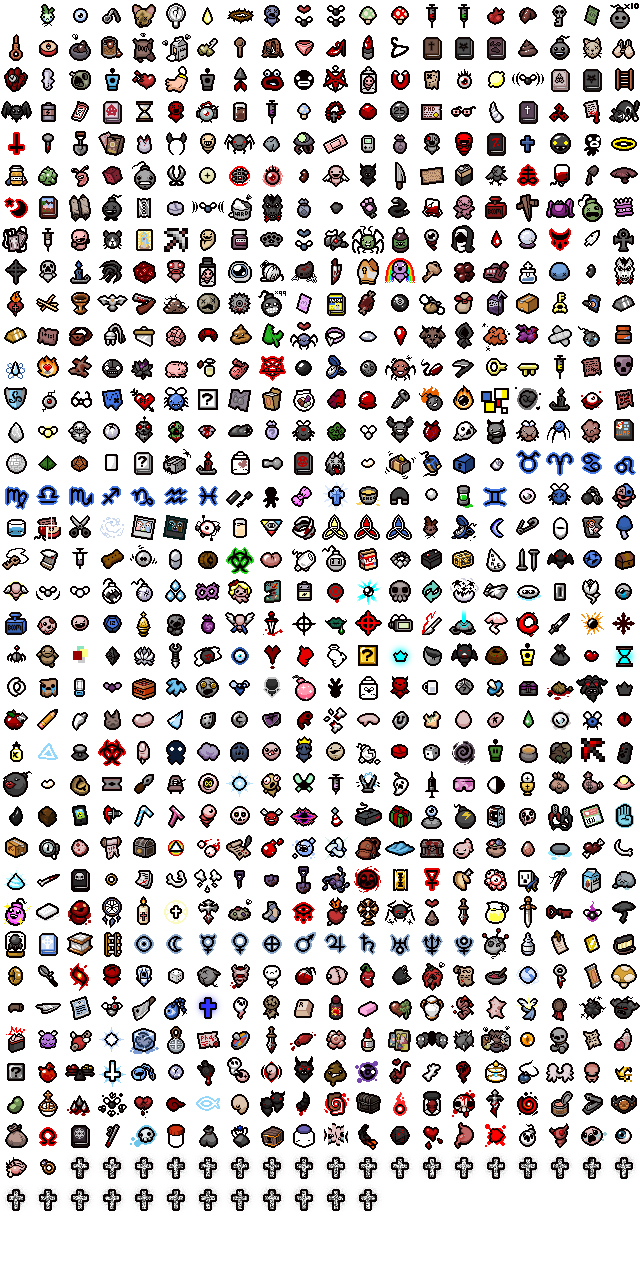

In [11]:
from PIL import Image

pil_image = Image.open("/Users/zhengyiming/Downloads/Collectibles_sprite.png")
pil_image

In [12]:
import os
os.makedirs("./cus_data", exist_ok=True)

In [13]:
# table_texts

In [27]:
for index, i in enumerate(tr_list):
    table_texts = i.xpath(".//text()")
    print(table_texts)
    part_url = i.xpath(".//a/@href")[0]
    full_url = urljoin(base_url, part_url)
    
    id_name = i.xpath(".//a/span/@id")[0]
    print(full_url)
    print(id_name)  # 这个是类别, 按照数字来
    id_value = id_name[-3:]
    print("id_value", id_value)
    
    x,y = id_mapping_dict[id_name]['x'], id_mapping_dict[id_name]['y']
    id_mapping_dict[id_name]['en'] = table_texts[0]
    id_mapping_dict[id_name]['zh'] = table_texts[1]
    id_mapping_dict[id_name]['level'] = table_texts[2]
    id_mapping_dict[id_name]['type'] = table_texts[3]
    id_mapping_dict[id_name]['level2'] = table_texts[4]
    id_mapping_dict[id_name]['?'] = table_texts[5]
    id_mapping_dict[id_name]['desc'] = table_texts[6]
    id_mapping_dict[id_name]['new_id'] = index
    crop_img = cut_image(x,y)
    resized_img = crop_img.resize((32*2, 32*2))  # 放大了这个sprite图
    resized_img.save(f"./cus_data/{index}.png")
    id_mapping_dict[id_name]["image"] = f"./cus_data/{index}.png"
#     plt.figure(figsize=(2, 2))
#     plt.imshow(crop_img)
#     plt.show()    
    print()

['The Sad Onion', '悲伤洋葱', '1', '道具', '3', '/', '射速上升。']
https://isaac.huijiwiki.com/wiki/C1
collectibles_001
id_value 001

['The Inner Eye', '内眼', '2', '道具', '2', '/', '角色每次发射3颗泪弹。']
https://isaac.huijiwiki.com/wiki/C2
collectibles_002
id_value 002

['Spoon Bender', '弯勺魔术', '3', '道具', '3', '/', '角色的泪弹获得追踪效果。']
https://isaac.huijiwiki.com/wiki/C3
collectibles_003
id_value 003

["Cricket's Head", '柯吉猫的头', '4', '道具', '4', '/', '泪弹变大，击退效果上升，伤害上升。']
https://isaac.huijiwiki.com/wiki/C4
collectibles_004
id_value 004

['My Reflection', '我的镜像', '5', '道具', '2', '/', '角色的泪弹会飞回角色身边。']
https://isaac.huijiwiki.com/wiki/C5
collectibles_005
id_value 005

['Number One', '小号', '6', '道具', '2', '/', '射程下降，射速上升。']
https://isaac.huijiwiki.com/wiki/C6
collectibles_006
id_value 006

['Blood of the Martyr', '殉道者之血', '7', '道具', '3', '/', '伤害上升。']
https://isaac.huijiwiki.com/wiki/C7
collectibles_007
id_value 007

['Brother Bobby', '波比兄弟', '8', '道具', '1', '/', '发射普通泪弹的跟班。']
https://isaac.huijiwiki.com/wiki/C8
col


['The Relic', '圣遗物', '98', '道具', '3', '/', '生成魂心的跟班。']
https://isaac.huijiwiki.com/wiki/C98
collectibles_098
id_value 098

['Little Gish', '吉什宝宝', '99', '道具', '2', '/', '发射减速泪弹的跟班。']
https://isaac.huijiwiki.com/wiki/C99
collectibles_099
id_value 099

['Little Steven', '史蒂文宝宝', '100', '道具', '2', '/', '发射追踪泪弹的跟班。']
https://isaac.huijiwiki.com/wiki/C100
collectibles_100
id_value 100

['The Halo', '光环', '101', '道具', '2', '/', '心之容器+1，伤害上升，射速上升，射程上升，移速上升。']
https://isaac.huijiwiki.com/wiki/C101
collectibles_101
id_value 101

["Mom's Bottle of Pills", '妈妈的药瓶', '102', '道具', '1', '6', '使用后，获得一个胶囊。']
https://isaac.huijiwiki.com/wiki/C102
collectibles_102
id_value 102

['The Common Cold', '普通感冒', '103', '道具', '1', '/', '概率发射毒性泪弹。']
https://isaac.huijiwiki.com/wiki/C103
collectibles_103
id_value 103

['The Parasite', '寄生虫', '104', '道具', '3', '/', '泪弹会分裂为两颗。']
https://isaac.huijiwiki.com/wiki/C104
collectibles_104
id_value 104

['The D6', '六面骰', '105', '道具', '4', '6', '使用后，重置房间中的道具。']
https://isa


["Dad's Key", '爸爸的钥匙', '175', '道具', '2', '2', '使用后，打开所有的门。']
https://isaac.huijiwiki.com/wiki/C175
collectibles_175
id_value 175

['Stem Cells', '干细胞', '176', '道具', '1', '/', '心之容器+1，弹速上升。']
https://isaac.huijiwiki.com/wiki/C176
collectibles_176
id_value 176

['Portable Slot', '便携式老虎机', '177', '道具', '0', '0', '使用后，花费1枚硬币进行赌博。']
https://isaac.huijiwiki.com/wiki/C177
collectibles_177
id_value 177

['Holy Water', '圣水', '178', '道具', '3', '/', '射击键发射命中后留下石化水迹的跟班。']
https://isaac.huijiwiki.com/wiki/C178
collectibles_178
id_value 178

['Fate', '宿命', '179', '道具', '3', '/', '永恒之心+1，获得飞行效果。']
https://isaac.huijiwiki.com/wiki/C179
collectibles_179
id_value 179

['The Black Bean', '黑豆', '180', '道具', '0', '/', '受伤时会放毒屁。']
https://isaac.huijiwiki.com/wiki/C180
collectibles_180
id_value 180

['White Pony', '小白马', '181', '道具', '2', '2', '获得飞行效果，移速上升。使用后，向前冲锋，生成圣光。']
https://isaac.huijiwiki.com/wiki/C181
collectibles_181
id_value 181

['Sacred Heart', '圣心', '182', '道具', '4', '/', '发射追踪泪弹，心之容器+1，回满红心，伤

https://isaac.huijiwiki.com/wiki/C281
collectibles_281
id_value 281

['How to Jump', '跳跃教程', '282', '道具', '1', '0', '使用后，向前跳跃。']
https://isaac.huijiwiki.com/wiki/C282
collectibles_282
id_value 282

['D100', '一百面骰', '283', '道具', '3', '6', '使用后，重置角色的所有道具，重置房间中的所有道具和掉落物。']
https://isaac.huijiwiki.com/wiki/C283
collectibles_283
id_value 283

['D4', '四面骰', '284', '道具', '2', '6', '使用后，重置角色的所有道具。']
https://isaac.huijiwiki.com/wiki/C284
collectibles_284
id_value 284

['D10', '十面骰', '285', '道具', '1', '2', '使用后，重置所有敌人。']
https://isaac.huijiwiki.com/wiki/C285
collectibles_285
id_value 285

['Blank Card', '空白卡牌', '286', '道具', '2', '4', '使用后，触发当前卡牌的效果。']
https://isaac.huijiwiki.com/wiki/C286
collectibles_286
id_value 286

['Book of Secrets', '秘密之书', '287', '道具', '1', '6', '使用后，显示1/3的地图。']
https://isaac.huijiwiki.com/wiki/C287
collectibles_287
id_value 287

['Box of Spiders', '蜘蛛盒', '288', '道具', '1', '2', '使用后，生成蓝蜘蛛。']
https://isaac.huijiwiki.com/wiki/C288
collectibles_288
id_value 288

['Red Candle


['More Options', '更多选择', '414', '道具', '3', '/', '宝箱房的道具二选一。']
https://isaac.huijiwiki.com/wiki/C414
collectibles_414
id_value 414

['Crown Of Light', '光明之冠', '415', '道具', '4', '/', '魂心+2，满红心时发射钻石泪弹。']
https://isaac.huijiwiki.com/wiki/C415
collectibles_415
id_value 415

['Deep Pockets', '深口袋', '416', '道具', '2', '/', '金币上限变为999。清理房间后没有生成则生成金币。']
https://isaac.huijiwiki.com/wiki/C416
collectibles_416
id_value 416

['Succubus', '魅魔', '417', '道具', '3', '/', '具有伤害加成光环的跟班。']
https://isaac.huijiwiki.com/wiki/C417
collectibles_417
id_value 417

['Fruit Cake', '水果蛋糕', '418', '道具', '2', '/', '每颗泪弹都具有随机特效。']
https://isaac.huijiwiki.com/wiki/C418
collectibles_418
id_value 418

['Teleport 2.0', '传送2.0', '419', '道具', '3', '4', '使用后，随机传送到一个未进入过的房间。']
https://isaac.huijiwiki.com/wiki/C419
collectibles_419
id_value 419

['Black Powder', '黑色粉末', '420', '道具', '1', '/', '角色会留下黑色粉末，粉末围成圈会形成魔法阵，对敌人造成伤害。']
https://isaac.huijiwiki.com/wiki/C420
collectibles_420
id_value 420

['Kidney Bean', '腰豆', '421', '道具',


['Sulfur', '炼金硫磺', '556', '道具', '3', '3', '使用后，在当前房间内获得', '\xa0', '硫磺火', '的效果。']
https://isaac.huijiwiki.com/wiki/C556
collectibles_556
id_value 556

['Fortune Cookie', '幸运饼干', '557', '道具', '2', '2', '使用后，触发预言机的效果。']
https://isaac.huijiwiki.com/wiki/C557
collectibles_557
id_value 557

['Eye Sore', '眼瘤', '558', '道具', '1', '/', '额外向其他方向发射泪弹。']
https://isaac.huijiwiki.com/wiki/C558
collectibles_558
id_value 558

['120 Volt', '220伏', '559', '道具', '2', '/', '电击靠近的敌人。']
https://isaac.huijiwiki.com/wiki/C559
collectibles_559
id_value 559

['It Hurts', '好疼', '560', '道具', '1', '/', '受伤时发射泪弹，当前房间射速上升。']
https://isaac.huijiwiki.com/wiki/C560
collectibles_560
id_value 560

['Almond Milk', '杏仁奶', '561', '道具', '1', '/', '射速上升，伤害下降。泪弹附带随机蠕虫效果。']
https://isaac.huijiwiki.com/wiki/C561
collectibles_561
id_value 561

['Rock Bottom', '谷底石', '562', '道具', '3', '/', '属性保持在历史最高值。']
https://isaac.huijiwiki.com/wiki/C562
collectibles_562
id_value 562

['Nancy Bombs', '魅彩炸弹', '563', '道具', '2', '/', '炸弹+5。炸弹获得随机


['Card Reading', '牌意解读', '660', '道具', '3', '/', '在初始房间生成通往特殊房间的传送门。']
https://isaac.huijiwiki.com/wiki/C660
collectibles_660
id_value 660

['Quints', '五胞胎', '661', '道具', '2', '/', '消灭敌人时生成最多5个临时的随机跟班。']
https://isaac.huijiwiki.com/wiki/C661
collectibles_661
id_value 661

['Tooth and Nail', '肉中刺', '663', '道具', '2', '/', '每隔一段时间无敌。']
https://isaac.huijiwiki.com/wiki/C663
collectibles_663
id_value 663

['Binge Eater', '大胃王', '664', '道具', '4', '/', '生成的道具会在原选项与食物道具之间循环。拾取食物道具获得属性上升与临时的伤害上升。']
https://isaac.huijiwiki.com/wiki/C664
collectibles_664
id_value 664

["Guppy's Eye", '嗝屁猫的眼睛', '665', '道具', '2', '/', '能够透视宝箱内容物。']
https://isaac.huijiwiki.com/wiki/C665
collectibles_665
id_value 665

['Strawman', '稻草人', '667', '道具', '2', '/', '生成店主作为临时副人物。']
https://isaac.huijiwiki.com/wiki/C667
collectibles_667
id_value 667

["Dad's Note", '爸爸的便条', '668', '道具', '0', '/', '回忆过往。']
https://isaac.huijiwiki.com/wiki/C668
collectibles_668
id_value 668

['Sausage', '腊肠', '669', '道具', '3', '/', '移速、伤害、弹速、

In [29]:
## 增加new_label
id_mapping_dict

import json
json_dumped = json.dumps(id_mapping_dict)
with open("id_mapping_dict.json", "w") as file:
    file.write(json_dumped)
    
print(len(id_mapping_dict))

721


In [30]:
id_mapping_dict

{'collectibles_001': {'x': 32,
  'y': 0,
  'en': 'The Sad Onion',
  'zh': '悲伤洋葱',
  'level': '1',
  'type': '道具',
  'level2': '3',
  '?': '/',
  'desc': '射速上升。',
  'new_id': 0,
  'image': './cus_data/0.png'},
 'collectibles_002': {'x': 64,
  'y': 0,
  'en': 'The Inner Eye',
  'zh': '内眼',
  'level': '2',
  'type': '道具',
  'level2': '2',
  '?': '/',
  'desc': '角色每次发射3颗泪弹。',
  'new_id': 1,
  'image': './cus_data/1.png'},
 'collectibles_003': {'x': 96,
  'y': 0,
  'en': 'Spoon Bender',
  'zh': '弯勺魔术',
  'level': '3',
  'type': '道具',
  'level2': '3',
  '?': '/',
  'desc': '角色的泪弹获得追踪效果。',
  'new_id': 2,
  'image': './cus_data/2.png'},
 'collectibles_004': {'x': 128,
  'y': 0,
  'en': "Cricket's Head",
  'zh': '柯吉猫的头',
  'level': '4',
  'type': '道具',
  'level2': '4',
  '?': '/',
  'desc': '泪弹变大，击退效果上升，伤害上升。',
  'new_id': 3,
  'image': './cus_data/3.png'},
 'collectibles_005': {'x': 160,
  'y': 0,
  'en': 'My Reflection',
  'zh': '我的镜像',
  'level': '5',
  'type': '道具',
  'level2': '2',
  '?': 

In [ ]:
total_str = """# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ../datasets/gen_cus_data  # dataset root dir 配置绝对路径也行
train: images/train  # train images (relative to 'path') 128 images
val: images/val  # val images (relative to 'path') 128 images
test:  # test images (optional)

# Classes
names:\n"""
empty_value_list = []
for i, v in id_mapping_dict.items():  # 生成yaml
    if v.get("new_id") is None:
        empty_value_list.append(i)
    else:
        total_str = total_str + f'  {v.get("new_id")}: {v.get("en").replace(" ", "_")}' + "\n"
total_str

In [ ]:
# clean nouse id
empty_value_list
for i in empty_value_list:
    del id_mapping_dict[i]

In [ ]:
id_mapping_dict

In [ ]:
num = 0
for i, v in id_mapping_dict.items():
    if num != v.get("new_id"):
        print("something err")
        break
    num += 1
    print("i", i)
    print("v", v)

In [ ]:
with open("./gen_cus_data.yaml", "w") as file:
    file.write(total_str)

In [ ]:
id_mapping_dict

In [ ]:
id_value = int(id_name[-3:-1])
print("id_value", id_value)

## 重新做一个映射表, 因为训练模型的输入需要连续的0-n, 而我们自带的标签是1-n并且中间不连续,调整一下

In [ ]:
# 增加一个新的标签叫做new_label 就可以了
import copy
new_id_mapping_dict = {}
num = 0
for i, v in id_mapping_dict.items():
    print("i", i)
    print("v", v)
    copy_v = copy.deepcopy(v)
    copy_v['new_id'] = 0
    new_id_mapping_dict[i] = copy_v
    num += 1
new_id_mapping_dict

In [ ]:
id_mapping_dict

## 合成类别的训练数据, 合成目标检测的训练数据

### 一般照片情况检查

In [25]:
phone_image = Image.open("/Users/zhengyiming/Downloads/IMG_4027.png")
x, y = phone_image.size  # 这个尺寸很大
print(x, y)

5712 4284


crop_phone_image size (571, 428)


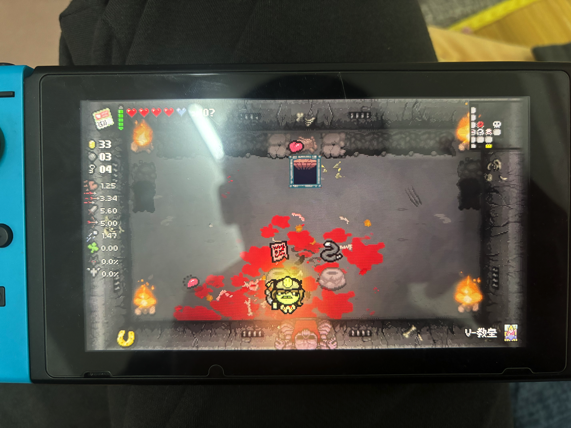

In [26]:
rate = 10
crop_phone_image = phone_image.resize((int(x/rate), int(y/rate)))
print("crop_phone_image size", crop_phone_image.size)
crop_phone_image

### 这个缩放比还是可以的, 那我的图像增强就暂时不做缩放类的,只要确保输入也是这个比例  
我的轻微旋转还是需要的, 因为拍照不一定很水平

开始合成训练数据,一张图片训练一个对象,这个应该很简单吧,种类多主要是

## 合成训练数据

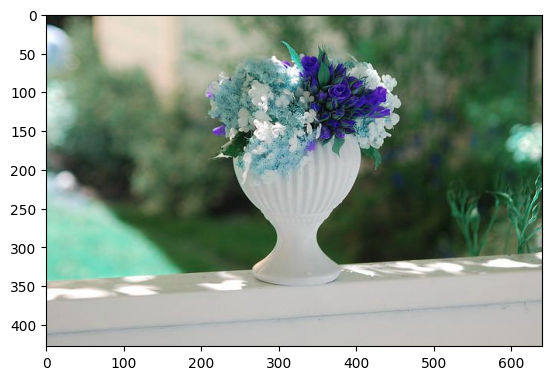

In [21]:
import cv2
image = cv2.imread("/Users/zhengyiming/Downloads/coco128_副本/images/train2017/000000000030.jpg")
plt.imshow(image)
# image

In [ ]:
image.shape[:2]

In [ ]:
## 试一下嘛, 不要完美主义,直接作出最简单的,然后再逐个去完善就可以了

428 640


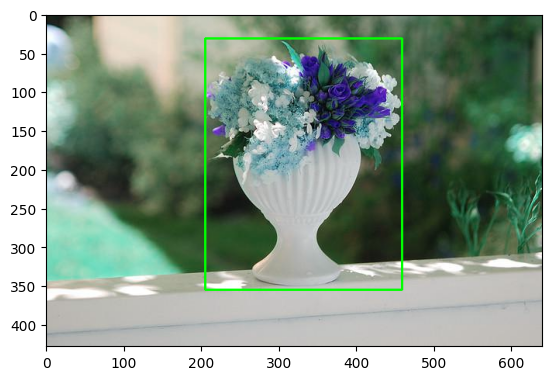

In [23]:
height, width = image.shape[:2]   # 直接给电脑就可以了
print(height, width)


# 解析标签信息
class_id, x_norm, y_norm, w_norm, h_norm = 58, 0.519219, 0.451121, 0.39825, 0.75729

# 将归一化坐标转换为像素坐标
x, y = int(x_norm * width), int(y_norm * height)
w, h = int(w_norm * width), int(h_norm * height)

# 计算左上角和右下角坐标
left = int(x - w/2)
top = int(y - h/2)
right = int(x + w/2)
bottom = int(y + h/2)

# 绘制边界框
cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)
plt.imshow(image)

In [ ]:
### 简单的合成一张有一个随机图片的

In [ ]:

# image_height, image_width = image.shape[:2] 
def convert_to_coco128_label_format(class_id, x, y, width, height, image_height, image_width):
    # 计算目标框的中心点坐标
    center_x = x + width / 2
    center_y = y + height / 2

    # 将中心点和尺寸归一化
    norm_center_x = center_x / image_width
    norm_center_y = center_y / image_height
    norm_width = width / image_width
    norm_height = height / image_height

    # 将归一化值转换为COCO128格式
    coco_label = f"{class_id} {norm_center_x} {norm_center_y} {norm_width} {norm_height}"
    
    return coco_label

# 接下来这个是用来把合成的转化过去的

In [ ]:
import cv2
import numpy as np
import random

def generate_training_data(subgraph_list, background_size, num_subgraphs):
    # 创建背景画布
    background = np.zeros((background_size[1], background_size[0], 3), dtype=np.uint8)
    image_height, image_width = background.shape[:2]
    print("height, widht", height, width)

    # 随机选择子图并合成到背景上
    labels = []
    for _ in range(num_subgraphs):
        try:
            # 从子图列表中随机选择一个子图
            print()
            subgraph_path = random.choice(subgraph_list)
            class_id = int(subgraph_path.replace(".png", "").split("/")[-1])
            print(class_id)

            # 加载子图及其透明度通道
            subgraph = cv2.imread(subgraph_path, cv2.IMREAD_UNCHANGED)
            subgraph_alpha = subgraph[:, :, 3] / 255.0

            # 随机生成子图在背景上的位置
            subgraph_pos = (random.randint(0, background_size[0] - subgraph.shape[1]),
                            random.randint(0, background_size[1] - subgraph.shape[0]))
            print(subgraph_pos)
            x, y = subgraph_pos
            label = convert_to_coco128_label_format(class_id, x, y, 64, 64, image_height, image_width)
            print("label: ", label)
            labels.append(label)

            # 检查子图是否与已有子图重叠
            if np.any(background[subgraph_pos[1]:subgraph_pos[1]+subgraph.shape[0],
                                 subgraph_pos[0]:subgraph_pos[0]+subgraph.shape[1]] != 0):
                continue

            # 将子图合成到背景上
            for c in range(3):
                background[subgraph_pos[1]:subgraph_pos[1]+subgraph.shape[0],
                           subgraph_pos[0]:subgraph_pos[0]+subgraph.shape[1], c] = \
                    subgraph[:, :, c] * subgraph_alpha + \
                    background[subgraph_pos[1]:subgraph_pos[1]+subgraph.shape[0],
                               subgraph_pos[0]:subgraph_pos[0]+subgraph.shape[1], c] * (1 - subgraph_alpha)
        except Exception as e:
            print()
    
    # 随机生成背景颜色
    background_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    background[np.where((background == [0, 0, 0]).all(axis=2))] = background_color

    return background, labels


def gen_train_datasets(train_type, range_start, range_end):  # train / val
    images_path = f"./datasets/gen_cus_data/images/{train_type}"
    labels_path = f"./datasets/gen_cus_data/labels/{train_type}"
    os.makedirs(images_path, exist_ok=True)
    os.makedirs(labels_path, exist_ok=True)
        
    meta_subpng_path = "./cus_data/"
    file_list = os.listdir(meta_subpng_path)
    file_list.sort()
    file_list
    
    for i in range(range_start, range_end):
#     for i in range(501, 600):
    
        # 子图PNG列表
        
        subgraph_list = [f'./cus_data/{i}' for i in file_list]  # 这儿就不对了

        # 背景尺寸
        background_size = (571, 428)

        # 合成的子图数量
        num_subgraphs = random.randint(10, 20)

        # 生成训练数据
        training_image ,labels = generate_training_data(subgraph_list, background_size, num_subgraphs)

        # 显示合成的训练数据
        cv2.imwrite(os.path.join(images_path, f"{str(i).zfill(5)}.png"), training_image)
        with open(os.path.join(labels_path, f"{str(i).zfill(5)}.txt"), "w") as file:
            for i in labels:
                file.write(i + "\n")
    
        

    plt.imshow(training_image)
    


# 测试代码
if __name__ == '__main__':
    gen_train_datasets("train", 1, 500)  # train / val
    gen_train_datasets("val", 501, 600)  # train / val

In [ ]:
## 检查生成的训练数据
!zip -r datasets.zip datasets

In [ ]:
pwd

In [22]:
def plot_label(raw_image, labels):
    height, width = raw_image.shape[:2]   # 直接给电脑就可以了
    print(height, width)
    plt_image = raw_image.copy()


    # 解析标签信息
    for i in range(len(labels)):
        # class_id, x_norm, y_norm, w_norm, h_norm = 58, 0.519219, 0.451121, 0.39825, 0.75729
        class_id, x_norm, y_norm, w_norm, h_norm = labels[i].split(" ")
        class_id = int(class_id)
        x_norm = float(x_norm)
        y_norm = float(y_norm)
        w_norm = float(w_norm)
        h_norm = float(h_norm)

        # 将归一化坐标转换为像素坐标
        x, y = int(x_norm * width), int(y_norm * height)
        w, h = int(w_norm * width), int(h_norm * height)

        # 计算左上角和右下角坐标
        left = int(x - w/2)
        top = int(y - h/2)
        right = int(x + w/2)
        bottom = int(y + h/2)

        # 绘制边界框
        cv2.rectangle(plt_image, (left, top), (right, bottom), (0, 255, 0), 2)
    plt.imshow(plt_image)
    
plot_label(training_image, labels)

NameError: name 'training_image' is not defined